In [1]:
import sys

import pandas as pd

import superlets_package.superlets

sys.path.insert(0, '..')


In [2]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import importlib
import scipy.signal as signal_scipy
import os

from scipy.ndimage import gaussian_filter1d

import superlets_package.morlet as morlet
import superlets_package.superlets as superlet

In [3]:
importlib.reload(superlet)

<module 'superlets_package.superlets' from '/Users/neuralrehabilitationgroup/PycharmProjects/Superlets-Marina/superlets_package/superlets.py'>

# Create simulated EMG signals

#### Baseline parameters

In [108]:
fs = 1024
signal_duration = 3
t = np.linspace(0, signal_duration, signal_duration * fs)
#noise = np.randomnormal(0, 0.01, len(t))  # Gaussian noise
#noise = np.full(len(t), 1e-10)
noise = np.full(len(t), 0.1)
#noise = np.zeros(len(t))

### Burst parameters

In [109]:
burst_duration_1 = 1 #seconds
burst_start_1 = 1

#### Select method (DeLuca, band-pass filter)

In [110]:
mode = 'DeLuca'
#mode = 'Filter'
#mode = 'Matlab'

### Charge signals generated in Matlab

In [111]:
if mode == 'Matlab':
    burst_1 = pd.read_csv('burst_1s_matlab.csv', header = None)
    burst_1 = burst_1[0]

### Simulated EMG signal with bandpass filter

In [112]:
if mode == 'Filter':
    
    # Create noise
    #MNF_1 = [110.71]  # Central frequency
    bw = 100    # Filter bandwidth
    
    low_cut = 20
    high_cut = 300
    
    plot = True
    
    # We generate gaussian noise
    samples = int(burst_duration_1 * fs)
    t = np.linspace(0, burst_duration_1, samples, endpoint=False)
    gauss_noise = np.random.normal(0, 1, samples)  # Ruido gaussiano de media 0 y varianza 1
    
    # Create and apply filter
    nyquist = fs / 2
    #frec_baja = (MNF_1[0] - bw / 2) / nyquist
    frec_baja = low_cut / nyquist
    #frec_alta = (MNF_1[0] + bw / 2) / nyquist
    frec_alta = high_cut / nyquist
    # Diseñar filtro paso banda Butterworth
    b, a = signal_scipy.butter(N=4, Wn=[frec_baja, frec_alta], btype='band')
    burst_1 = signal_scipy.filtfilt(b, a, gauss_noise)
    
    if plot:
        plt.figure(figsize=(12, 6))
        plt.subplot(2, 1, 1)
        plt.plot(t, gauss_noise)
        plt.title("Gaussian noise")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.grid()
        plt.subplot(2, 1, 2)
        plt.plot(t, burst_1, color='orange')
        plt.title(f"Filtered noise")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.grid()
        plt.tight_layout()
        plt.show()
        
    w, h = signal_scipy.freqz(b, a, worN=8000)  # worN determina el número de puntos a evaluar

    # Graficar respuesta en frecuencia
    plt.figure()
    plt.plot(w * nyquist / np.pi, 20 * np.log10(abs(h)), label="Respuesta en Frecuencia")
    plt.title("Respuesta en Frecuencia del Filtro Butterworth")
    plt.xlabel("Frecuencia (Hz)")
    plt.ylabel("Amplitud (dB)")
    plt.grid()
    plt.legend()
    plt.show()


### Simulated EMG signal: Modelo de DeLuca

In [113]:
importlib.reload(superlet)

<module 'superlets_package.superlets' from '/Users/neuralrehabilitationgroup/PycharmProjects/Superlets-Marina/superlets_package/superlets.py'>

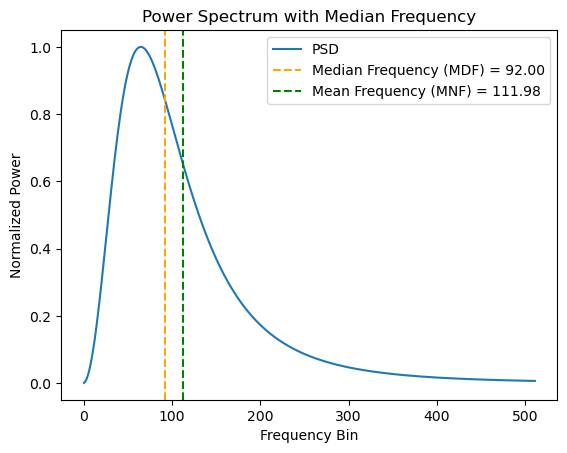

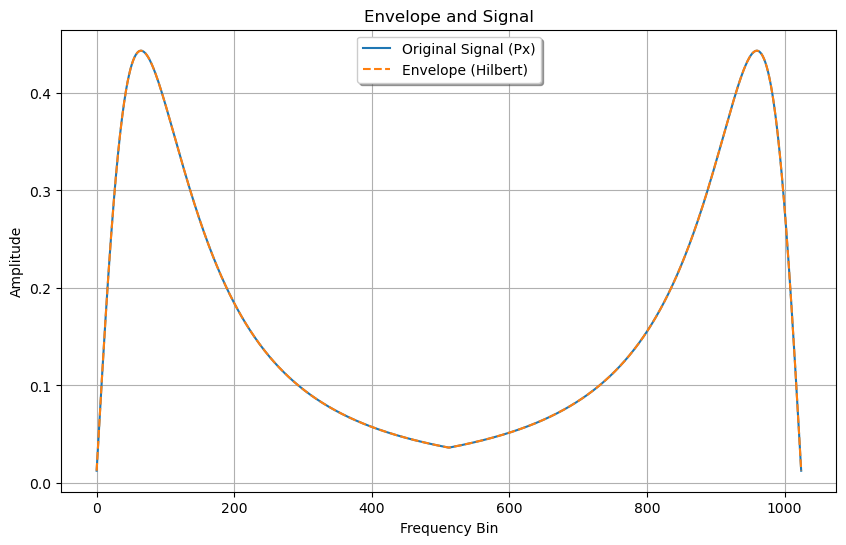

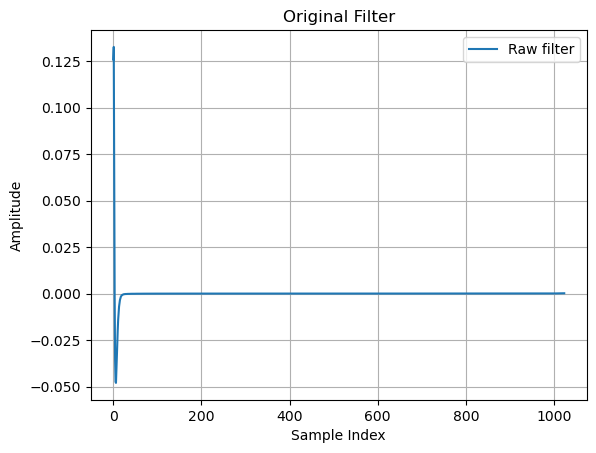

In [114]:
if mode == 'DeLuca':
    burst_1 = []
    #[filtro, Pdeluca, burst_1] = superlet.fdeluca(72, 110, 1024, burst_duration_1, plot = True)
    [filtro, Pdeluca, burst_1, MNF, MNF_analytic] = superlet.fdeluca(100, 80, fs, burst_duration_1, plot = True)
    f = np.arange(0, fs / 2)
    MNF_IDEAL = superlet.meanfreq(Pdeluca,f)
    MNF_1 = [MNF_IDEAL]
    t_onset_1 = burst_start_1
    t_offset_1 = burst_start_1 + burst_duration_1
    # bw = 100
    # nyquist = fs / 2
    # frec_baja = (MNF_1[0] - bw / 2) / nyquist
    # frec_alta = (MNF_1[0] + bw / 2) / nyquist
    # # Diseñar filtro paso banda Butterworth
    # b, a = signal.butter(N=4, Wn=[frec_baja, frec_alta], btype='band')
    # burst_1 = signal.filtfilt(b, a, burst_1)

In [115]:
MNF

111.9768544755227

In [116]:
MNF_IDEAL

110.97685447552273

#### Add noise to the signal with a particular value for SNR

In [118]:
def add_noise(x, snr, plot = False):
    """
    Add Gaussian random noise to a signal with a specified SNR.

    Parameters:
        x (numpy array): Original signal (vector)
        snr (float): Desired Signal-to-Noise Ratio (in dB)

    Returns:
        numpy array: Signal with added Gaussian noise
    """
    n = len(x)  # Length of the signal
    Px = np.sum(np.abs(x)**2) / n  # Power of the original signal
    Pn = Px / (10**(snr / 10))  # Noise power for the given SNR

    noise = np.sqrt(Pn) * np.random.randn(*x.shape)  # Generate Gaussian noise
    xn = x + noise  # Add noise to the original signal

    # Plot the original and noisy signals
    if plot:
        plt.figure()
        plt.plot(xn, 'r', label='Noisy Signal')
        plt.plot(x, 'b', label='Original Signal')
        plt.legend()
        plt.title(f'Signal with Added White Gaussian Noise (SNR = {snr} dB)')
        plt.xlabel('Sample Index')
        plt.ylabel('Amplitude')
        plt.show()

    return xn

### We add burst to baseline signal

In [119]:
baseline_1 = noise.copy()
baseline_1[int(burst_start_1*fs):int(burst_start_1*fs + len(burst_1))] += burst_1

In [120]:
# burst_duration_2 = 3
# burst_start_2 = 5
# 
# [Pxx_2, burst_2, MNF_2, MDF_2] = superlet.fdeluca_changing(100, 140, 80, 120, fs, burst_duration_2, 0.125, plot = True)
# # t_2 = np.linspace(0, burst_duration_2, len(burst_2))
# # plt.plot(t_2, burst_2)
# # plt.title('Burst 2')
# # 
# plt.figure()
# psd_welch, f_welch = superlet.compute_psd_welch(burst_2, fs, plot=True, muscle='Burst 2')
# 
# baseline_1[burst_start_2*fs:burst_start_2*fs + len(burst_2)] += burst_2
# # plt.figure()
# # plt.plot(baseline_1)
# # plt.title('Baseline + Burst 2')

In [121]:
# # High frequency and very fast burst
# burst_duration_3 = 0.5
# burst_start_3 = 8.5
# 
# [Pxx_3, burst_3, MNF_3, MDF_3] = superlet.fdeluca_changing(220, 250, 200, 230, fs, burst_duration_3, 0.125, plot = False)
# # t_3 = np.linspace(0, burst_duration_3, len(burst_3))
# # plt.plot(t_3, burst_3)
# # plt.title('Burst 3')
# # 
# # plt.figure()
# psd_welch, f_welch = superlet.compute_psd_welch(burst_3, fs, plot=True, muscle='Burst 3')
# 
# baseline_1[int(burst_start_3 * fs):int(burst_start_3 * fs + len(burst_3))] += burst_3
# # plt.figure()
# # plt.plot(baseline_1)
# # plt.title('Baseline + Burst 3')

### Signal visualization

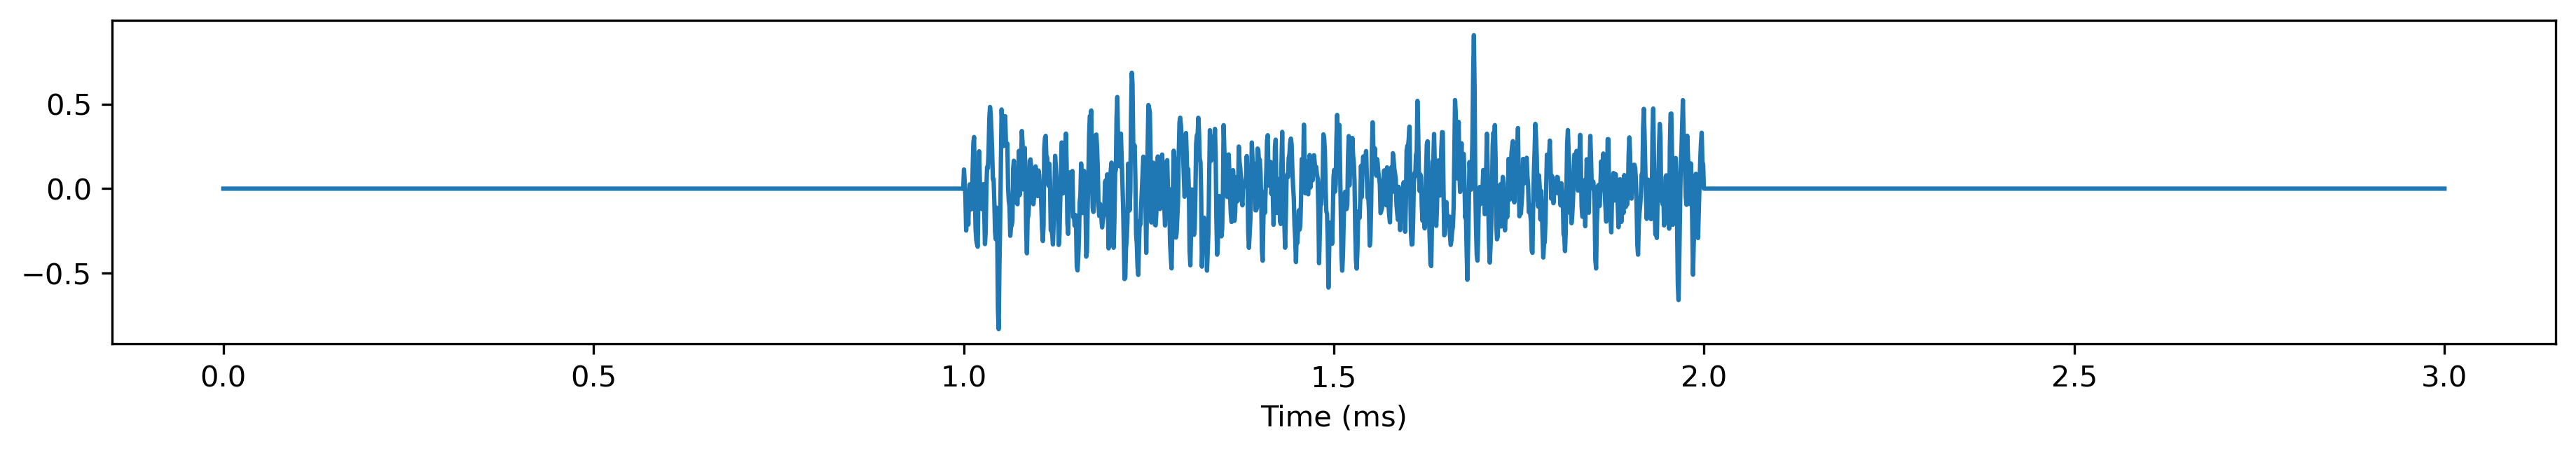

In [123]:
signal = baseline_1
fig, ax = plt.subplots(figsize=(15, 2), dpi=300)
ax.set_xlabel("Time (ms)")
ax.plot(jnp.linspace(0, len(signal - np.mean(signal))/fs, len(signal - np.mean(signal))), signal - np.mean(signal))

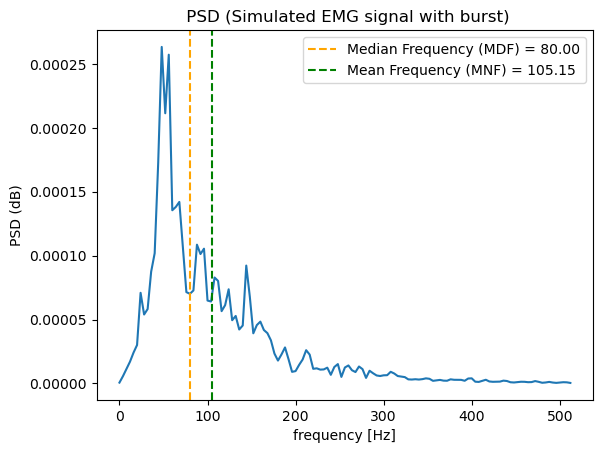

In [124]:
psd_welch, f_welch, MNF = superlet.compute_psd_welch(signal - np.mean(signal), fs, plot=True, muscle='Simulated EMG signal with burst')
#MNF_1 = [MNF]

We first apply regular wavelet transforms to the signal, with wavelets of 3, 16 and 33 cycles long, respectively. Note that we specifically use the complex Morlet wavelet for both the wavelet and superlet transforms.

In [125]:
MNF_1

[110.97685447552273]

In [126]:
def calculate_mae(estimates, true_value):
    errors = np.abs(np.array(estimates) - true_value)
    mae = np.mean(errors)
    std_error = np.std(np.array(estimates))
    return mae, std_error

In [127]:
freqs = np.linspace(20,500,int(fs/2)) # Número de puntos del vector frecuencia
freq_min = freqs[0]  # Minimum freq
freq_max = freqs[-1]  # Frecuencia máxima
num_freqs = len(freqs)  # Resolución del rango de frecuencias

In [128]:
if 'SNR' not in globals():
    SNR = "Inf"

## WAVELET PARAMETERS = 3, 16, 33, 55, 60, 115 cycles

In [129]:
importlib.reload(morlet)

<module 'superlets_package.morlet' from '/Users/neuralrehabilitationgroup/PycharmProjects/Superlets-Marina/superlets_package/morlet.py'>

In [130]:
importlib.reload(superlet)

<module 'superlets_package.superlets' from '/Users/neuralrehabilitationgroup/PycharmProjects/Superlets-Marina/superlets_package/superlets.py'>

In [131]:
offset = 0 # Para que la figura del instant mean frequency sea más mona
offset_burst = 0

In [29]:
params_wavelet = [3, 16, 33, 55, 60]

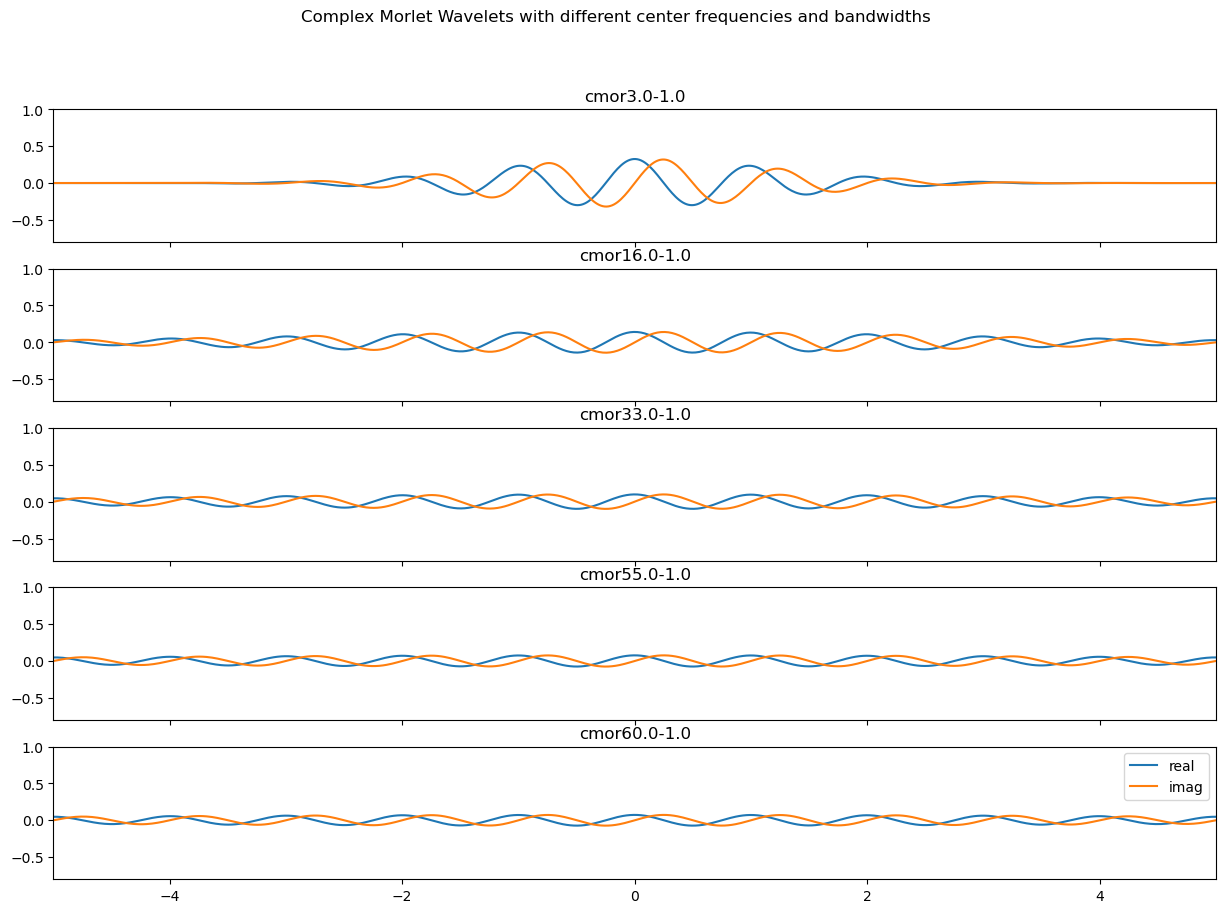

In [132]:
# Plot complex morlet wavelets with different center frequencies and bandwidths
import pywt
#wavelets = [f"cmor{x:.1f}-{y:.1f}" for x, y in zip(params_wavelet,[0.5, 1.0, 1.5, 2.0, 2.5, 3.0])]
wavelets = [f"cmor{x:.1f}-{y:.1f}" for x, y in zip(params_wavelet,[1.0, 1.0, 1.0, 1.0, 1.0, 1.0])]
fig, axs = plt.subplots(len(params_wavelet), figsize=(15, 10), sharex=True, sharey=True)
for ax, wavelet in zip(axs.flatten(), wavelets):
    [psi, x] = pywt.ContinuousWavelet(wavelet).wavefun(10)
    ax.plot(x, np.real(psi), label="real")
    ax.plot(x, np.imag(psi), label="imag")
    ax.set_title(wavelet)
    ax.set_xlim([-5, 5])
    ax.set_ylim([-0.8, 1])
ax.legend()
plt.suptitle("Complex Morlet Wavelets with different center frequencies and bandwidths")
plt.show()

In [133]:
MNF_1

[110.97685447552273]

In [134]:
folder_out = "/Users/neuralrehabilitationgroup/PycharmProjects/Superlets-Marina/RESULTS"
new_folder_path = os.path.join(folder_out, str(round(MNF_1[0], 2)) + ' Hz')
os.makedirs(new_folder_path, exist_ok=True)

In [137]:
plot_1 = False
plot_2 = False
plot_means = False
save = False

In [138]:
# if plot_1:
#     fig, ax = plt.subplots(ncols=len(params_wavelet), figsize=(18, 5), dpi=300)
# if plot_2:
#     # Definir límites de color para que sean iguales en todos los subplots
#     fig_2, ax_2 = plt.subplots(ncols=len(params_wavelet), figsize=(18, 5), dpi=300)
#     fig_3, ax_3 = plt.subplots(figsize=(10, 6))
# 
# mae_wavelet_f = []
# std_wavelet_f = []
# 
# mae_wavelet_t = []
# std_wavelet_t = []
# 
# total_time = []
# total_freq = []
# 
# total_scalogram_wavelet = []
# res_wavelet = []
# 
# # Iterar sobre los parámetros de wavelet
# for i, c in enumerate(params_wavelet):
#     wavelet = f"cmor{c}-1.0"
# 
#     cwtmatr, f, physical_freqs = morlet.wavelet_transform_2(signal,wavelet,freqs,fs)
#     cwtmatr = np.abs(cwtmatr[:, :])
# 
#     if save:
#         df = pd.DataFrame(cwtmatr)
# 
#         # Guardar en un archivo CSV
#         filename = os.path.join(new_folder_path, str(SNR) + "dB_wv_" + str(c) + ".csv")
#         df.to_csv(filename, index=False, header=False)  # Sin índices ni encabezados
# 
#     scalogram_2 = jnp.abs(cwtmatr)**2
# 
#     if np.any(np.isnan(scalogram_2)) or np.any(np.isinf(scalogram_2)):
#         scalogram_2 = np.nan_to_num(scalogram_2)
# 
#     if plot_1:
#         pcm = ax[i].pcolormesh(t,f, scalogram_2, shading='gouraud', cmap='jet')
# 
#         ax[i].set_title(f'c={c}')
#         ax[i].set_ylabel('Frecuencia [Hz]')
#         ax[i].set_xlabel('Tiempo [s]')
# 
#         cbar = fig.colorbar(pcm, ax=ax[i], orientation='horizontal')
#         cbar.set_label('Power', rotation=0, labelpad=15)  # Etiqueta de la colorbar
# 
#         ax[i].set_ylim(freqs[0], freqs[-1])  # Ajustar el rango de frecuencias si es necesario
#         plt.tight_layout()
# 
#     total_scalogram_wavelet.append(scalogram_2)
#     instant_mean_freq_total = []
# 
#     # Para evitar la división por cero
#     # denominador = np.sum(scalogram_2, axis=0)
#     # denominador = np.where(denominador == 0, 1e-10, denominador)
# 
#     instant_freq = np.sum(scalogram_2 * f[:, np.newaxis], axis=0) / np.sum(scalogram_2, axis=0)
#     # plt.figure()
#     # plt.plot(instant_freq)
# 
# 
#     # 1. Compute the derivative to see the slope
#     sigma = 10  # Desviación estándar del filtro PARA SNR = INF
#     y_smooth = gaussian_filter1d(instant_freq, sigma)
# 
#     # Calcular pendientes locales usando np.gradient sobre la señal suavizada
#     slope_gradient = np.gradient(y_smooth, t)
#     #slope_gradient = np.gradient(instant_freq, t)
# 
#     time_range = len(slope_gradient)//2
#     time_shift = round(burst_duration_1 * 0.7 * fs)
#     inicio = time_range-time_shift
# 
#     first_index = np.argmax(slope_gradient[inicio:time_range]) + inicio
#     last_index = np.argmin(slope_gradient[time_range:time_range+time_shift]) + time_range  # Índice del mínimo más significativo
# 
#     # Encontrar el índice de la pendiente ascendente más pronunciada
# 
# 
#     # # Start of the first positive slope
#     # first_positive_index = np.where(slope_gradient > slope_threshold)[0][0]
#     # 
#     # # End of the final negative slope
#     # last_negative_index = np.where(slope_gradient < -slope_threshold)[0][-1]
# 
#     t_onset = t[first_index]
#     t_offset = t[last_index]
# 
#     # Visualization
#     plt.figure(figsize=(12, 6))
# 
#     plt.subplot(2, 1, 1)
#     plt.plot(t, instant_freq)
#     plt.plot(t, y_smooth)
#     plt.axvline(t_onset, color='green', linestyle='--', label='t_onset')
#     plt.axvline(t_offset, color='red', linestyle='--', label='t_offset')
#     plt.xlabel('Time (s)')
#     plt.ylabel('Freq (Hz)')
#     plt.legend()
#     plt.grid()
# 
#     # Slopes and t_onset and t_offset
#     plt.subplot(2, 1, 2)
#     plt.plot(t, slope_gradient, 'g-', label='Local slope (np.gradient)')
#     plt.axvline(t_onset, color='green', linestyle='--', label='Start of the first positive slope')
#     plt.axvline(t_offset, color='red', linestyle='--', label='End of the final negative slope')
#     plt.xlabel('Time (s)')
#     plt.ylabel('Slope')
#     plt.legend()
#     plt.grid()
# 
#     plt.tight_layout()
# 
#     start_idx = np.searchsorted(t, burst_start_1)  # Encuentra el índice de inicio
#     end_idx = np.searchsorted(t, burst_start_1 + burst_duration_1)  # Encuentra el índice final
# #
#     instant_mean_freq_burst = instant_freq[start_idx:end_idx]
# 
#     if plot_2:
#         ax_2[i].plot(t, instant_freq)
# 
#         ax_2[i].set_xlabel("Time (s)")
#         ax_2[i].set_ylabel("Frequency (Hz)")
#         #ax_2[i].set_xlim(t[0], t[-1])
#         #plt.title("Medias de cada fila en función del tiempo")
#         ax_2[i].grid(True)
# 
#         ax_3.plot(t, instant_freq, label=f"Mean frequency (Cycles: {c})")
#         plt.tight_layout()
# 
#     #MAE in frequency
#     print(np.mean(instant_mean_freq_burst))
#     mae_f, std_f = calculate_mae(instant_mean_freq_burst, MNF_1)
#     mae_wavelet_f.append(mae_f)
#     std_wavelet_f.append(std_f)
# 
#     #MAE in time
#     print(f'Onset = {t_onset}, offset = {t_offset}')
#     estimates_combined = t_offset - t_onset
#     print(f'Estimated difference: {estimates_combined} s')
#     true_values_combined = t_offset_1 - t_onset_1
#     print(f'Real difference: {true_values_combined} s')
# 
#     mae_t, std_t = calculate_mae(estimates_combined, true_values_combined)
#     mae_wavelet_t.append(mae_t)
#     std_wavelet_t.append(std_t)
# 
#     time = np.arange(scalogram_2.shape[1]) / fs
# 
#     total_time.append(time)
#     total_freq.append(freqs)
# 
# # Configuración del gráfico
# if plot_2:
#     ax_3.set_xlabel("Time (s)")
#     ax_3.set_ylabel("Frequency (Hz)")
#     ax_3.legend()
#     ax_3.grid(True)
#     ax_3.set_title("Comparación de frecuencias medias instantáneas")
# 
# res_wavelet = superlet.compute_avg_response_resolution(total_scalogram_wavelet, total_time, total_freq, params_wavelet)

/var/folders/63/2lz089h509ddd045_5prskfm0000gn/T/ipykernel_10681/334137043.py:60: RuntimeWarning: invalid value encountered in divide
  instant_freq = np.sum(scalogram_2 * f[:, np.newaxis], axis=0) / np.sum(scalogram_2, axis=0)


Estimated mean frequency: 107.79013638403472 Hz
Estimated onset = 0.9827417779225008 s, offset = 2.004558775643113 s
Estimated difference: 1.0218169977206122 s
Real difference: 1 s


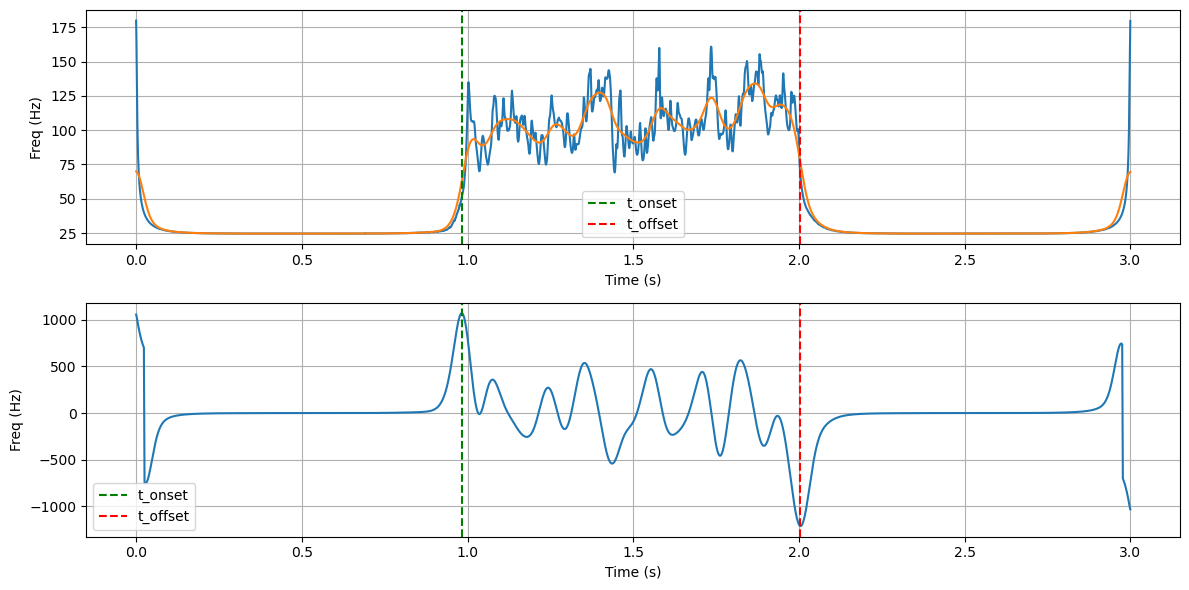

Estimated mean frequency: 104.35335901516981 Hz
Estimated onset = 0.986649299902312 s, offset = 2.009443178117877 s
Estimated difference: 1.022793878215565 s
Real difference: 1 s


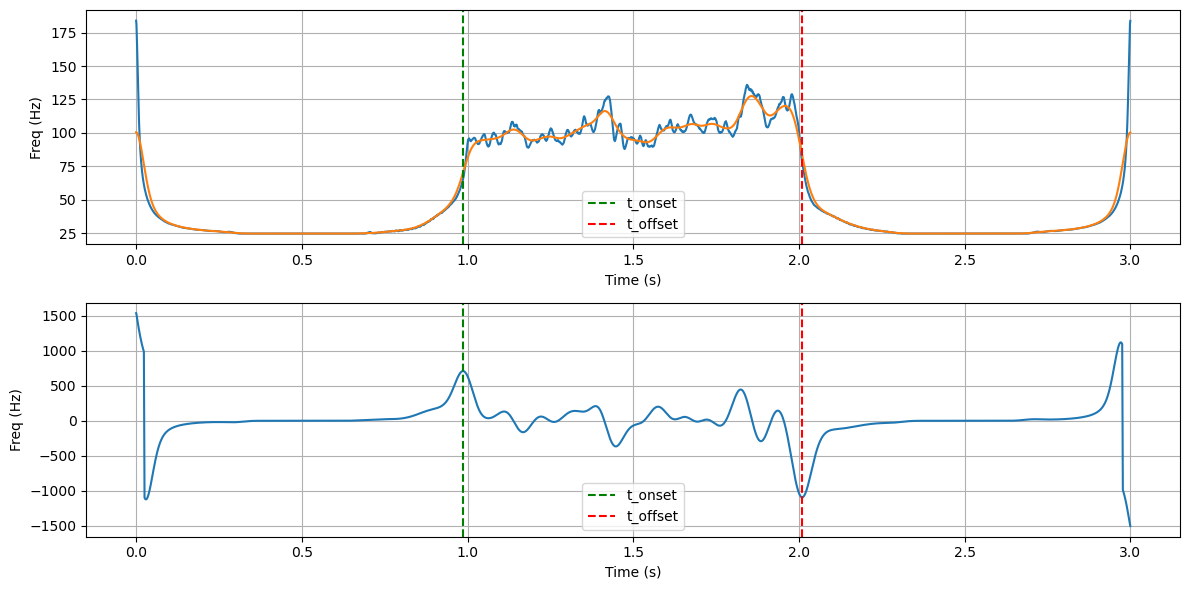

Estimated mean frequency: 104.32507783844308 Hz
Estimated onset = 0.9876261803972648 s, offset = 2.014327580592641 s
Estimated difference: 1.026701400195376 s
Real difference: 1 s


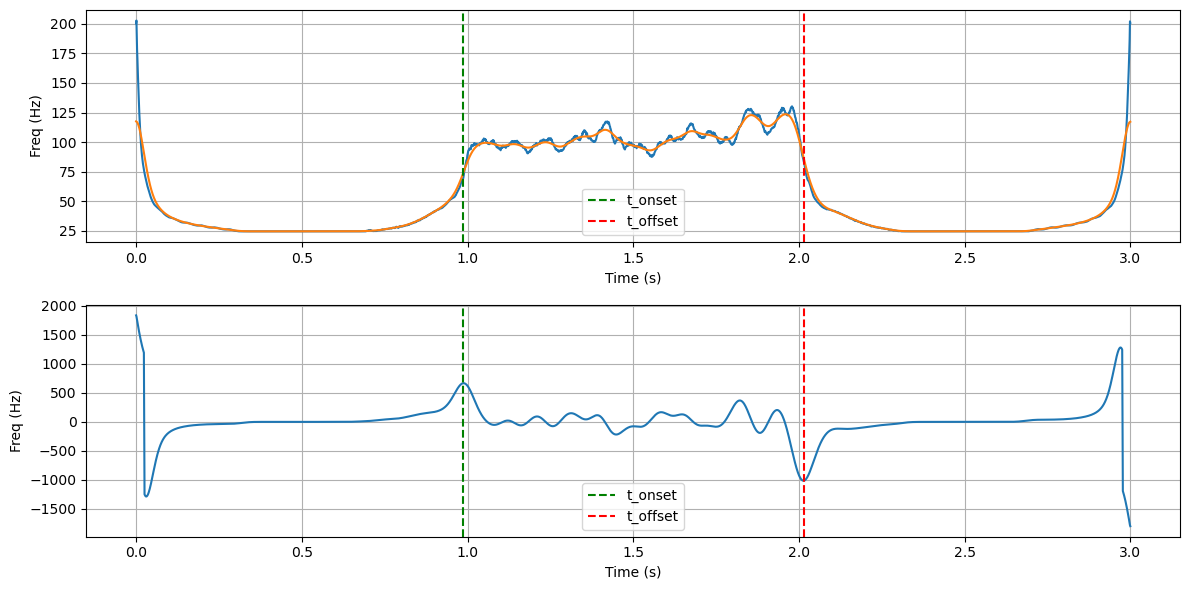

Estimated mean frequency: 104.84492603413376 Hz
Estimated onset = 0.9886030608922175 s, offset = 2.017258222077499 s
Estimated difference: 1.0286551611852817 s
Real difference: 1 s


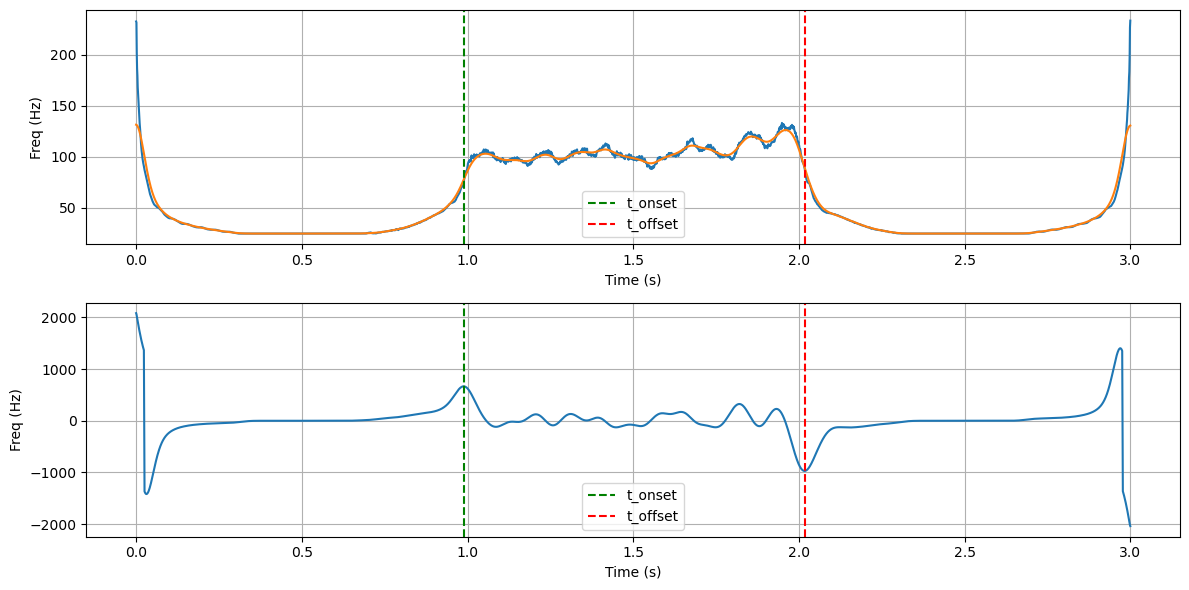

Estimated mean frequency: 104.96738643160054 Hz
Estimated onset = 0.9886030608922175 s, offset = 2.018235102572452 s
Estimated difference: 1.0296320416802347 s
Real difference: 1 s


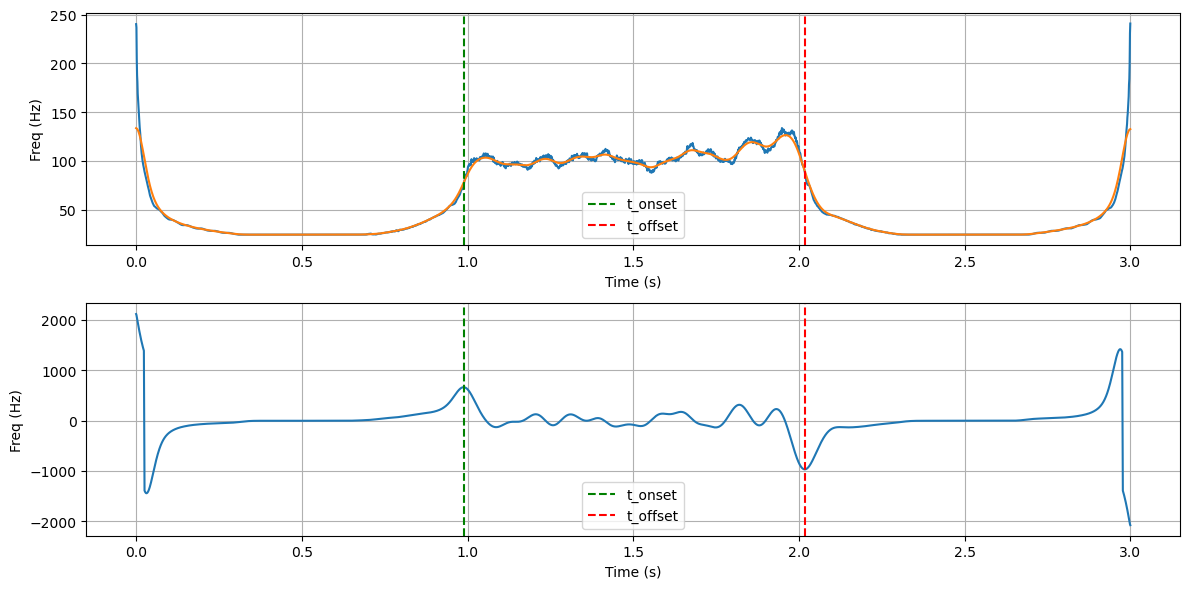

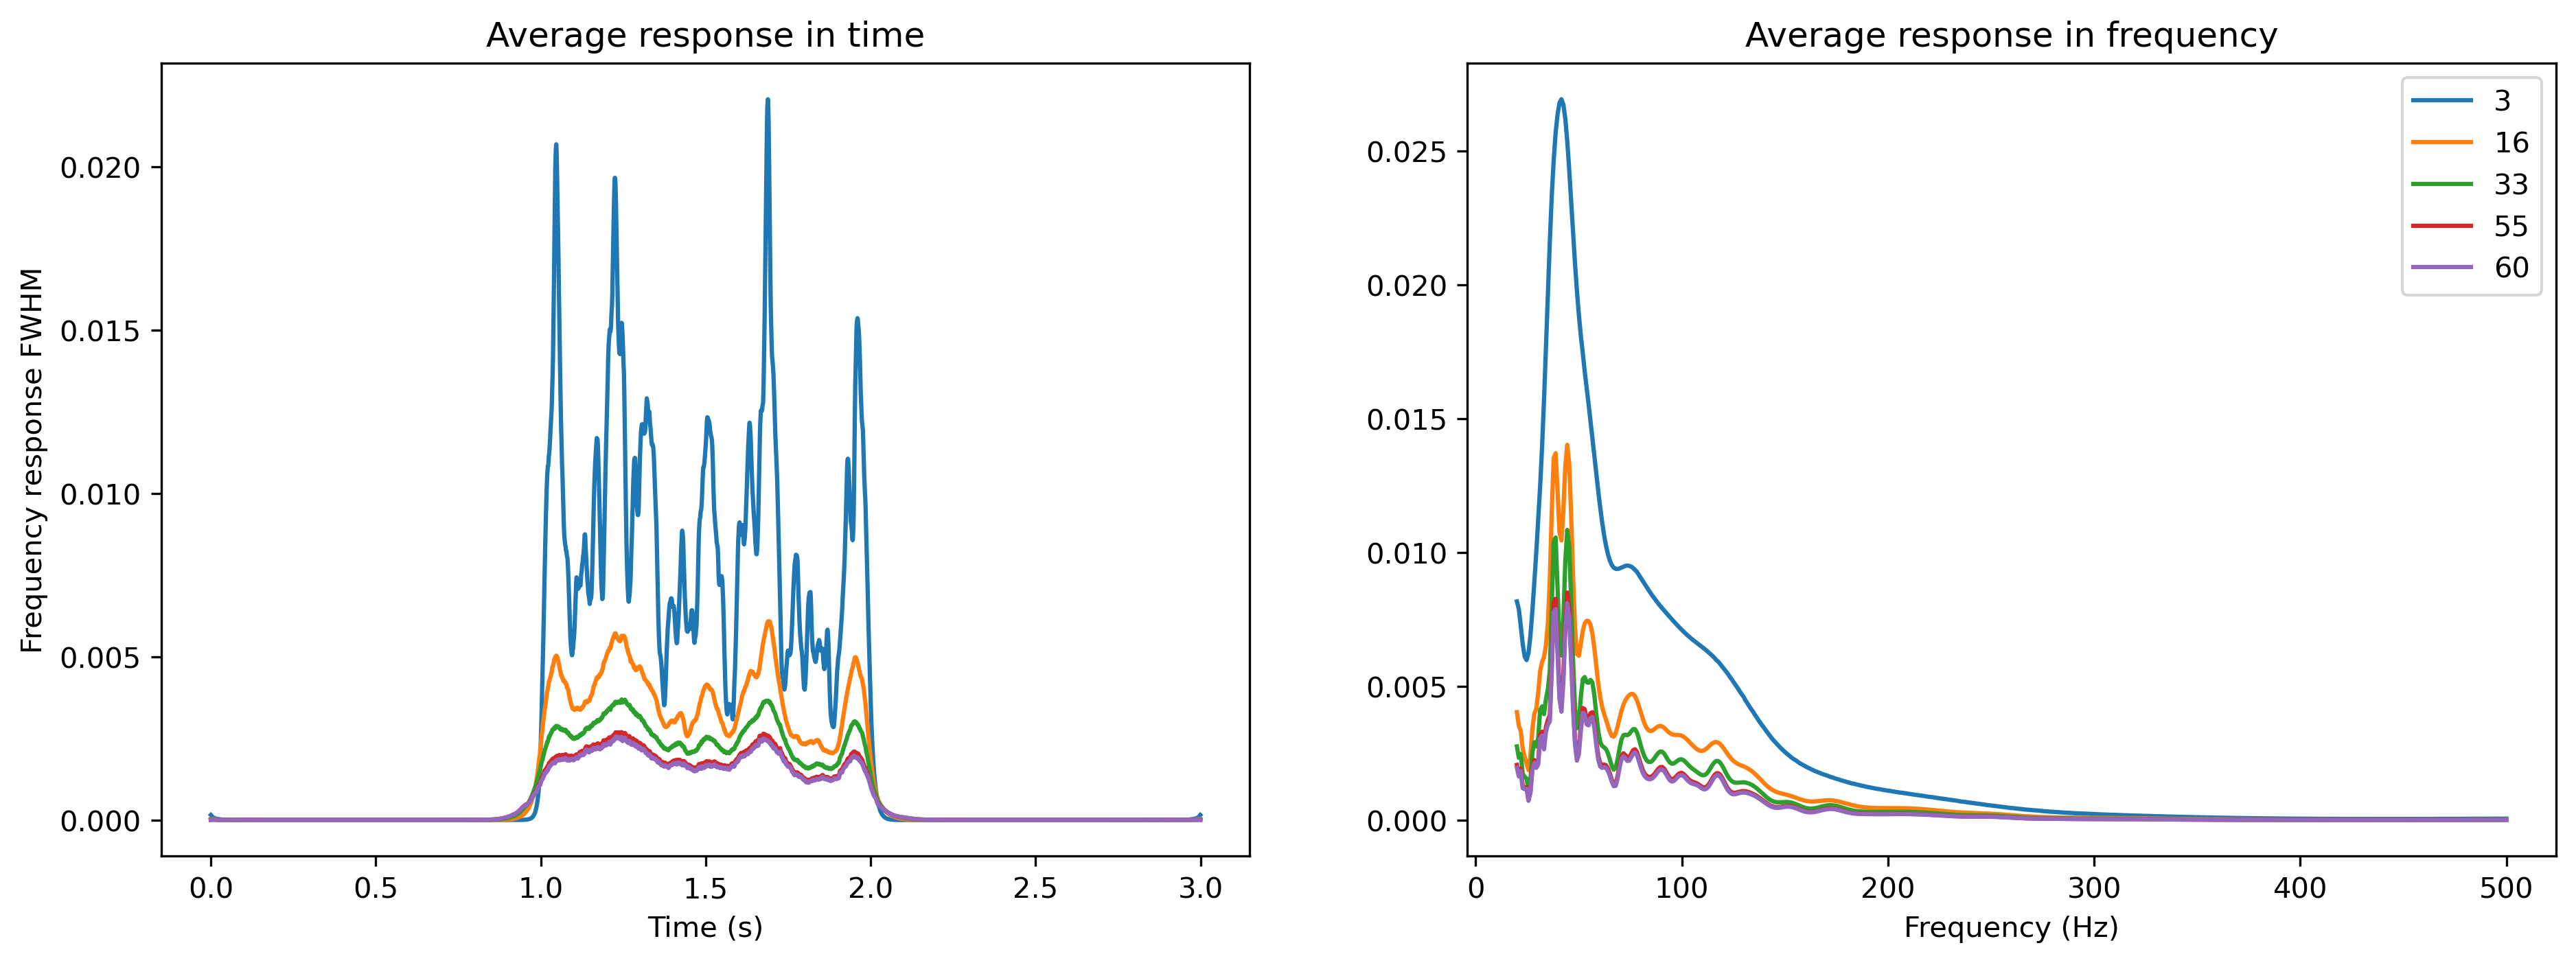

In [139]:
if plot_1:
    fig, ax = plt.subplots(ncols=len(params_wavelet), figsize=(18, 5), dpi=300)
if plot_2:
    # Definir límites de color para que sean iguales en todos los subplots
    fig_2, ax_2 = plt.subplots(ncols=len(params_wavelet), figsize=(18, 5), dpi=300)
    fig_3, ax_3 = plt.subplots(figsize=(10, 6))

mae_wavelet_f = []
std_wavelet_f = []

mae_wavelet_t = []
std_wavelet_t = []

total_time = []
total_freq = []

total_scalogram_wavelet = []
res_wavelet = []

# Iterar sobre los parámetros de wavelet
for i, c in enumerate(params_wavelet):
    wavelet = f"cmor{c}-1.0"
    
    cwtmatr, f, physical_freqs = morlet.wavelet_transform_2(signal,wavelet,freqs,fs)
    cwtmatr = np.abs(cwtmatr[:, :])
    
    if save:
        df = pd.DataFrame(cwtmatr)
    
        # Guardar en un archivo CSV
        filename = os.path.join(new_folder_path, str(SNR) + "dB_wv_" + str(c) + ".csv")
        df.to_csv(filename, index=False, header=False)  # Sin índices ni encabezados
    
    scalogram_2 = jnp.abs(cwtmatr)**2
    scalogram_2 = np.array(scalogram_2)
    
    #if np.any(np.isnan(scalogram_2)) or np.any(np.isinf(scalogram_2)):
    #scalogram_2 = np.nan_to_num(scalogram_2)

    if plot_1:
        pcm = ax[i].pcolormesh(t,f, scalogram_2, shading='gouraud', cmap='jet')
        
        ax[i].set_title(f'c={c}')
        ax[i].set_ylabel('Frecuencia [Hz]')
        ax[i].set_xlabel('Tiempo [s]')
        
        cbar = fig.colorbar(pcm, ax=ax[i], orientation='horizontal')
        cbar.set_label('Power', rotation=0, labelpad=15)  # Etiqueta de la colorbar
    
        ax[i].set_ylim(freqs[0], freqs[-1])  # Ajustar el rango de frecuencias si es necesario
        plt.tight_layout()

    total_scalogram_wavelet.append(scalogram_2)
    instant_mean_freq_total = []

    # Para evitar la división por cero
    # denominador = np.sum(scalogram_2, axis=0)
    # denominador = np.where(denominador == 0, 1e-10, denominador)
    #instant_freq = np.sum(scalogram_2 * f[:, np.newaxis], axis=0) / denominador
    instant_freq = np.sum(scalogram_2 * f[:, np.newaxis], axis=0) / np.sum(scalogram_2, axis=0)
    
    # Quitar los valores nan de la frecuencia instantánea usando interpolación (solo para wavelet y SNR = Inf)
    valid = ~np.isnan(instant_freq)
    t_valid = t[valid]
    signal_valid = instant_freq[valid]
    instant_freq = np.interp(t, t_valid, signal_valid)
    if plot_means:
        plt.figure()
        plt.plot(instant_freq)
        plt.title('Frecuencia instantánea')
    
    sigma = 20  # Desviación estándar del filtro PARA SNR = INF
    y_smooth = gaussian_filter1d(instant_freq, sigma)

    # VALOR MEDIO EN UNA VENTANA DESLIZANTE
    window_size = 50
    window = np.ones(window_size) / window_size  # Ventana normalizada

    # Calcular la media móvil con convolución
    media_movil = np.convolve(y_smooth, window, mode='same')  
    if plot_means:
        plt.figure()
        plt.plot(media_movil, color = 'red')
        plt.title('Media de la señal')
    
    # Derivada de la media para ver el cambio en el valor medio de la señal
    slope_gradient = np.gradient(media_movil, t)
    if plot_means:
        plt.figure()
        plt.plot(slope_gradient, color = 'green')
        plt.title('Gradiente de la media de la señal')
    
    # Coger la porción de la señal del medio    
    time_range = len(slope_gradient)//2
    time_shift = round(burst_duration_1 * 0.7 * fs)
    inicio = time_range-time_shift
    
    first_index = np.argmax(slope_gradient[inicio:time_range]) + inicio
    last_index = np.argmin(slope_gradient[time_range:time_range+time_shift]) + time_range 
    
    t_onset = t[first_index]
    t_offset = t[last_index]
       
    start_idx = np.searchsorted(t, burst_start_1)  # Encuentra el índice de inicio
    end_idx = np.searchsorted(t, burst_start_1 + burst_duration_1)  # Encuentra el índice final

    instant_mean_freq_burst = instant_freq[start_idx:end_idx]

    if plot_2:
        ax_2[i].plot(t, instant_freq)

        ax_2[i].set_xlabel("Time (s)")
        ax_2[i].set_ylabel("Frequency (Hz)")
        #ax_2[i].set_xlim(t[0], t[-1])
        #plt.title("Medias de cada fila en función del tiempo")
        ax_2[i].grid(True)

        ax_3.plot(t, instant_freq, label=f"Mean frequency (Cycles: {c})")
        plt.tight_layout()

    #MAE in frequency
    print(f'Estimated mean frequency: {np.mean(instant_mean_freq_burst)} Hz')
    mae_f, std_f = calculate_mae(instant_mean_freq_burst, MNF_1)
    mae_wavelet_f.append(mae_f)
    std_wavelet_f.append(std_f)
    
    #MAE in time
    print(f'Estimated onset = {t_onset} s, offset = {t_offset} s')
    estimates_combined = t_offset - t_onset
    print(f'Estimated difference: {estimates_combined} s')
    true_values_combined = t_offset_1 - t_onset_1
    print(f'Real difference: {true_values_combined} s')

    mae_t, std_t = calculate_mae(estimates_combined, true_values_combined)
    mae_wavelet_t.append(mae_t)
    std_wavelet_t.append(std_t)

    time = np.arange(scalogram_2.shape[1]) / fs

    total_time.append(time)
    total_freq.append(freqs)
    
    # Visualization
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(t, instant_freq)
    plt.plot(t, y_smooth)
    plt.axvline(t_onset, color='green', linestyle='--', label='t_onset')
    plt.axvline(t_offset, color='red', linestyle='--', label='t_offset')
    plt.xlabel('Time (s)')
    plt.ylabel('Freq (Hz)')
    plt.legend()
    plt.grid()

    plt.subplot(2, 1, 2)
    plt.plot(t, slope_gradient)
    plt.axvline(t_onset, color='green', linestyle='--', label='t_onset')
    plt.axvline(t_offset, color='red', linestyle='--', label='t_offset')
    plt.xlabel('Time (s)')
    plt.ylabel('Freq (Hz)')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Configuración del gráfico
if plot_2:
    ax_3.set_xlabel("Time (s)")
    ax_3.set_ylabel("Frequency (Hz)")
    ax_3.legend()
    ax_3.grid(True)
    ax_3.set_title("Comparación de frecuencias medias instantáneas")

res_wavelet = superlet.compute_avg_response_resolution(total_scalogram_wavelet, total_time, total_freq, params_wavelet)

In [140]:
mae_wavelet_f

[14.97660214546838,
 11.12528858941357,
 10.396692716360736,
 9.775457979169692,
 9.688161672368267]

In [141]:
mae_wavelet_t

[0.021816997720612186,
 0.022793878215565,
 0.026701400195376035,
 0.028655161185281663,
 0.0296320416802347]

There's a tradeoff above; using a low number of cycles results in high temporal resolution, but poor frequency resolution (the activations are "smeared" on the frequency dimension). On the other hand, a high number of cycles results in high frequency resolution, but poor temporal resolution. 

There are fundamental limits to how precise we can be on *both* aspects without making a tradeoff on either (the Gabor limit), but the standard wavelet transform isn't on that optimal boundary. Superlets improve resolution on both (time *and* frequency) by taking the geometric mean of wavelet transforms of different cycle lengths, more tightly approaching the Gabor limit.

## PARÁMETROS SUPERLET: base_cycle, min_order, max_order = [3, 5, 1, 1, 1, 1], [1, 1, 5, 10, 20, 30], [30, 30, 40, 100, 100, 200]

In [142]:
importlib.reload(superlet)

<module 'superlets_package.superlets' from '/Users/neuralrehabilitationgroup/PycharmProjects/Superlets-Marina/superlets_package/superlets.py'>

In [143]:
params_superlet = [[1, 1, 3, 5, 5], [3, 5, 1, 1, 1], [30, 40, 30, 40, 50]]

Estimated mean frequency: 133.24810012381738 Hz
Estimated onset = 0.9837186584174537 s, offset = 2.0065125366330188 s
Estimated difference: 1.0227938782155652 s
Real difference: 1 s


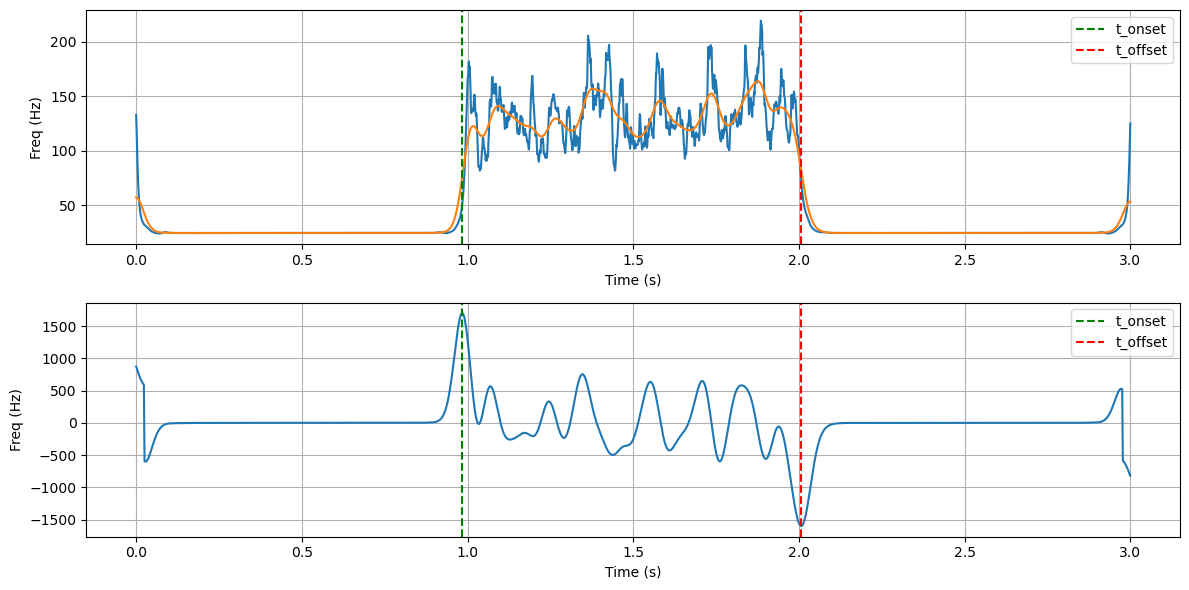

Estimated mean frequency: 132.56541805503446 Hz
Estimated onset = 0.981764897427548 s, offset = 2.008466297622924 s
Estimated difference: 1.026701400195376 s
Real difference: 1 s


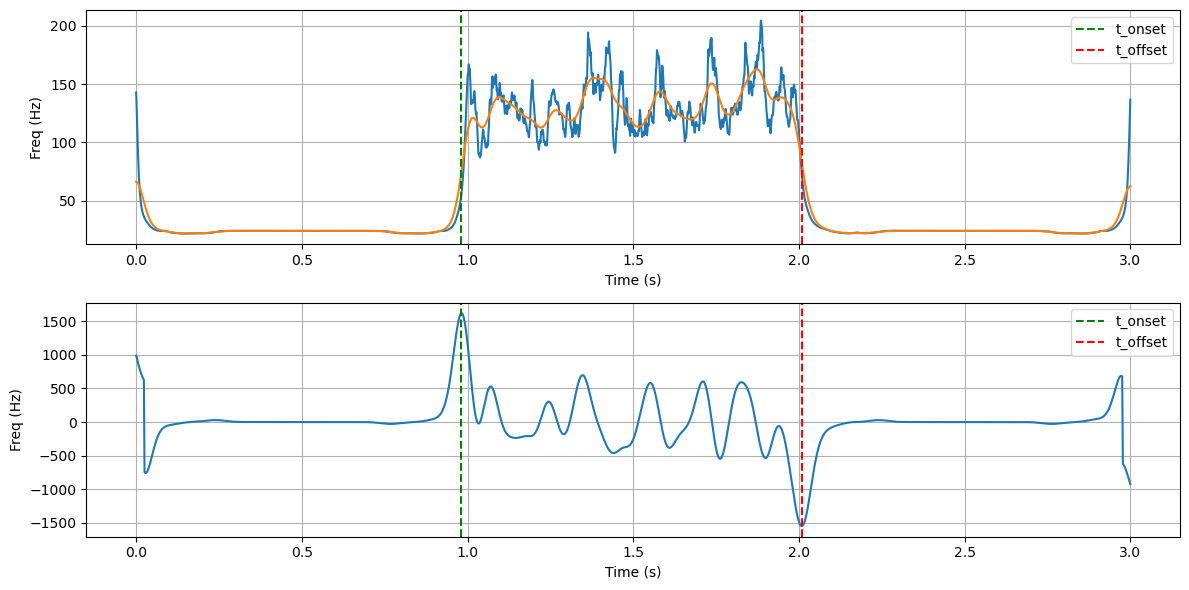

Estimated mean frequency: 117.75338182282312 Hz
Estimated onset = 0.9739498534679257 s, offset = 2.009443178117877 s
Estimated difference: 1.0354933246499511 s
Real difference: 1 s


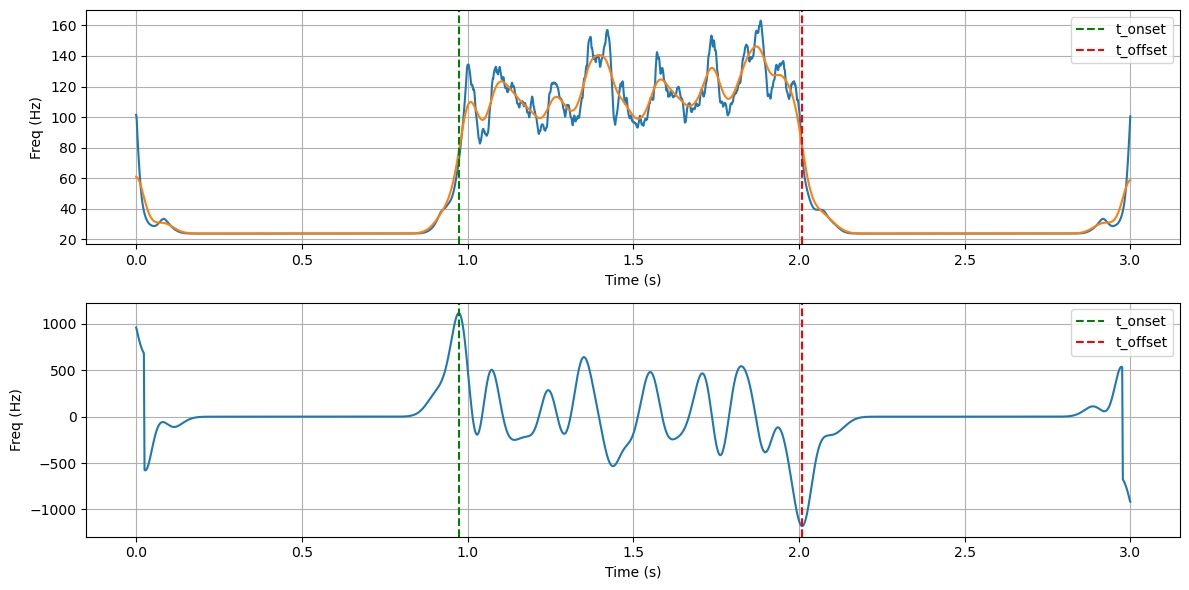

Estimated mean frequency: 112.15251803978565 Hz
Estimated onset = 0.9680885704982091 s, offset = 2.0201888635623577 s
Estimated difference: 1.0521002930641488 s
Real difference: 1 s


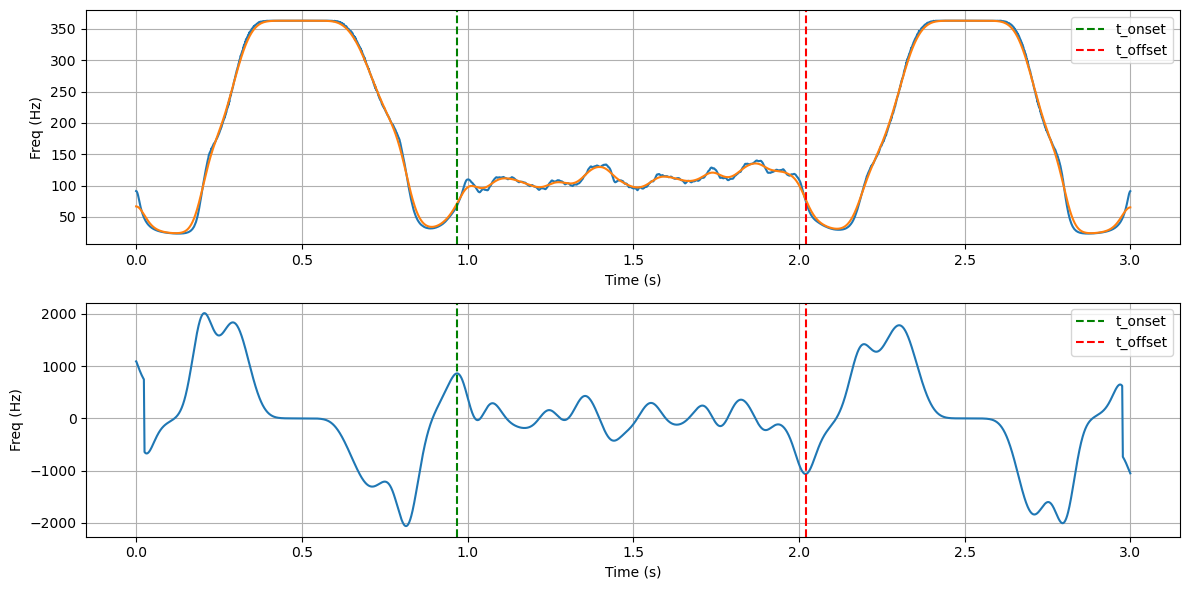

Estimated mean frequency: 109.39777151097758 Hz
Estimated onset = 0.9700423314881146 s, offset = 2.0211657440573103 s
Estimated difference: 1.0511234125691957 s
Real difference: 1 s


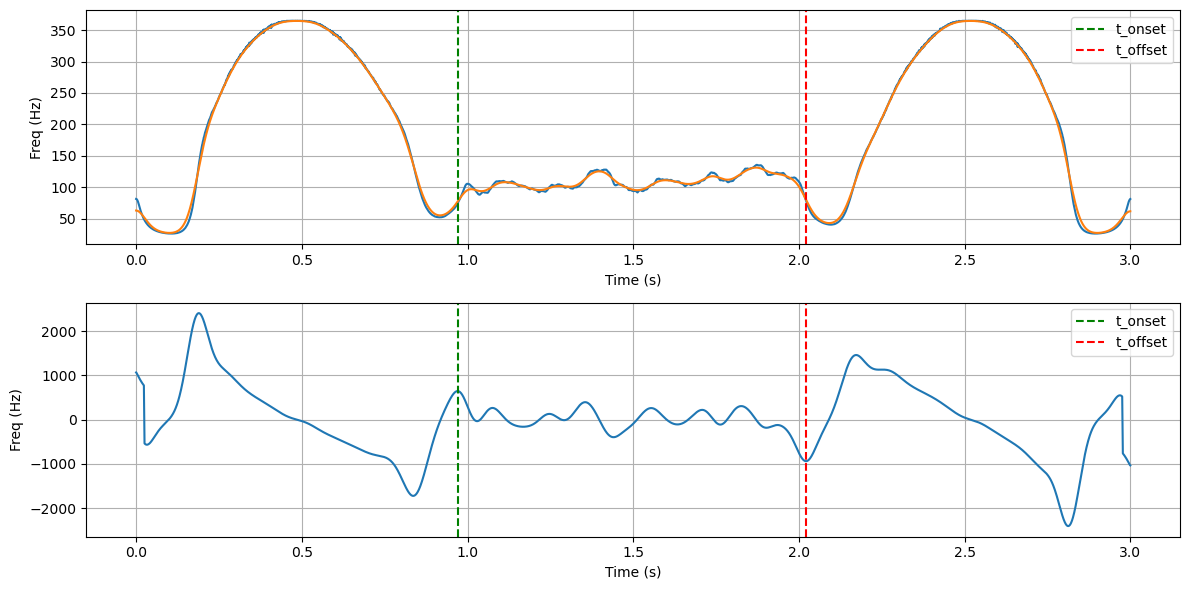

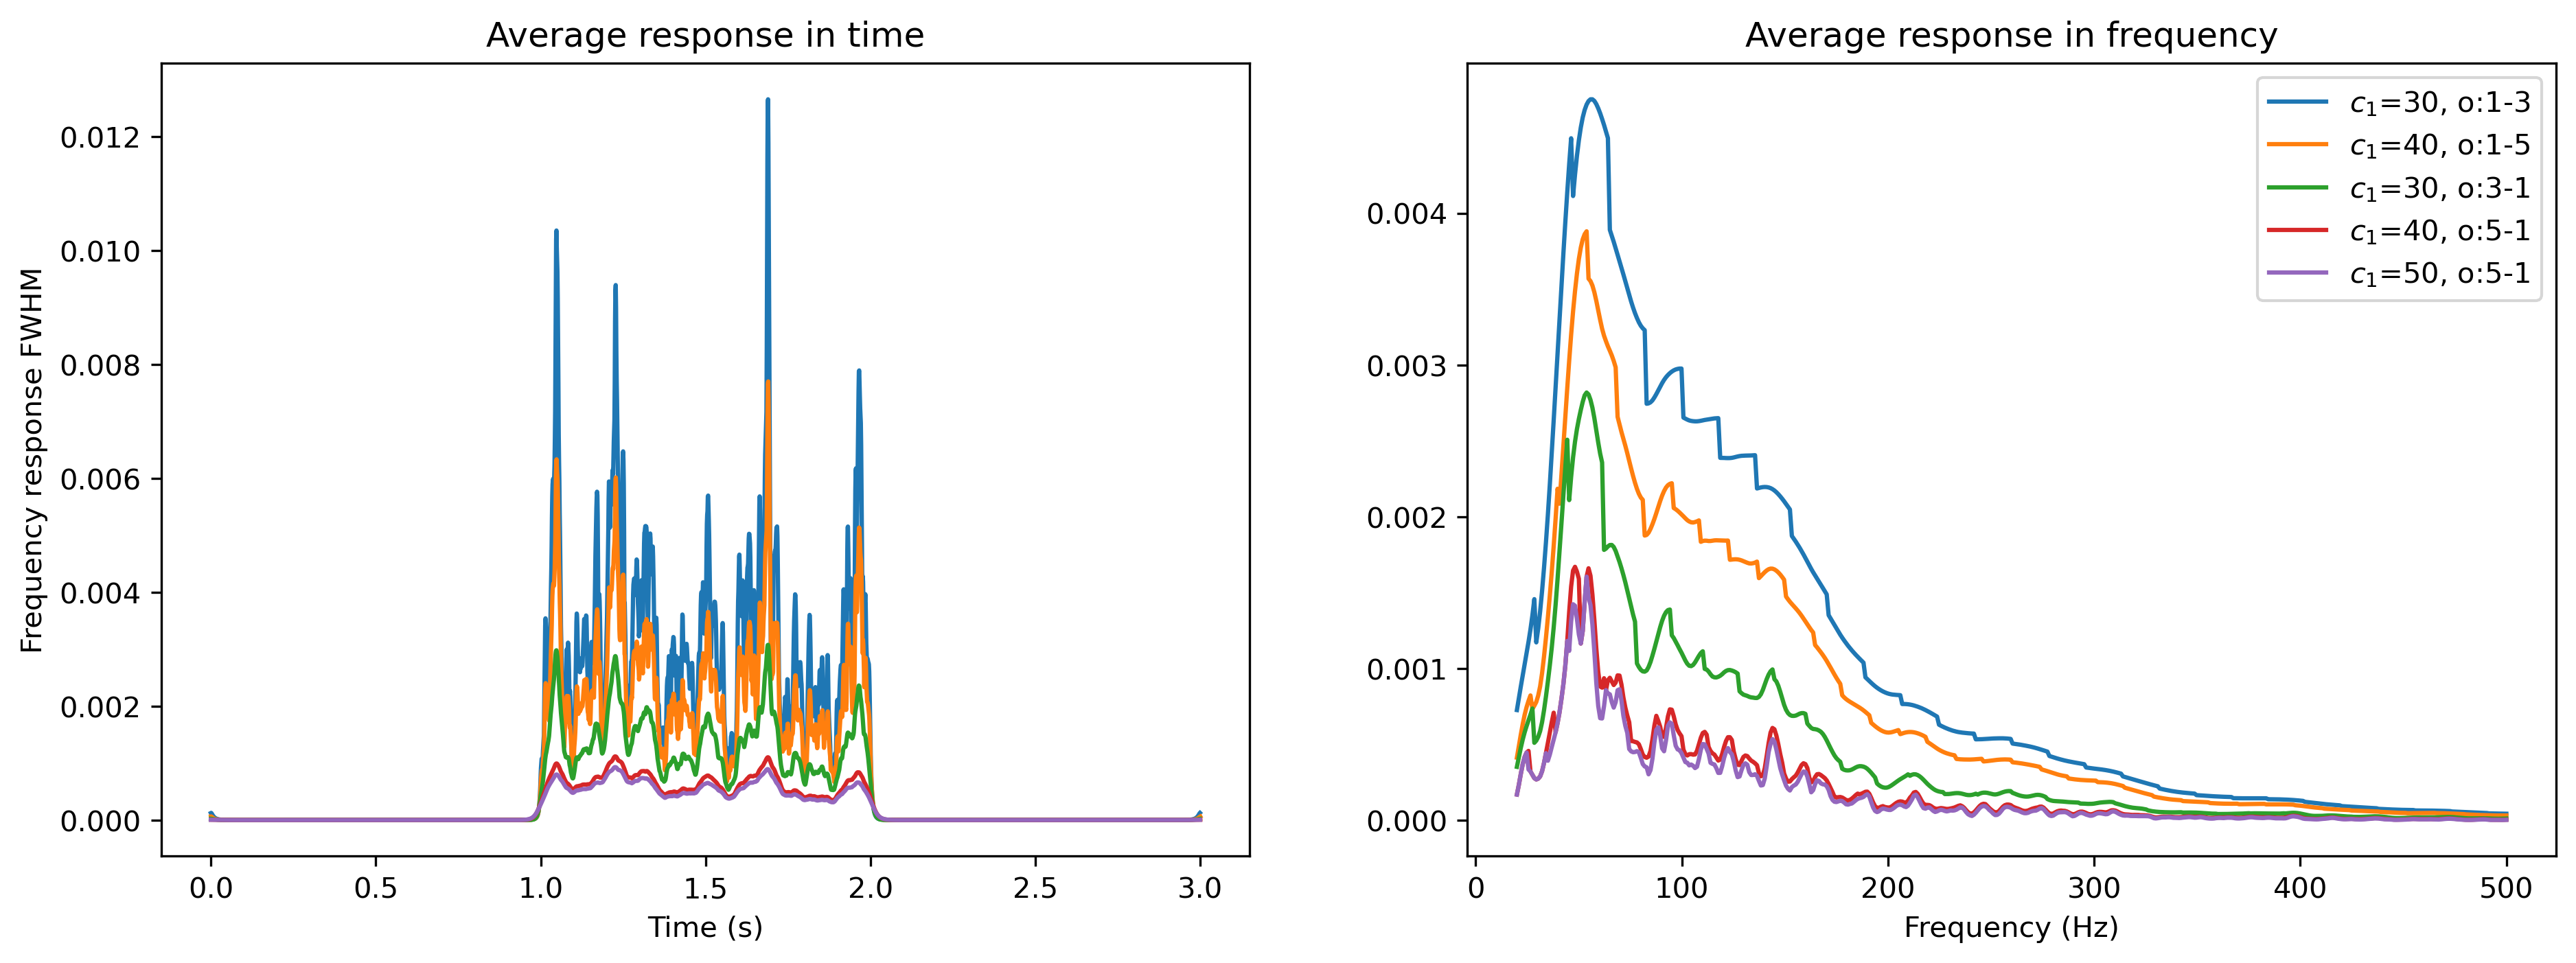

In [144]:
if plot_1:
    fig, ax = plt.subplots(ncols=len(params_superlet[0]), figsize=(15, 5), dpi=300)

if plot_2:
    fig_2, ax_2 = plt.subplots(ncols=len(params_superlet[0]), figsize=(15, 5), dpi=300)
    fig_3, ax_3 = plt.subplots(figsize=(10, 6))

mae_superlet_f = []
std_superlet_f = []

mae_superlet_t = []
std_superlet_t = []

total_time = []
total_freq = []

total_scalogram_superlet = []

for (i, (base_cycle, min_order, max_order)) in enumerate(zip(*params_superlet)):

    wv, scalogram = superlet.adaptive_superlet_transform(signal, freqs, sampling_freq=fs,
                                                         base_cycle=base_cycle, min_order=min_order,
                                                         max_order=max_order, mode="mul")
    
    if plot_1:
        im = ax[i].imshow(jnp.abs(scalogram) ** 2, aspect='auto', cmap="jet", interpolation="none", origin="lower",extent=[0, len(signal) / fs, freqs[0], freqs[-1]])
        ax[i].set_title(f"$c_1$: {base_cycle}, o: {min_order}-{max_order}")
        ax[i].set_xlabel("Time (s)")
        ax[i].set_ylabel("Frequency (Hz)")

        cbar = fig.colorbar(im, ax=ax[i], orientation='horizontal')
        cbar.set_label('Power [a.u]', rotation=0, labelpad=15)  # Etiqueta de la colorbar
        plt.tight_layout()

    scalogram_2 = np.abs(scalogram) ** 2
    
    if save:
        df = pd.DataFrame(scalogram_2)
    
        # Guardar en un archivo CSV
        filename = os.path.join(new_folder_path,str(SNR) + "dB_superlet_" + str(base_cycle) + "-" + str(min_order) + "-" + str(max_order) + ".csv")
        df.to_csv(filename, index=False, header=False)  # Sin índices ni encabezados

    # if np.any(np.isnan(jnp.abs(scalogram) ** 2)) or np.any(np.isinf(jnp.abs(scalogram) ** 2)):
    #     scalogram_2 = np.nan_to_num(jnp.abs(scalogram) ** 2)

    instant_mean_freq_total = []
    total_scalogram_superlet.append(scalogram_2)
    #scalogram_2 = scalogram_2 * freqs[:, np.newaxis]
    
    instant_freq = np.sum(scalogram_2 * freqs[:, np.newaxis], axis=0) / np.sum(scalogram_2, axis=0)
    if plot_means:
        plt.figure()
        plt.plot(instant_freq)
        plt.title('Frecuencia instantánea')
    
    # Mismo SIGMA que para la wavelet
    y_smooth = gaussian_filter1d(instant_freq, sigma)

    # Misms WINDOW_SIZE que para la wavelet
    window = np.ones(window_size) / window_size  # Ventana normalizada

    # Calcular la media móvil con convolución
    media_movil = np.convolve(y_smooth, window, mode='same')  
    if plot_means:
        plt.figure()
        plt.plot(media_movil, color = 'red')
        plt.title('Media de la señal')
    
    # Derivada de la media para ver el cambio en el valor medio de la señal
    slope_gradient = np.gradient(media_movil, t)
    if plot_means:
        plt.figure()
        plt.plot(slope_gradient, color = 'green')
        plt.title('Gradiente de la media de la señal')
    
    # Coger la porción de la señal del medio    
    time_range = len(slope_gradient)//2
    time_shift = round(burst_duration_1 * 0.7 * fs)
    inicio = time_range-time_shift
    
    first_index = np.argmax(slope_gradient[inicio:time_range]) + inicio
    last_index = np.argmin(slope_gradient[time_range:time_range+time_shift]) + time_range 
    
    t_onset = t[first_index]
    t_offset = t[last_index]     

    initial_imnf = instant_freq[:round(burst_start_1 * fs) - offset]
    instant_mean_freq_total.extend(initial_imnf)
    # plt.figure()
    # plt.plot(initial_imnf)

    instant_mean_freq_burst = instant_freq[
                              round(burst_start_1 * fs):round((burst_start_1 + burst_duration_1) * fs)]
    instant_mean_freq_burst = instant_mean_freq_burst[offset_burst:round(len(instant_mean_freq_burst)) - offset_burst]
    instant_mean_freq_total.extend(instant_mean_freq_burst)

    final_imnf = instant_freq[round((burst_start_1 + burst_duration_1) * fs) + offset:]
    instant_mean_freq_total.extend(final_imnf)
    # plt.figure()
    # plt.plot(final_imnf)
    # plt.figure()
    # plt.plot(instant_mean_freq_total)

    if plot_2:
        ax_2[i].plot(t, instant_mean_freq_total,
                     label="Mean frequency (each window of " + str(len(freqs)) + ' samples)')

        ax_2[i].set_xlabel("Time (s)")
        ax_2[i].set_ylabel("Frequency (Hz)")
        #ax_2[i].set_xlim(tiempo[0], tiempo[-1])
        #plt.title("Medias de cada fila en función del tiempo")
        ax_2[i].legend()
        ax_2[i].grid(True)

        ax_3.plot(t, instant_mean_freq_total, label=f"Mean frequency (Cycles: {base_cycle})")

     #MAE in frequency
    print(f'Estimated mean frequency: {np.mean(instant_mean_freq_burst)} Hz')
    mae_f, std_f = calculate_mae(instant_mean_freq_burst, MNF_1)
    mae_superlet_f.append(mae_f)
    std_superlet_f.append(std_f)
    
    #MAE in time
    print(f'Estimated onset = {t_onset} s, offset = {t_offset} s')
    estimates_combined = t_offset - t_onset
    print(f'Estimated difference: {estimates_combined} s')
    true_values_combined = t_offset_1 - t_onset_1
    print(f'Real difference: {true_values_combined} s')

    mae_t, std_t = calculate_mae(estimates_combined, true_values_combined)
    mae_superlet_t.append(mae_t)
    std_superlet_t.append(std_t)

    time = np.arange(scalogram_2.shape[1]) / fs

    total_time.append(time)
    total_freq.append(freqs)

    total_time.append(t)
    total_freq.append(freqs)
    
    # Visualization
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(t, instant_freq)
    plt.plot(t, y_smooth)
    plt.axvline(t_onset, color='green', linestyle='--', label='t_onset')
    plt.axvline(t_offset, color='red', linestyle='--', label='t_offset')
    plt.xlabel('Time (s)')
    plt.ylabel('Freq (Hz)')
    plt.legend()
    plt.grid()

    plt.subplot(2, 1, 2)
    plt.plot(t, slope_gradient)
    plt.axvline(t_onset, color='green', linestyle='--', label='t_onset')
    plt.axvline(t_offset, color='red', linestyle='--', label='t_offset')
    plt.xlabel('Time (s)')
    plt.ylabel('Freq (Hz)')
    plt.legend()
    plt.grid()
    
    plt.tight_layout()
    plt.show() 

if plot_2:
    ax_3.set_xlabel("Time (s)")
    ax_3.set_ylabel("Frequency (Hz)")
    ax_3.legend()
    ax_3.grid(True)
    ax_3.set_title("Comparación de frecuencias medias instantáneas")

res_superlet = superlet.compute_avg_response_resolution(total_scalogram_superlet, total_time, total_freq, [f'$c_1$={c3}, o:{c1}-{c2}' for c1, c2, c3 in zip(*params_superlet)])

In [145]:
    # # 1. Compute the derivative to see the slope
    # # MISMO SIGMA QUE PARA LA WAVELET (= 10)
    # y_smooth = gaussian_filter1d(instant_freq, sigma)
    # 
    # # 1. Calcular la pendiente entre puntos consecutivos (np.diff)
    # #slope_diff = np.diff(instant_freq) / np.diff(t)
    # 
    # # 2. Calcular la pendiente general ajustando una línea recta (np.polyfit)
    # slope_gradient = np.gradient(y_smooth, t)  # Grado 1 para línea recta
    # 
    # first_index = np.argmax(slope_gradient[inicio:time_range]) + inicio
    # last_index = np.argmin(slope_gradient[time_range:time_range+time_shift]) + time_range  # Índice del mínimo más significativo
    # 
    # t_onset = t[first_index]
    # t_offset = t[last_index]   

In [146]:
mae_superlet_f

[25.77576565930388,
 23.842130205069157,
 14.185050432604916,
 9.510538344467586,
 9.43763708439707]

In [147]:
mae_superlet_t

[0.022793878215565222,
 0.026701400195376035,
 0.03549332464995114,
 0.05210029306414876,
 0.051123412569195725]

## STFT PARAMETERS (window = duration/cycles) = 38, 200, 413, 550, 600, 824 ms

In [148]:
importlib.reload(superlet)

<module 'superlets_package.superlets' from '/Users/neuralrehabilitationgroup/PycharmProjects/Superlets-Marina/superlets_package/superlets.py'>

In [149]:
offset_burst = 0
offset = 0

In [150]:
plot_1 = False

94.89275387584863
Onset = 0.9905568218821231, offset = 2.000651253663302
1.0100944317811789
1


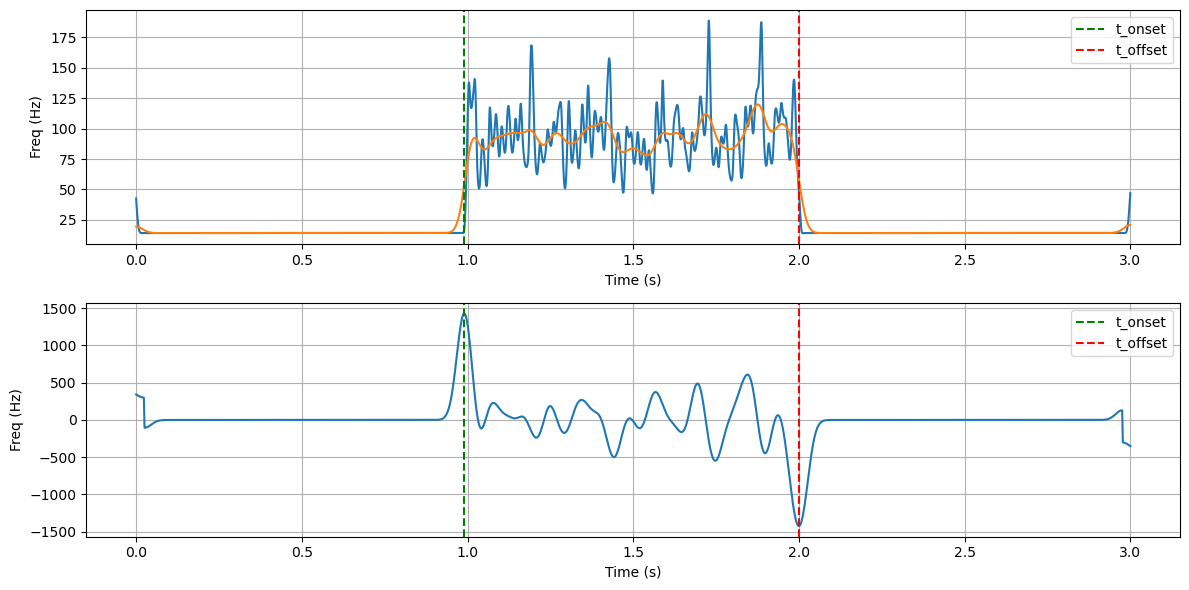

85.23633724842753
Onset = 0.9749267339628785, offset = 2.0211657440573103
1.0462390100944319
1


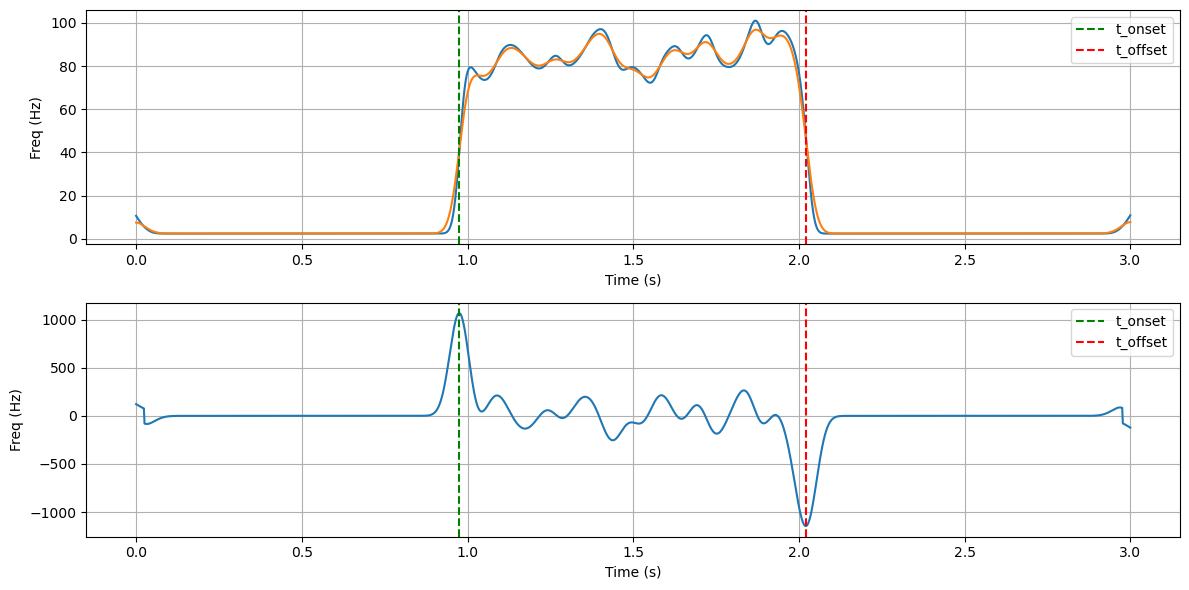

82.47215596019763
Onset = 0.945620319114295, offset = 2.054379680885705
1.1087593617714102
1


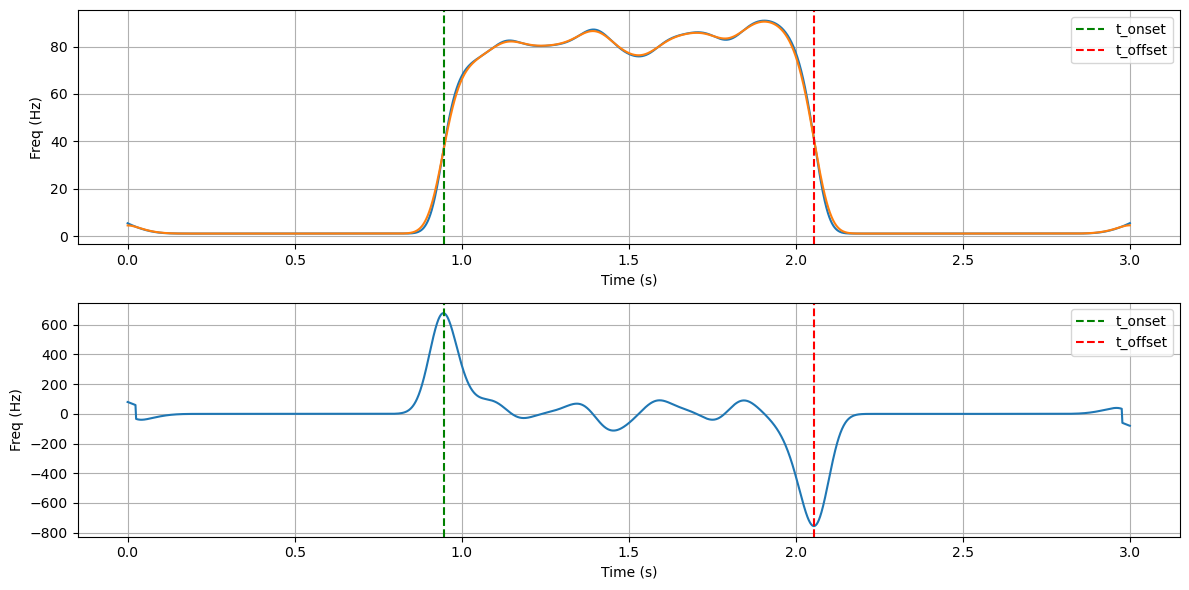

80.97489265347886
Onset = 0.9270595897101921, offset = 2.0748941712797135
1.1478345815695215
1


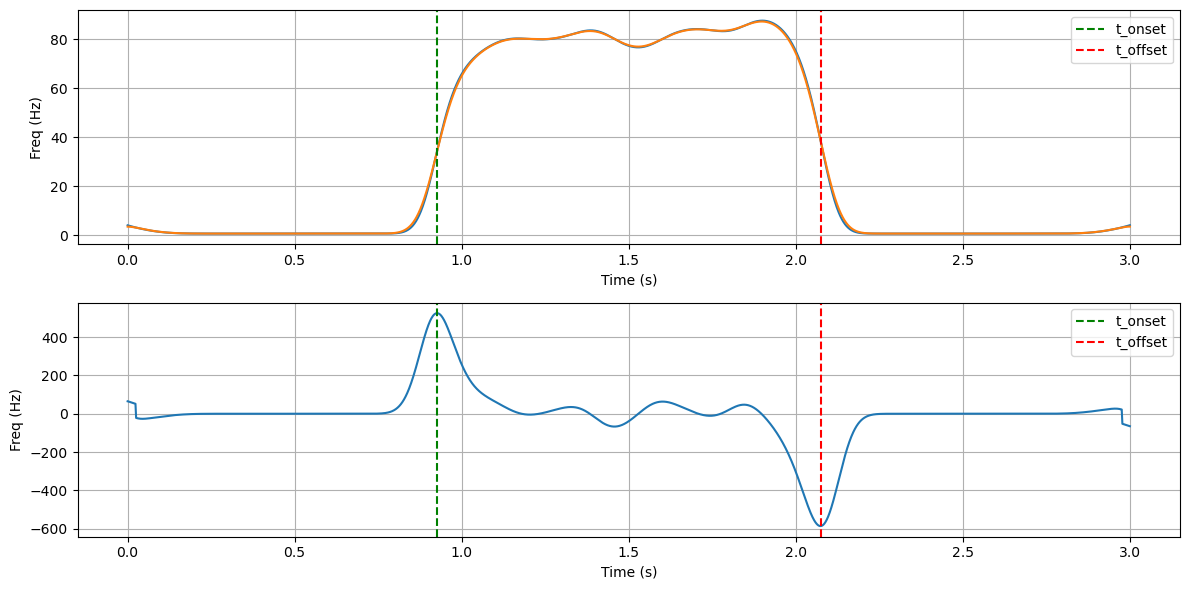

80.4391269254053
Onset = 0.9202214262455226, offset = 2.081732334744383
1.1615109084988604
1


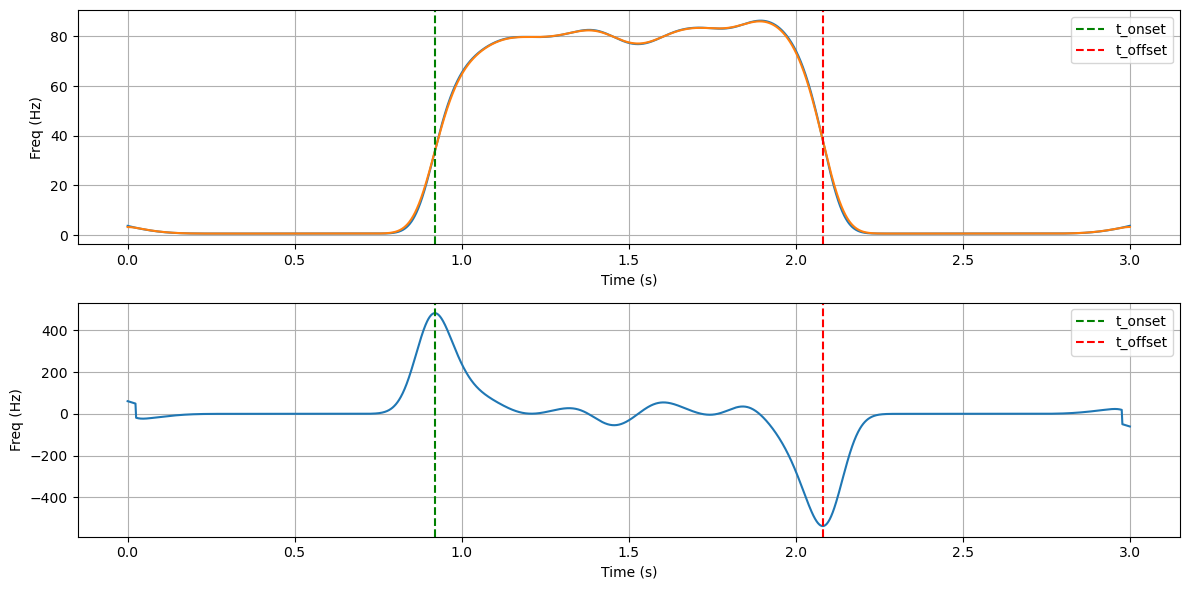

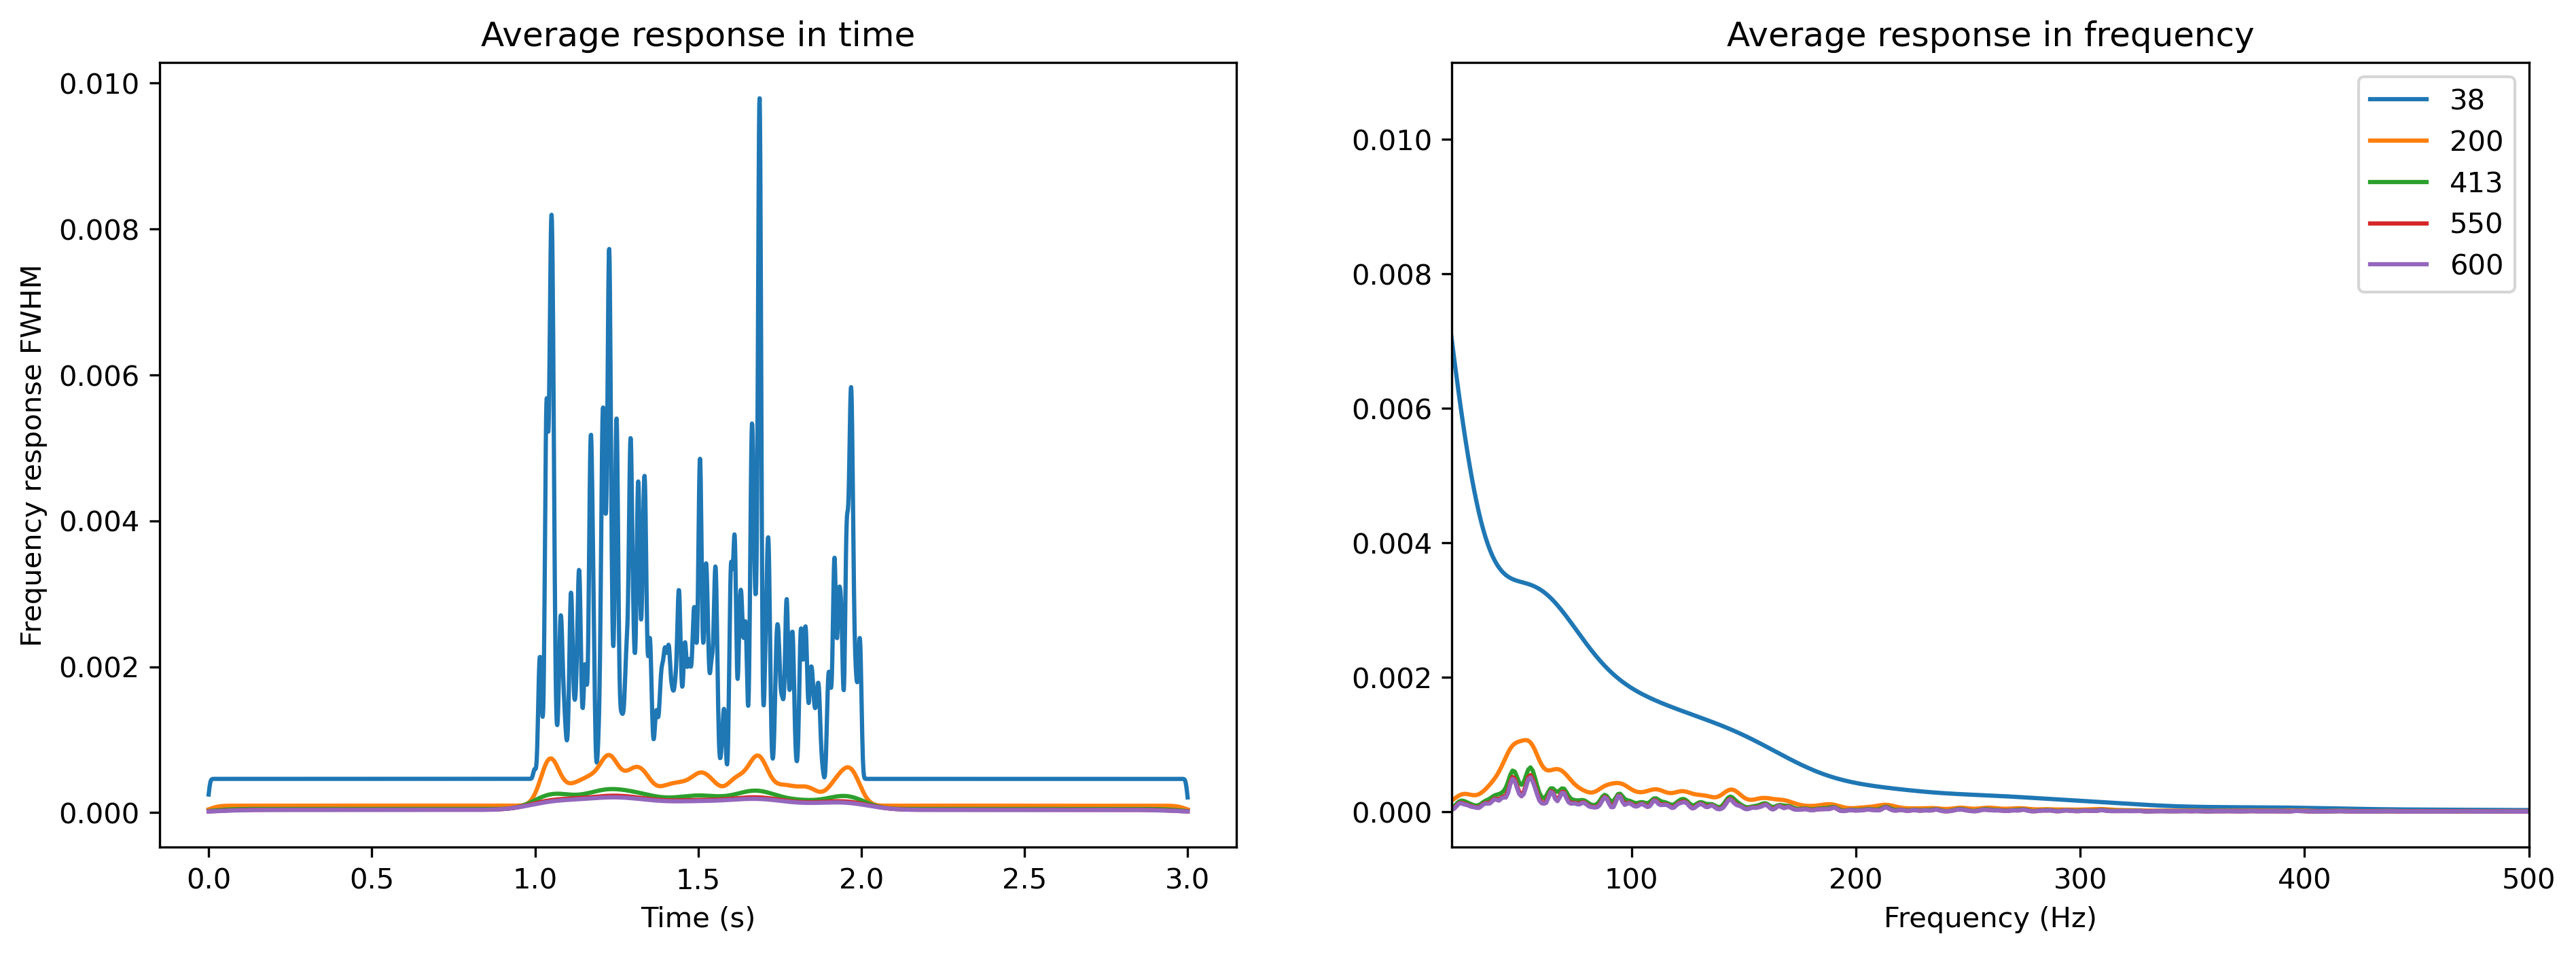

In [151]:
from scipy.signal import stft
from scipy.signal import windows

windows_ms = [38, 200, 413, 550, 600]

if plot_1:
    fig, ax = plt.subplots(ncols=len(windows_ms), figsize=(15, 5), dpi=300)

if plot_2:
    fig_2, ax_2 = plt.subplots(ncols=len(windows_ms), figsize=(15, 5), dpi=300)
    fig_3, ax_3 = plt.subplots(figsize=(10, 6))

mae_stft_f = []
std_stft_f = []

mae_stft_t = []
std_stft_t = []

total_time = []
total_freq = []

res_stft = []
total_scalogram_stft = []

for i, w in enumerate(windows_ms):
    # Calcular la ventana Blackman
    window = windows.blackman(w)
    
    # Hacer que la f de la stft tenga el mismo tamaño que las demás
    nfft = 2 * (len(freqs))

    f, t_stft, Zxx = stft(signal, fs=fs, window='blackman', nperseg=w, noverlap=w-1, nfft=nfft, detrend=False, return_onesided=True, boundary='zeros', padded=True, axis=-1, scaling='spectrum')

    # Calcular la representación de potencia (magnitud al cuadrado)
    Zxx_power = np.abs(Zxx) ** 2
    
    if plot_1:
        pcm = ax[i].pcolormesh(t_stft, f, Zxx_power, shading='gouraud', cmap='jet')
        
        ax[i].set_title(f'W={w * 1000 // fs} ms')
        ax[i].set_ylabel('Frecuencia [Hz]')
        ax[i].set_xlabel('Tiempo [s]')
        
        cbar = fig.colorbar(pcm, ax=ax[i], orientation='horizontal')
        cbar.set_label('Power', rotation=0, labelpad=15)  # Etiqueta de la colorbar
    
        #fig.colorbar(pcm, ax=ax[i], label='Potencia')
        ax[i].set_ylim(freqs[0], freqs[-1])  # Ajustar el rango de frecuencias si es necesario
        plt.tight_layout()
    
    scalogram_2 = Zxx_power
    
    #if np.any(np.isnan(jnp.abs(Zxx)**2)) or np.any(np.isinf(jnp.abs(Zxx)**2)):
    #scalogram_2 = jnp.nan_to_num(jnp.abs(Zxx)**2, nan=0.0, posinf=0.0, neginf=0.0)
    
    if save:
        df = pd.DataFrame(scalogram_2)
    
        # Guardar en un archivo CSV
        filename = os.path.join(new_folder_path, str(SNR) + "dB_stft_" + str(w) + ".csv")
        df.to_csv(filename, index=False, header=False)  # Sin índices ni encabezados
        
    total_scalogram_stft.append(scalogram_2)
 
    instant_mean_freq_total = []   
    
    # Para evitar la división por cero
    denominador = np.sum(scalogram_2, axis=0)
    # denominador = np.where(denominador == 0, 1e-10, denominador)
    instant_freq = np.sum(scalogram_2 * f[:, np.newaxis], axis=0) / denominador
    if plot_means:
        plt.figure()
        plt.plot(instant_freq)
        plt.title('Frecuencia instantánea')
    
    # Probamos misma SIGMA que la wavelet y superlet
    y_smooth = gaussian_filter1d(instant_freq, sigma)
    
    # Mismo WINDOW_SIZE
    window = np.ones(window_size) / window_size  # Ventana normalizada

    # Calcular la media móvil con convolución
    media_movil = np.convolve(y_smooth, window, mode='same')
    if plot_means:
        plt.figure()
        plt.plot(media_movil, color = 'red')
        plt.title('Media de la señal')
    
    slope_gradient = np.gradient(media_movil, t_stft)
    if plot_means:
        plt.figure()
        plt.plot(slope_gradient, color = 'green')
        plt.title('Gradiente de la media de la señal')
    
    # Coger la porción de la señal del medio    
    time_range = len(slope_gradient)//2
    time_shift = round(burst_duration_1 * 1.5 * fs)
    inicio = time_range-time_shift
    
    first_index = np.argmax(slope_gradient[inicio:time_range]) + inicio
    last_index = np.argmin(slope_gradient[time_range:time_range+time_shift]) + time_range 
    
    t_onset = t[first_index]
    t_offset = t[last_index]
    
    start_idx = np.searchsorted(t, burst_start_1)  # Encuentra el índice de inicio
    end_idx = np.searchsorted(t, burst_start_1 + burst_duration_1)  # Encuentra el índice final

    instant_mean_freq_burst = instant_freq[start_idx:end_idx]

    if plot_2:
        ax_2[i].plot(t, instant_freq)

        ax_2[i].set_xlabel("Time (s)")
        ax_2[i].set_ylabel("Frequency (Hz)")
        ax_2[i].grid(True)

        ax_3.plot(t, instant_freq, label=f"Mean frequency (Cycles: {c})")
        plt.tight_layout()

    #MAE in frequency
    print(f'Estimated mean frequency: np.mean(instant_mean_freq_burst) Hz')
    mae_f, std_f = calculate_mae(instant_mean_freq_burst, MNF_1)
    mae_stft_f.append(mae_f)
    std_stft_f.append(std_f)
    
    #MAE in time
    print(f'Estimated onset = {t_onset} s, offset = {t_offset} s')
    estimates_combined = t_offset - t_onset
    print(f'Estimated difference {estimates_combined} s')
    true_values_combined = t_offset_1 - t_onset_1
    print(f' Real difference {true_values_combined}')

    mae_t, std_t = calculate_mae(estimates_combined, true_values_combined)
    mae_stft_t.append(mae_t)
    std_stft_t.append(std_t)
    
    total_time.append(np.linspace(t_stft[0], t_stft[-1], scalogram_2.shape[1]))
    total_freq.append(np.linspace(f[0], f[-1], scalogram_2.shape[0]))
    
    # Visualization
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(t_stft, instant_freq)
    plt.plot(t_stft, y_smooth)
    plt.axvline(t_onset, color='green', linestyle='--', label='t_onset')
    plt.axvline(t_offset, color='red', linestyle='--', label='t_offset')
    plt.xlabel('Time (s)')
    plt.ylabel('Freq (Hz)')
    plt.legend()
    plt.grid()
    
    plt.subplot(2, 1, 2)
    plt.plot(t_stft, slope_gradient)
    plt.axvline(t_onset, color='green', linestyle='--', label='t_onset')
    plt.axvline(t_offset, color='red', linestyle='--', label='t_offset')
    plt.xlabel('Time (s)')
    plt.ylabel('Freq (Hz)')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Configuración del gráfico
if plot_2:
    ax_3.set_xlabel("Time (s)")
    ax_3.set_ylabel("Frequency (Hz)")
    ax_3.legend()
    ax_3.grid(True)
    ax_3.set_title("Comparación de frecuencias medias instantáneas")
        
res_stft = superlet.compute_avg_response_resolution(total_scalogram_stft, total_time, total_freq, windows_ms, stft=[freqs[0],freqs[-1]])

In [152]:
# from scipy.signal import stft
# from scipy.signal import windows
# 
# # Parámetros de la STFT con ventanas de 38 ms, 200 ms, y 413 ms (convertido a muestras)
# # [38, 200, 413, 550, 600, 824]
# #windows_ms = [38, 200, 413, 550, 600, 824]
# windows_ms = [38, 200, 413, 550, 600]
# #windows_samples = [int((w / 1000) * fs) for w in windows_ms]  # Convertir a muestras
# 
# if plot_1:
#     fig, ax = plt.subplots(ncols=len(windows_ms), figsize=(15, 5), dpi=300)
# 
# if plot_2:
#     fig_2, ax_2 = plt.subplots(ncols=len(windows_ms), figsize=(15, 5), dpi=300)
#     fig_3, ax_3 = plt.subplots(figsize=(10, 6))
# 
# mae_stft_f = []
# std_stft_f = []
# 
# mae_stft_t = []
# std_stft_t = []
# 
# total_time = []
# total_freq = []
# 
# res_stft = []
# total_scalogram_stft = []
# 
# for i, w in enumerate(windows_ms):
#     # Calcular la ventana Blackman
#     window = windows.blackman(w)
#     
#     # Hacer que la f de la stft tenga el mismo tamaño que las demás
#     nfft = 2 * (len(freqs))
#     # Dimensión de la frecuencia = nfft/2 + 1
#     # Dimesión del tiempo = [(N - noverlap)/(nperseg-noverlap)] + 1 = 
#     
#     # Realizar la STFT con la ventana Blackman y superposición del 50%
#     #f, t, Zxx = stft(signal, fs, window=window, nfft=nfft, nperseg=w, noverlap=w//2, padded=True, scaling='psd')
#     f, t_stft, Zxx = stft(signal, fs=fs, window='blackman', nperseg=w, noverlap=w-1, nfft=nfft, detrend=False, return_onesided=True, boundary='zeros', padded=True, axis=-1, scaling='spectrum')
#     
#     # ax[i].pcolormesh(t, f, np.abs(Zxx), shading='gouraud', cmap='jet')
#     
#     # Calcular la representación de potencia (magnitud al cuadrado)
#     Zxx_power = np.abs(Zxx) ** 2
#     
#     # Graficar la representación de potencia
#     #plt.figure(figsize=(10, 6))
#     
#     if plot_1:
#         pcm = ax[i].pcolormesh(t_stft, f, Zxx_power, shading='gouraud', cmap='jet')
#         
#         ax[i].set_title(f'W={w * 1000 // fs} ms')
#         ax[i].set_ylabel('Frecuencia [Hz]')
#         ax[i].set_xlabel('Tiempo [s]')
#         
#         cbar = fig.colorbar(pcm, ax=ax[i], orientation='horizontal')
#         cbar.set_label('Power', rotation=0, labelpad=15)  # Etiqueta de la colorbar
#     
#         #fig.colorbar(pcm, ax=ax[i], label='Potencia')
#         ax[i].set_ylim(freqs[0], freqs[-1])  # Ajustar el rango de frecuencias si es necesario
#         plt.tight_layout()
#     
#     scalogram_2 = Zxx_power
#     
#     #if np.any(np.isnan(jnp.abs(Zxx)**2)) or np.any(np.isinf(jnp.abs(Zxx)**2)):
#     #scalogram_2 = jnp.nan_to_num(jnp.abs(Zxx)**2, nan=0.0, posinf=0.0, neginf=0.0)
#     
#     if save:
#         df = pd.DataFrame(scalogram_2)
#     
#         # Guardar en un archivo CSV
#         filename = os.path.join(new_folder_path, str(SNR) + "dB_stft_" + str(w) + ".csv")
#         df.to_csv(filename, index=False, header=False)  # Sin índices ni encabezados
#         
#     total_scalogram_stft.append(scalogram_2)
#  
#     instant_mean_freq_total = []   
#     
#     # Para evitar la división por cero
#     denominador = np.sum(scalogram_2, axis=0)
#     # denominador = np.where(denominador == 0, 1e-10, denominador)
#     instant_freq = np.sum(scalogram_2 * f[:, np.newaxis], axis=0) / denominador
#     
#     start_idx = np.searchsorted(t, burst_start_1)  # Encuentra el índice de inicio
#     end_idx = np.searchsorted(t, burst_start_1 + burst_duration_1)  # Encuentra el índice final
# #
#     instant_mean_freq_burst = instant_freq[start_idx:end_idx]
# 
#     
#     # # Segmento inicial antes del burst
#     # initial_imnf = instant_freq[:max(0, start_index - offset)]  # Asegurar que no haya índices negativos
#     # instant_mean_freq_total.extend(initial_imnf)
#     # plt.figure()
#     # plt.plot(initial_imnf)
#     # 
#     # # Segmento durante el burst
#     # instant_mean_freq_burst = instant_freq[start_index:end_index_burst]
#     # instant_mean_freq_burst = instant_mean_freq_burst[offset_burst:len(instant_mean_freq_burst)-offset_burst]  # Aplicar offset dentro del burst
#     # instant_mean_freq_total.extend(instant_mean_freq_burst)
#     # plt.figure()
#     # plt.plot(instant_mean_freq_burst)
#     # 
#     # # Segmento final después del burst
#     # final_start_index = end_index_burst + offset
#     # final_imnf = instant_freq[final_start_index:]
#     # instant_mean_freq_total.extend(final_imnf)
#     
#     
#     # OBTAIN THE POINTS IN TIME WHERE BURST IS DETECTED
#     sigma = 10 #Diferente en STFT porque tiene menos resolución
#     y_smooth = gaussian_filter1d(instant_freq, sigma)
# 
#     # Calcular pendientes locales usando np.gradient sobre la señal suavizada
#     slope_gradient = np.gradient(y_smooth, t_stft)
#     #slope_gradient = np.gradient(instant_freq, t)
#     
#     time_range = len(slope_gradient)//2
#     time_shift = round(burst_duration_1 * 0.8 * fs)
#     inicio = time_range-time_shift
#     
#     first_index = np.argmax(slope_gradient[inicio:time_range]) + inicio
#     last_index = np.argmin(slope_gradient[time_range:time_range+time_shift]) + time_range  # Índice del mínimo más significativo
#     
#     t_onset = t_stft[first_index]
#     t_offset = t_stft[last_index]
#     
#     # Visualization
#     plt.figure(figsize=(12, 6))
# 
#     plt.subplot(2, 1, 1)
#     plt.plot(t_stft, instant_freq)
#     plt.plot(t_stft, y_smooth)
#     plt.axvline(t_onset, color='green', linestyle='--', label='t_onset')
#     plt.axvline(t_offset, color='red', linestyle='--', label='t_offset')
#     plt.xlabel('Time (s)')
#     plt.ylabel('Freq (Hz)')
#     plt.legend()
#     plt.grid()
# 
#     # Slopes and t_onset and t_offset
#     plt.subplot(2, 1, 2)
#     plt.plot(t_stft, slope_gradient, 'g-', label='Local slope (np.gradient)')
#     plt.axvline(t_onset, color='green', linestyle='--', label='Start of the first positive slope')
#     plt.axvline(t_offset, color='red', linestyle='--', label='End of the final negative slope')
#     plt.xlabel('Time (s)')
#     plt.ylabel('Slope')
#     plt.legend()
#     plt.grid()
# 
#     plt.tight_layout()
#     
#     # 
#     # print(t >= (burst_start_1 + burst_duration_1))
#     # instant_mean_freq_burst = instant_mean_freq[np.where(t >= burst_start_1)[0][0]:np.where(t >= (burst_start_1 + burst_duration_1))[0][0]]
#     # instant_mean_freq_burst = instant_mean_freq_burst[offset_burst:len(instant_mean_freq_burst)-offset_burst]
#     # instant_mean_freq_total.extend(instant_mean_freq_burst)
#     # # plt.figure()
#     # # plt.plot(instant_mean_freq_burst)
#     #  
#     # final_imnf = instant_mean_freq[np.where(t >= burst_start_1 + burst_duration_1)[0][0] + offset:]
#     # instant_mean_freq_total.extend(final_imnf)
#     # plt.figure()
#     # plt.plot(final_imnf)
# 
#     if plot_2:
#         ax_2[i].plot(t_stft, instant_mean_freq_total, label="Mean frequency (each window of " + str(len(freqs)) + ' samples)')
#         
#         ax_2[i].set_xlabel("Time (s)")
#         ax_2[i].set_ylabel("Frequency (Hz)")
#         #ax_2[i].set_xlim(tiempo[0], tiempo[-1])
#         #plt.title("Medias de cada fila en función del tiempo")
#         ax_2[i].legend()
#         ax_2[i].grid(True)
#         
#         ax_3.plot(t_stft, instant_mean_freq_total, label=f"Mean frequency (Cycles: {w})")
#     
#     #MAE in frequency
#     print(np.mean(instant_mean_freq_burst))
#     mae_f, std_f = calculate_mae(instant_mean_freq_burst, MNF_1)
#     mae_stft_f.append(mae_f)
#     std_stft_f.append(std_f)
#     
#     #MAE in time
#     print(f'Onset = {t_onset}, offset = {t_offset}')
#     estimates_combined = t_offset - t_onset
#     print(estimates_combined)
#     true_values_combined = t_offset_1 - t_onset_1
#     print(true_values_combined)
# 
#     mae_t, std_t = calculate_mae(estimates_combined, true_values_combined)
#     mae_stft_t.append(mae_t)
#     std_stft_t.append(std_t)
#     
#     total_time.append(np.linspace(t_stft[0], t_stft[-1], scalogram_2.shape[1]))
#     total_freq.append(np.linspace(f[0], f[-1], scalogram_2.shape[0]))
# 
# # Configuración del gráfico
# if plot_2:
#     ax_3.set_xlabel("Time (s)")
#     ax_3.set_ylabel("Frequency (Hz)")
#     ax_3.legend()
#     ax_3.grid(True)
#     ax_3.set_title("Comparación de frecuencias medias instantáneas")
#         
# res_stft = superlet.compute_avg_response_resolution(total_scalogram_stft, total_time, total_freq, windows_ms, stft=[freqs[0],freqs[-1]])

In [153]:
mae_stft_f

[23.861738283896266,
 25.740517227095197,
 28.504698515325103,
 30.00196182204388,
 30.53772755011741]

In [154]:
mae_stft_t

[0.010094431781178859,
 0.046239010094431876,
 0.10875936177141021,
 0.14783458156952145,
 0.1615109084988604]

### Plot comparison of the same SNR

# MAE IN FREQUENCY

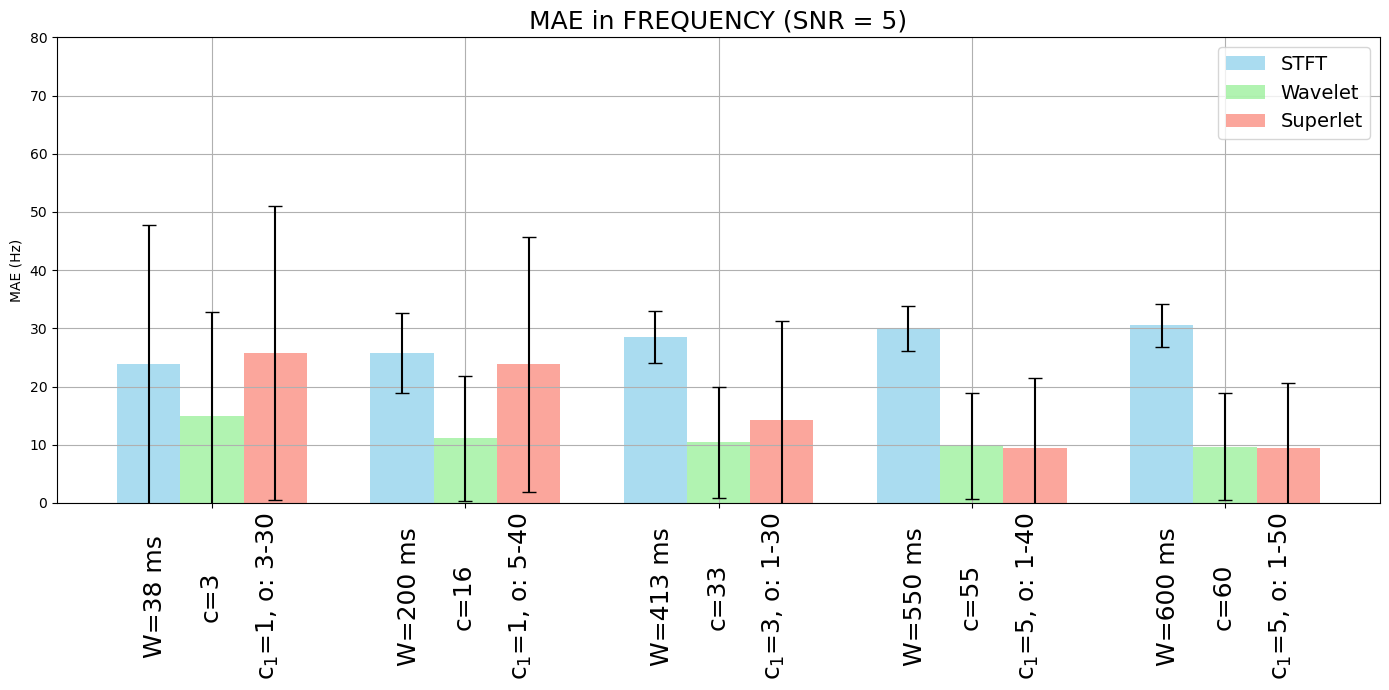

In [155]:
params_stft = windows_ms

# Número de condiciones
num_conditions = len(mae_wavelet_f)
x = np.arange(num_conditions)  # Posiciones para cada grupo de barras
bar_width = 0.25  # Ancho de las barras

# Crear el gráfico de barras
plt.figure(figsize=(14, 7))

# Graficar cada técnica con sus valores y barras de error
plt.bar(x - bar_width, mae_stft_f, width=bar_width, yerr=std_stft_f, capsize=5, label='STFT', color='skyblue', alpha=0.7)
plt.bar(x, mae_wavelet_f, width=bar_width, yerr=std_wavelet_f, capsize=5, label='Wavelet', color='lightgreen', alpha=0.7)
plt.bar(x + bar_width, mae_superlet_f, width=bar_width, yerr=std_superlet_f, capsize=5, label='Superlet', color='salmon', alpha=0.7)

# Configuración de etiquetas en el eje x con los parámetros específicos
labels = [
    f"W={p_stft} ms\n\nc={p_w}\n\nc$_1$={p_s[0]}, o: {p_s[1]}-{p_s[2]}"
    for p_w, p_s, p_stft in zip(params_wavelet, zip(*params_superlet), params_stft)
]

plt.xticks(x, labels, rotation=90, ha='center', fontsize=18)
#plt.xlabel('Condiciones y Parámetros')
plt.yticks(np.arange(0, 81, 10))

plt.ylabel('MAE (Hz)')
plt.title('MAE in FREQUENCY (SNR = ' + str(SNR) +')', fontsize=18)
plt.ylim(0,80)
plt.legend(fontsize=14)
plt.grid(True)

# Ajustar el layout para mejorar visualización de etiquetas
plt.tight_layout()

# Mostrar el gráfico
plt.show()

# MAE IN TIME

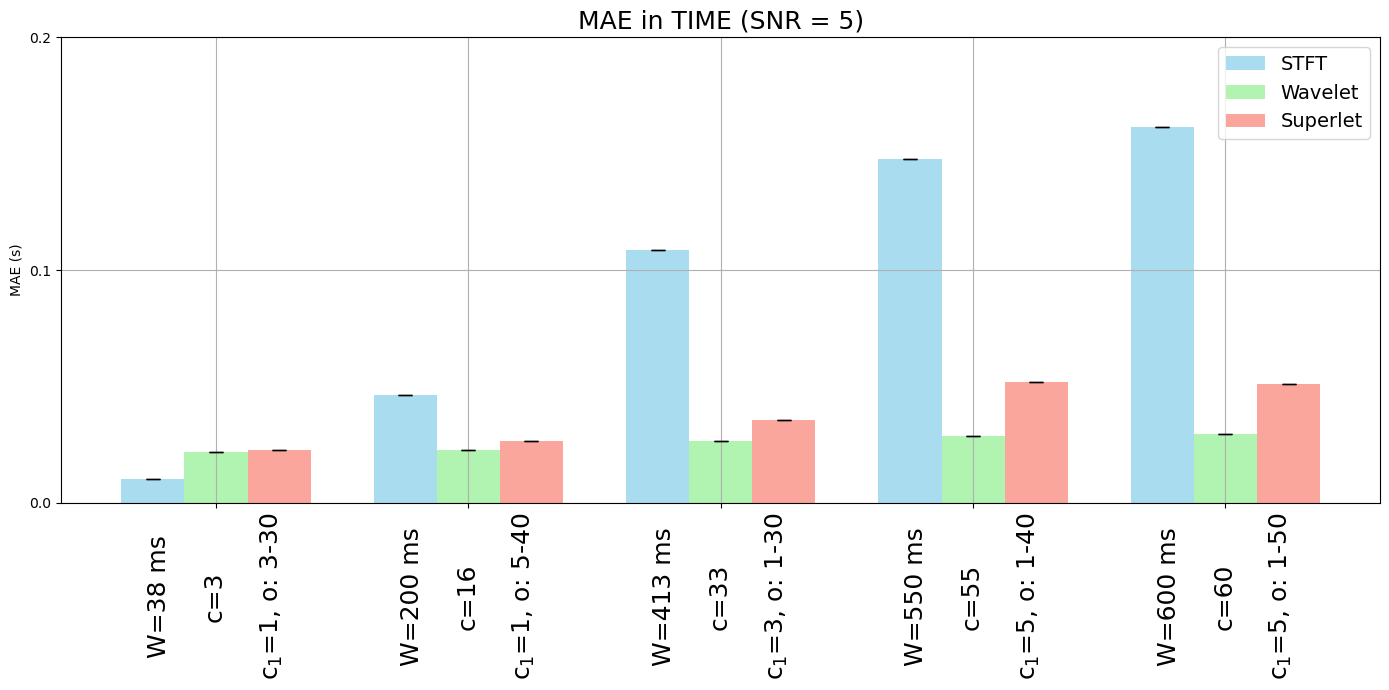

In [156]:
params_stft = windows_ms

# Número de condiciones
num_conditions = len(mae_wavelet_t)
x = np.arange(num_conditions)  # Posiciones para cada grupo de barras
bar_width = 0.25  # Ancho de las barras

# Crear el gráfico de barras
plt.figure(figsize=(14, 7))

# Graficar cada técnica con sus valores y barras de error
plt.bar(x - bar_width, mae_stft_t, width=bar_width, yerr=std_stft_t, capsize=5, label='STFT', color='skyblue', alpha=0.7)
plt.bar(x, mae_wavelet_t, width=bar_width, yerr=std_wavelet_t, capsize=5, label='Wavelet', color='lightgreen', alpha=0.7)
plt.bar(x + bar_width, mae_superlet_t, width=bar_width, yerr=std_superlet_t, capsize=5, label='Superlet', color='salmon', alpha=0.7)

# Configuración de etiquetas en el eje x con los parámetros específicos
labels = [
    f"W={p_stft} ms\n\nc={p_w}\n\nc$_1$={p_s[0]}, o: {p_s[1]}-{p_s[2]}"
    for p_w, p_s, p_stft in zip(params_wavelet, zip(*params_superlet), params_stft)
]

plt.xticks(x, labels, rotation=90, ha='center', fontsize=18)
#plt.xlabel('Condiciones y Parámetros')
plt.yticks(np.arange(0, 0.3, 0.1))

plt.ylabel('MAE (s)')
plt.title('MAE in TIME (SNR = ' + str(SNR) +')', fontsize=18)
plt.ylim(0,0.2)
plt.legend(fontsize=14)
plt.grid(True)

# Ajustar el layout para mejorar visualización de etiquetas
plt.tight_layout()

# Mostrar el gráfico
plt.show()

# COMPUTE RESOLUTION

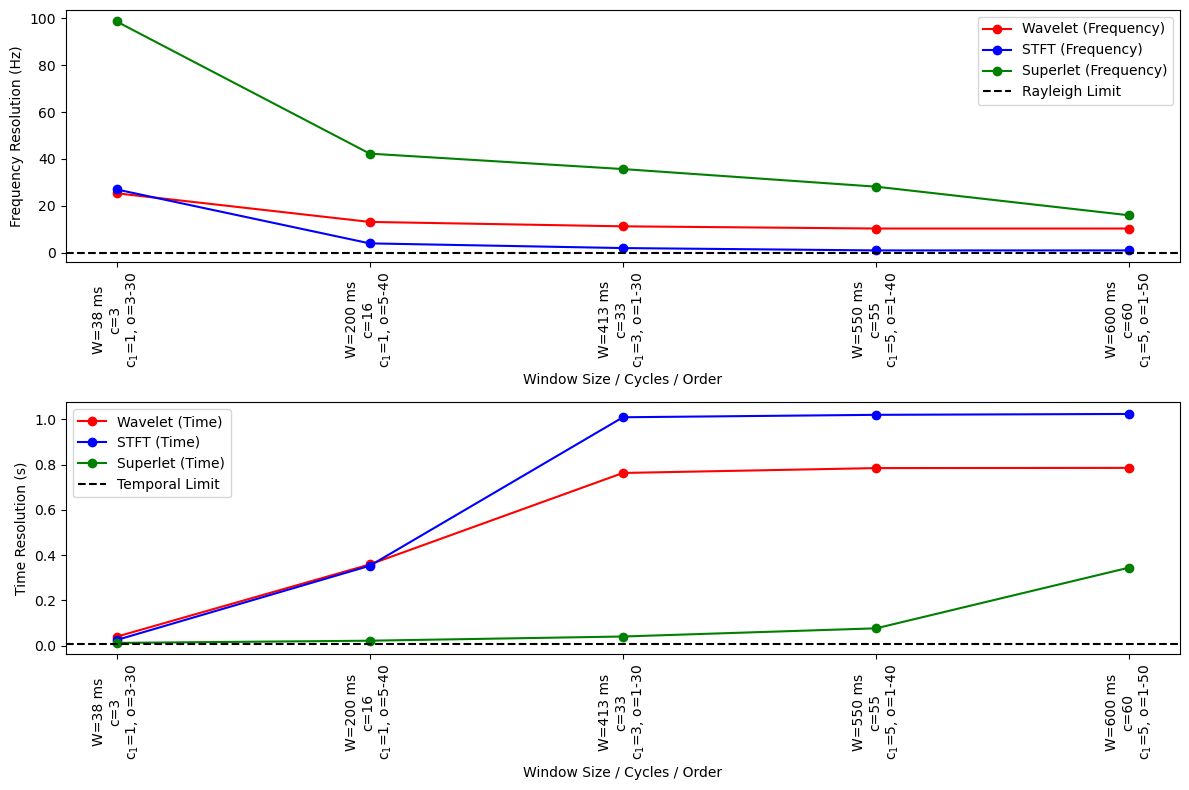

In [157]:
rayleigh_limit = 1 / (4 * np.pi)

# Etiquetas para los grupos de parámetros con salto de línea adicional
labels = [
    f"W={p_stft} ms\nc={p_wavelet}\nc$_1$={p_superlet[0]}, o={p_superlet[1]}-{p_superlet[2]}"
    for p_wavelet, p_superlet, p_stft in zip(params_wavelet, zip(*params_superlet), params_stft)
]

x = np.arange(1,len(params_wavelet)+1)

plt.figure(figsize=(12, 8))

# Primer gráfico (Frecuencia)
plt.subplot(2, 1, 1)
plt.plot(x, [r[1] for r in res_wavelet], 'ro-', label="Wavelet (Frequency)")
plt.plot(x, [r[1] for r in res_stft], 'bo-', label="STFT (Frequency)")
plt.plot(x, [r[1] for r in res_superlet], 'go-', label="Superlet (Frequency)")
plt.axhline(rayleigh_limit, color='k', linestyle='--', label="Rayleigh Limit")
plt.xlabel("Window Size / Cycles / Order")
plt.ylabel("Frequency Resolution (Hz)")
plt.legend()

# Segundo gráfico (Tiempo)
plt.subplot(2, 1, 2)
plt.plot(x, [r[0] for r in res_wavelet], 'ro-', label="Wavelet (Time)")
plt.plot(x, [r[0] for r in res_stft], 'bo-', label="STFT (Time)")
plt.plot(x, [r[0] for r in res_superlet], 'go-', label="Superlet (Time)")
plt.axhline(1 / MNF_1[0], color='k', linestyle='--', label="Temporal Limit")
plt.xlabel("Window Size / Cycles / Order")
plt.ylabel("Time Resolution (s)")
plt.legend()

# Ajuste de los xticks para ambos subgráficos
for ax in plt.gcf().get_axes():
    ax.set_xticks(x)  # Establecer los valores de los ticks
    ax.set_xticklabels(labels, rotation=90, ha='center', fontsize=10)  # Establecer las etiquetas con el formato deseado

# Ajustar el diseño
plt.tight_layout()
plt.show()

# Only first time!!!!

In [158]:
MAES_f = {
    'stft': [],
    'wavelet': [],
    'superlet': [],
    'std_stft': [],
    'std_wavelet': [],
    'std_superlet': []
}

In [159]:
MAES_f['wavelet'].append(mae_wavelet_f)
MAES_f['stft'].append(mae_stft_f)
MAES_f['superlet'].append(mae_superlet_f)
MAES_f['std_wavelet'].append(std_wavelet_f)
MAES_f['std_stft'].append(std_stft_f)
MAES_f['std_superlet'].append(std_superlet_f)

In [160]:
MAES_f

{'stft': [[23.861738283896266,
   25.740517227095197,
   28.504698515325103,
   30.00196182204388,
   30.53772755011741]],
 'wavelet': [[14.97660214546838,
   11.12528858941357,
   10.396692716360736,
   9.775457979169692,
   9.688161672368267]],
 'superlet': [[25.77576565930388,
   23.842130205069157,
   14.185050432604916,
   9.510538344467586,
   9.43763708439707]],
 'std_stft': [[23.96252398917369,
   6.828456149876722,
   4.490324191500848,
   3.8659595514291243,
   3.7180440309428047]],
 'std_wavelet': [[17.901483754059043,
   10.773568455534559,
   9.47978707729205,
   9.17174448664894,
   9.165848754709613]],
 'std_superlet': [[25.183899151948037,
   21.923328321704613,
   17.009442588919583,
   11.89109249886651,
   11.234184241664028]]}

In [161]:
MAES_t = {
    'stft': [],
    'wavelet': [],
    'superlet': [],
    'std_stft': [],
    'std_wavelet': [],
    'std_superlet': []
}

In [162]:
MAES_t['wavelet'].append(mae_wavelet_t)
MAES_t['stft'].append(mae_stft_t)
MAES_t['superlet'].append(mae_superlet_t)
MAES_t['std_wavelet'].append(std_wavelet_t)
MAES_t['std_stft'].append(std_stft_t)
MAES_t['std_superlet'].append(std_superlet_t)

In [163]:
MAES_t

{'stft': [[0.010094431781178859,
   0.046239010094431876,
   0.10875936177141021,
   0.14783458156952145,
   0.1615109084988604]],
 'wavelet': [[0.021816997720612186,
   0.022793878215565,
   0.026701400195376035,
   0.028655161185281663,
   0.0296320416802347]],
 'superlet': [[0.022793878215565222,
   0.026701400195376035,
   0.03549332464995114,
   0.05210029306414876,
   0.051123412569195725]],
 'std_stft': [[0.0, 0.0, 0.0, 0.0, 0.0]],
 'std_wavelet': [[0.0, 0.0, 0.0, 0.0, 0.0]],
 'std_superlet': [[0.0, 0.0, 0.0, 0.0, 0.0]]}

### WE REPEAT EVERYTHING WITH DIFFERENT SNR

## We reset the signal

# Baseline parameters

In [164]:
noise = np.random.normal(0, 0.01, len(t))  # Gaussian noise
#noise = np.zeros(len(t))
baseline_1 = noise.copy()

In [165]:
baseline_1[int(burst_start_1*fs):int(burst_start_1*fs + len(burst_1))] += burst_1

Reference mean frequency: 110.97685447552273 Hz


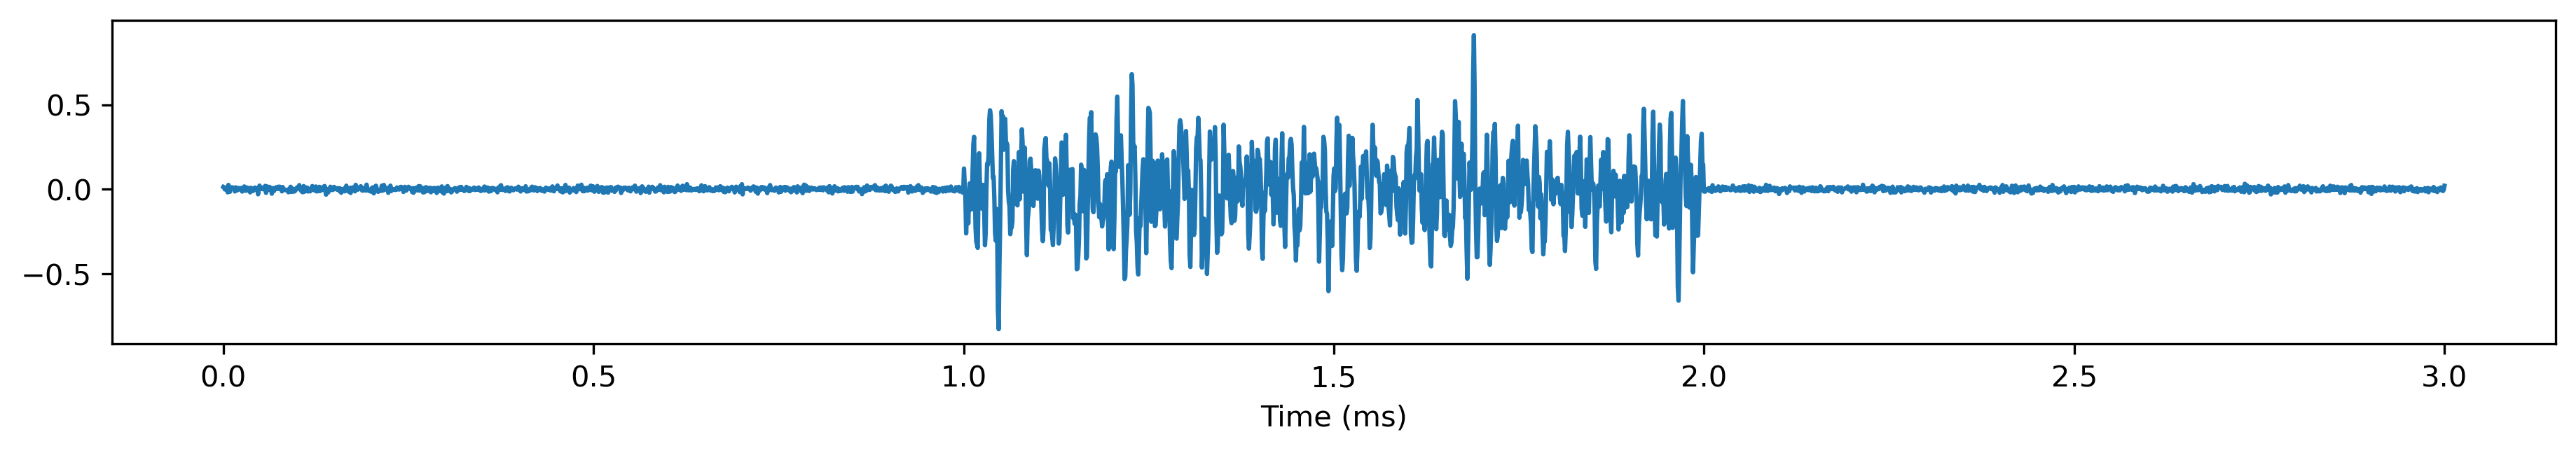

In [166]:
signal = baseline_1
fig, ax = plt.subplots(figsize=(15, 2), dpi=300)
ax.set_xlabel("Time (ms)")
ax.plot(jnp.linspace(0, len(signal)/fs, len(signal)), signal)
print(f"Reference mean frequency: {MNF_1[0]} Hz")

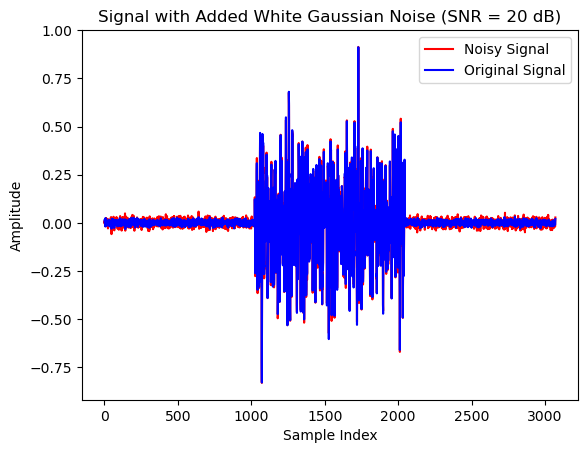

In [167]:
SNR = 20
#signal_noise = add_noise(baseline_1, SNR, plot = True)
signal_noise = add_noise(signal, SNR, plot = True)
signal = signal_noise

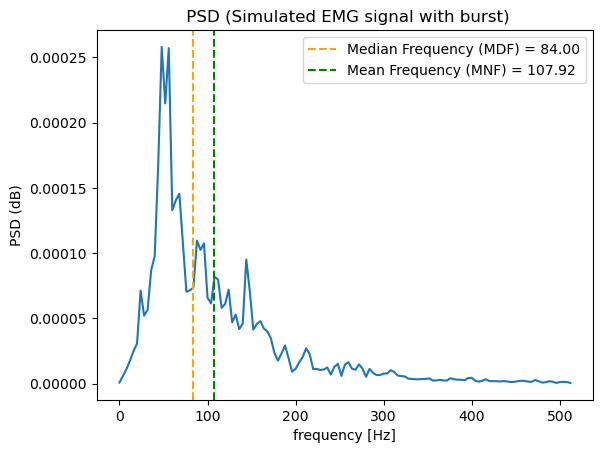

In [168]:
psd_welch, f_welch, MNF = superlet.compute_psd_welch(signal, fs, plot=True, muscle='Simulated EMG signal with burst')

Reference mean frequency: [110.97685447552273] Hz


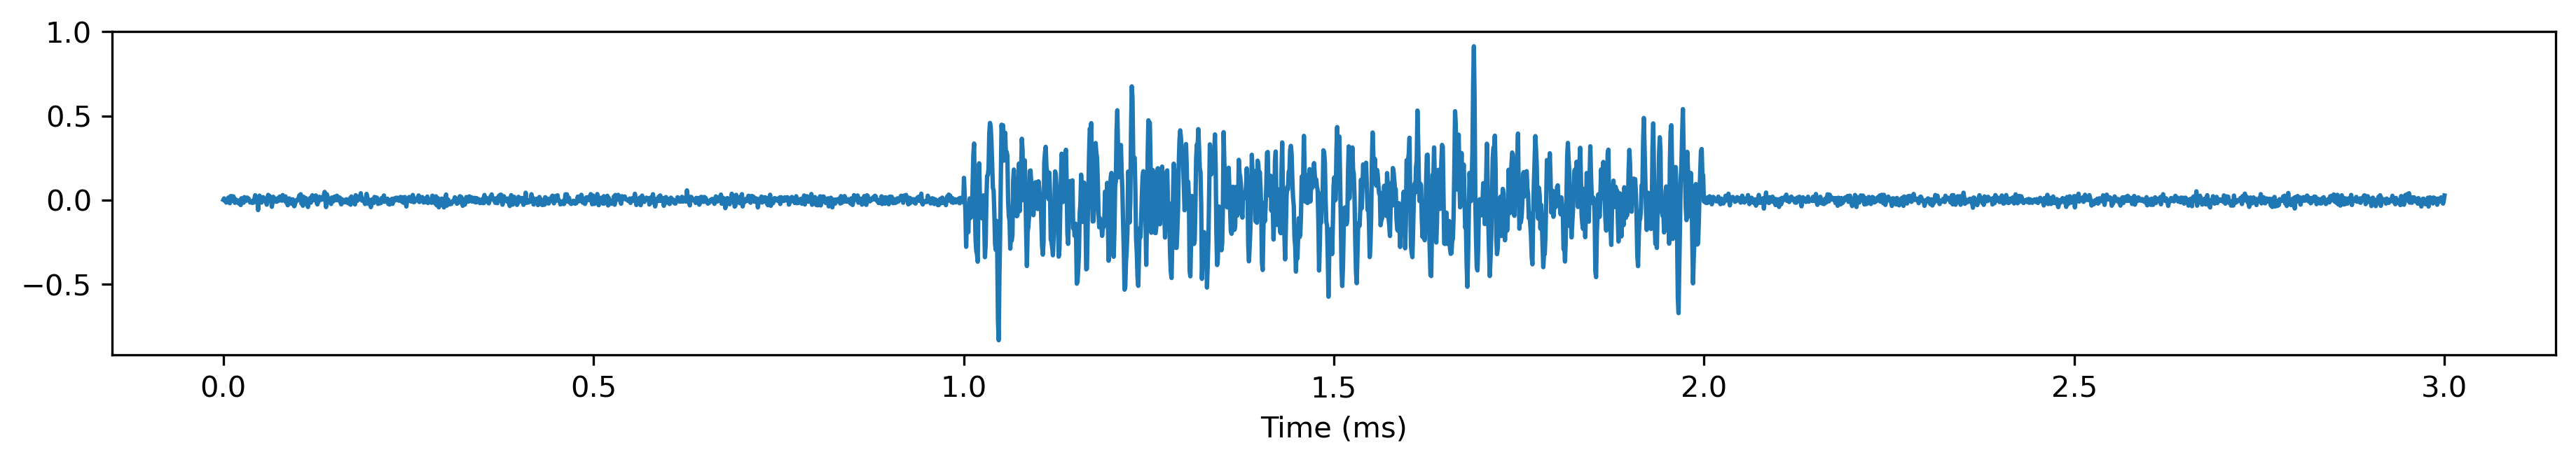

In [169]:
fig, ax = plt.subplots(figsize=(15, 2), dpi=300)
ax.set_xlabel("Time (ms)")
ax.plot(jnp.linspace(0, len(signal)/fs, len(signal)), signal)
print(f"Reference mean frequency: {MNF_1} Hz")

## WAVELET PARAMETERS = 3, 16, 33, 55, 60, 115 cycles

In [66]:
importlib.reload(superlet)

<module 'superlets_package.superlets' from '/Users/neuralrehabilitationgroup/PycharmProjects/Superlets-Marina/superlets_package/superlets.py'>

In [67]:
plot_1 = False
plot_2 = False

108.91991
Onset = 0.9514816020840118, offset = 2.059264083360469
1.1077824812764572
1


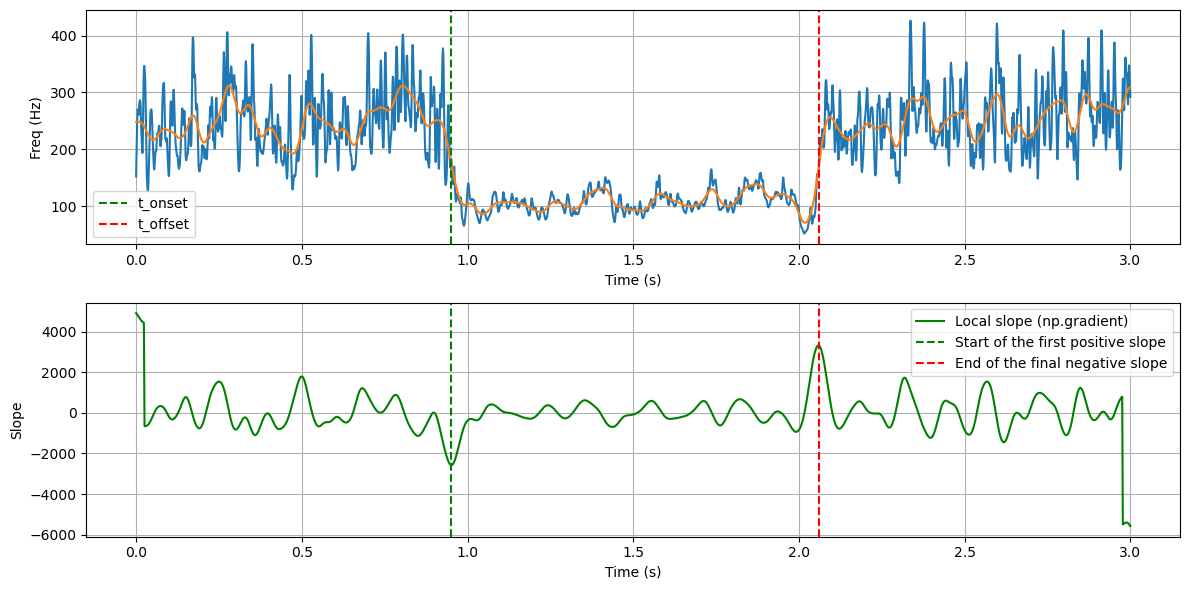

105.49664
Onset = 0.8909150113969391, offset = 2.3152067730380983
1.4242917616411592
1


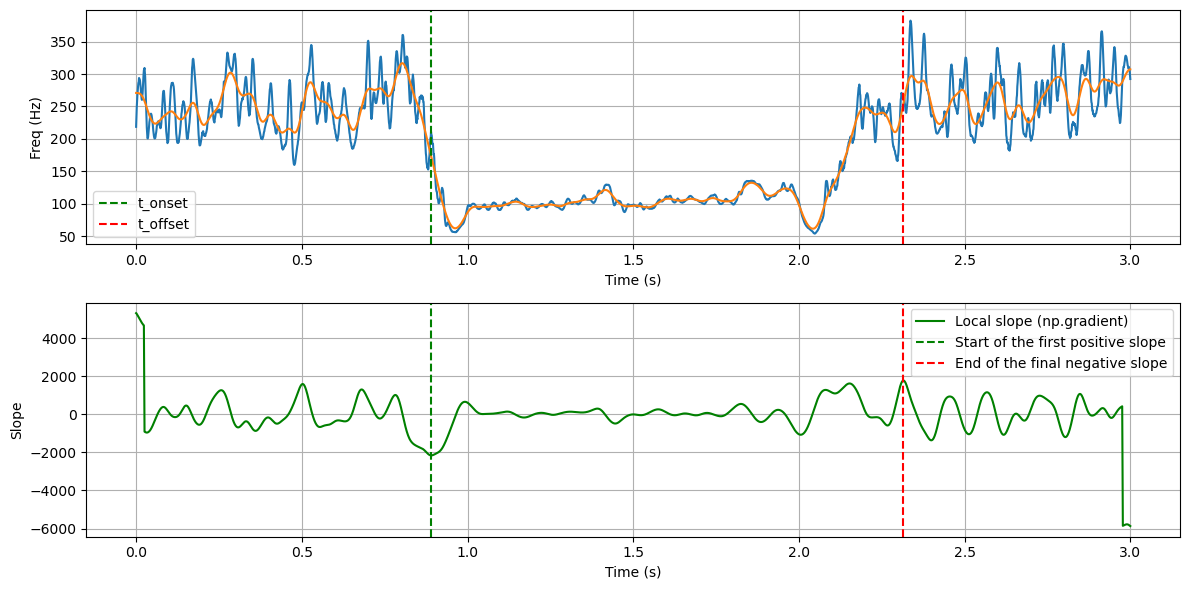

105.48145
Onset = 0.8420709866492999, offset = 2.162813415825464
1.3207424291761642
1


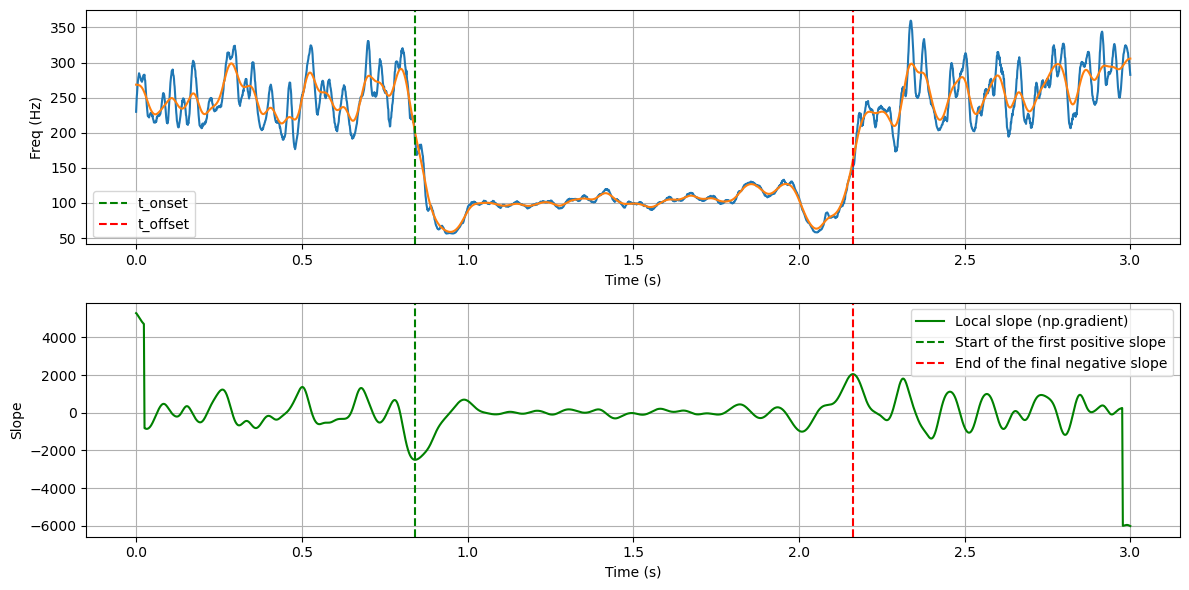

106.00418
Onset = 0.8332790621947248, offset = 2.1706284597850862
1.3373493975903614
1


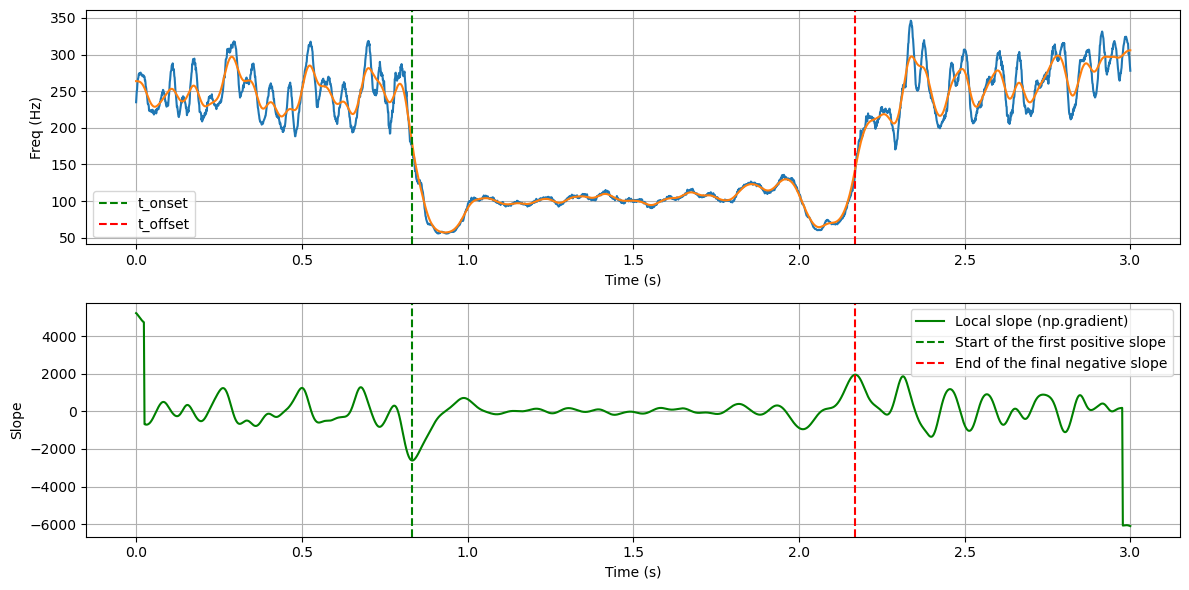

106.126526
Onset = 0.8323021816997721, offset = 2.1706284597850862
1.3383262780853142
1


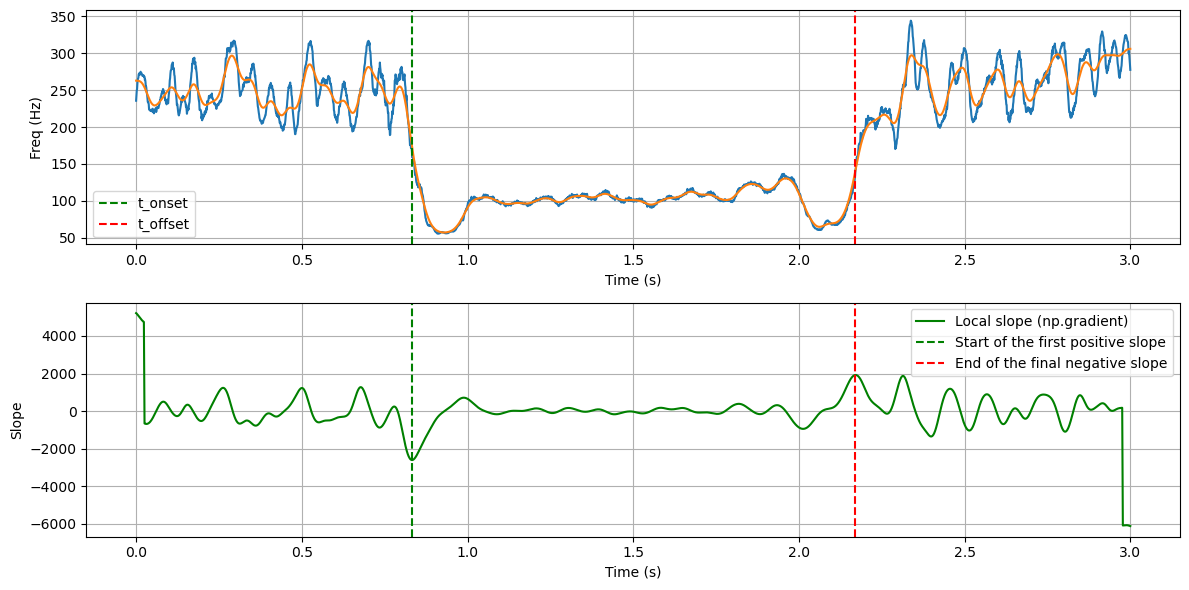

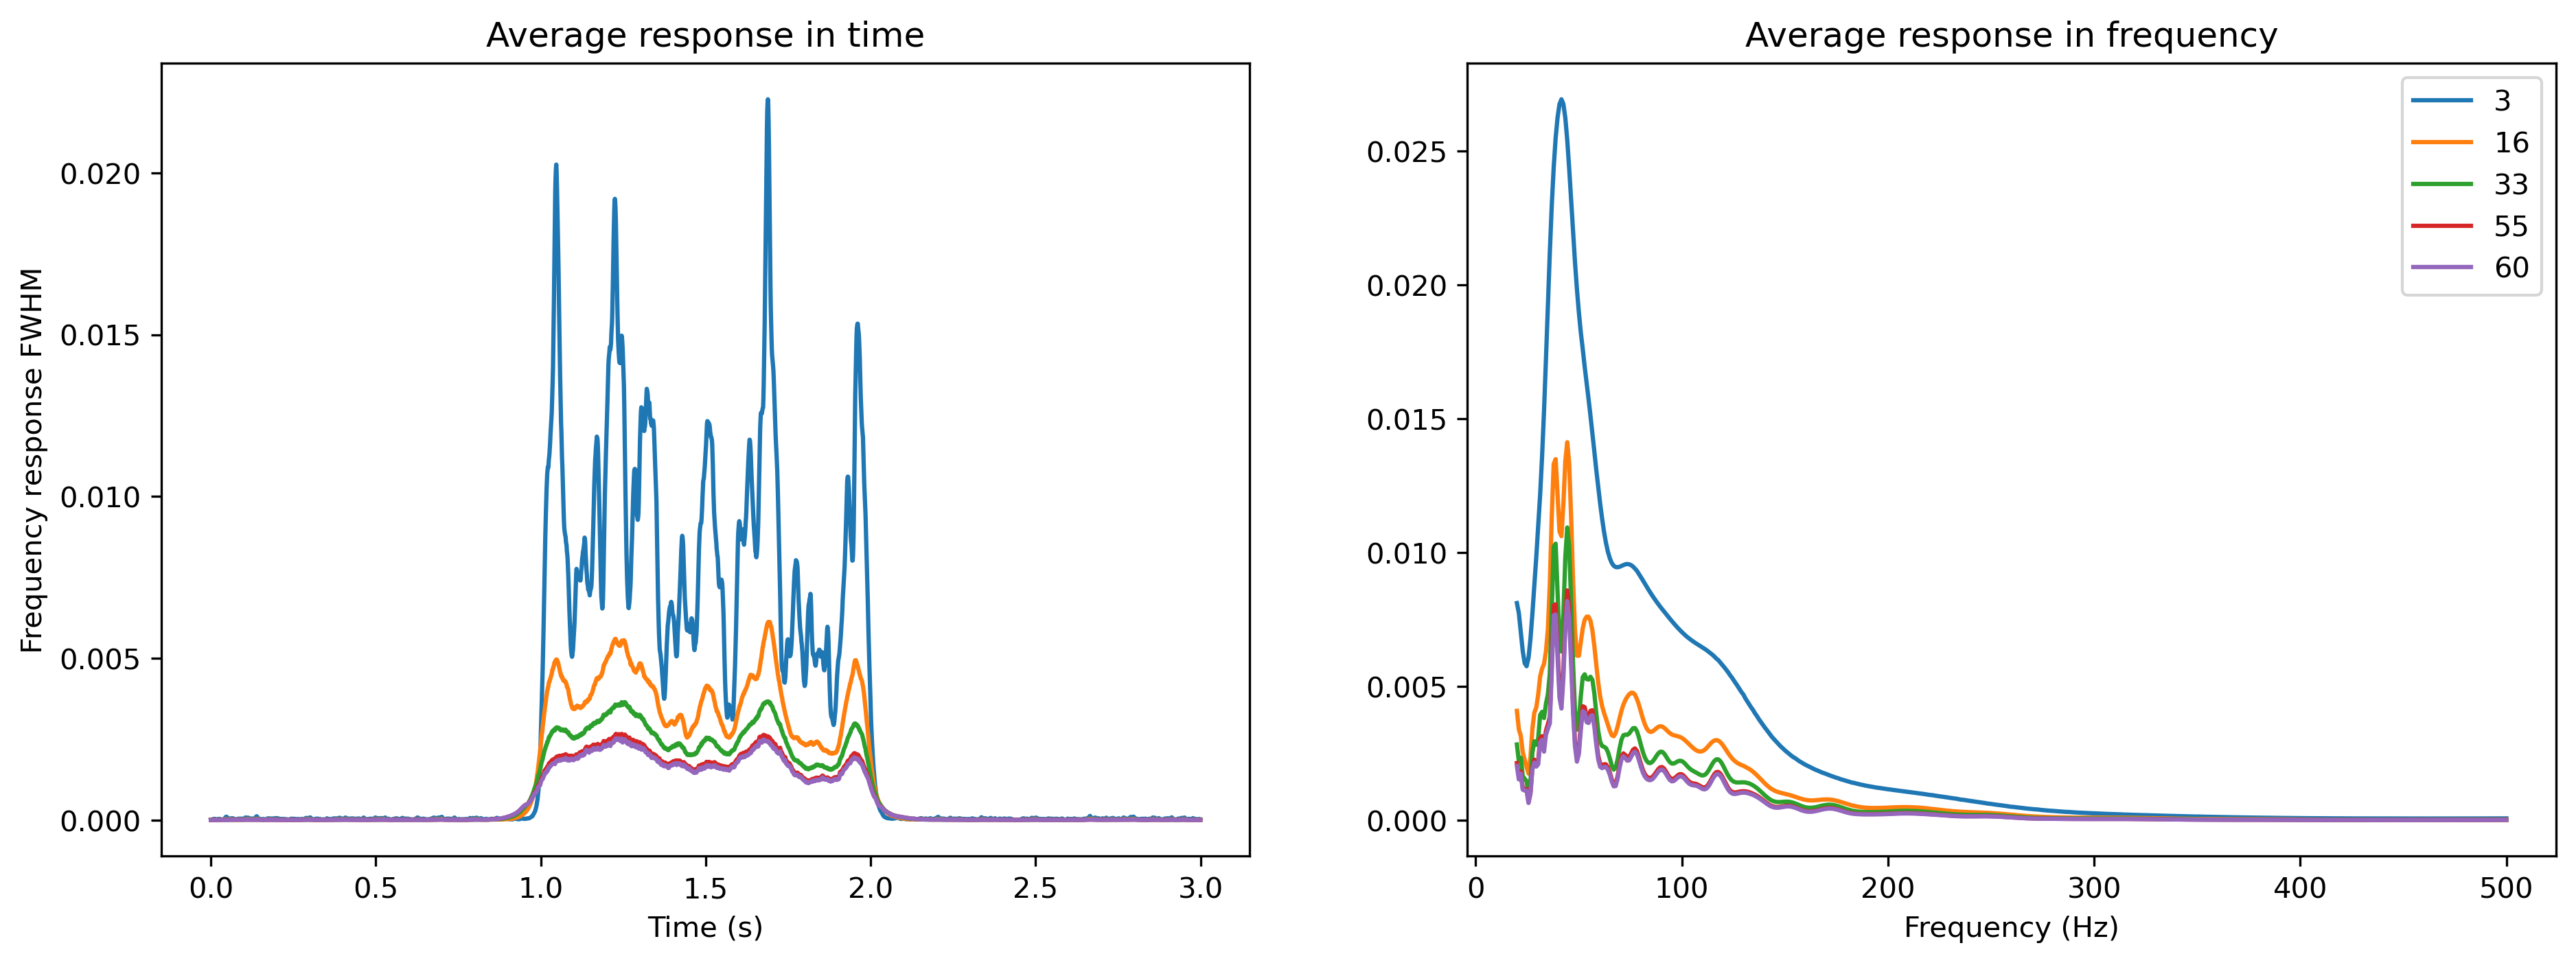

In [170]:
if plot_1:
    fig, ax = plt.subplots(ncols=len(params_wavelet), figsize=(18, 5), dpi=300)
if plot_2:
    fig_2, ax_2 = plt.subplots(ncols=len(params_wavelet), figsize=(18, 5), dpi=300)
    fig_3, ax_3 = plt.subplots(figsize=(10, 6))

mae_wavelet_f = []
std_wavelet_f = []

mae_wavelet_t = []
std_wavelet_t = []

total_time = []
total_freq = []

total_scalogram_wavelet = []
res_wavelet = []

# Iterar sobre los parámetros de wavelet
for i, c in enumerate(params_wavelet):
    wavelet = f"cmor{c}-1.0"

    cwtmatr, f, physical_freqs = morlet.wavelet_transform_2(signal,wavelet,freqs,fs)
    cwtmatr = np.abs(cwtmatr[:, :])
    
    if save:
        df = pd.DataFrame(cwtmatr)
    
        # Guardar en un archivo CSV
        filename = os.path.join(new_folder_path, str(SNR) + "dB_wv_" + str(c) + ".csv")
        df.to_csv(filename, index=False, header=False)  # Sin índices ni encabezados
    
    scalogram_2 = jnp.abs(cwtmatr)**2

    if plot_1:
        pcm = ax[i].pcolormesh(t,f, scalogram_2, shading='gouraud', cmap='jet')
        
        ax[i].set_title(f'c={c}')
        ax[i].set_ylabel('Frecuencia [Hz]')
        ax[i].set_xlabel('Tiempo [s]')
        
        cbar = fig.colorbar(pcm, ax=ax[i], orientation='horizontal')
        cbar.set_label('Power', rotation=0, labelpad=15)  # Etiqueta de la colorbar
    
        ax[i].set_ylim(freqs[0], freqs[-1])  # Ajustar el rango de frecuencias si es necesario
        plt.tight_layout()

    total_scalogram_wavelet.append(scalogram_2)
    instant_mean_freq_total = []

    instant_freq = np.sum(scalogram_2 * f[:, np.newaxis], axis=0) / np.sum(scalogram_2, axis=0)
    if plot_means:
        plt.figure()
        plt.plot(instant_freq)
        plt.title('Frecuencia instantánea')

    sigma = 15 # Desviación estándar del filtro PARA SNR = INF
    y_smooth = gaussian_filter1d(instant_freq, sigma)

    # VALOR MEDIO EN UNA VENTANA DESLIZANTE
    window_size = 50
    window = np.ones(window_size) / window_size  # Ventana normalizada

    # Calcular la media móvil con convolución
    media_movil = np.convolve(y_smooth, window, mode='same')    
    if plot_means:
        plt.figure()
        plt.plot(media_movil, color = 'red')
        plt.title('Media de la señal')
    
    # Derivada de la media para ver el cambio en el valor medio de la señal
    slope_gradient = np.gradient(media_movil, t)
    if plot_means:
        plt.figure()
        plt.plot(slope_gradient, color = 'green')
        plt.title('Gradiente de la media de la señal')
    
    # Coger la porción de la señal del medio    
    time_range = len(slope_gradient)//2
    time_shift = round(burst_duration_1 * 0.9 * fs)
    inicio = time_range-time_shift
    
    first_index = np.argmin(slope_gradient[inicio:time_range]) + inicio
    last_index = np.argmax(slope_gradient[time_range:time_range+time_shift]) + time_range 
    
    t_onset = t[first_index]
    t_offset = t[last_index]
    
    start_idx = np.searchsorted(t, burst_start_1)  # Encuentra el índice de inicio
    end_idx = np.searchsorted(t, burst_start_1 + burst_duration_1)  # Encuentra el índice final

    instant_mean_freq_burst = instant_freq[start_idx:end_idx]

    if plot_2:
        ax_2[i].plot(t, y_smooth)

        ax_2[i].set_xlabel("Time (s)")
        ax_2[i].set_ylabel("Frequency (Hz)")
        #ax_2[i].set_xlim(t[0], t[-1])
        #plt.title("Medias de cada fila en función del tiempo")
        ax_2[i].grid(True)

        ax_3.plot(t, instant_freq, label=f"Mean frequency (Cycles: {c})")
        plt.tight_layout()

    #MAE in frequency
    print(f'Estimated mean frequency {np.mean(instant_mean_freq_burst)} Hz')
    mae_f, std_f = calculate_mae(instant_mean_freq_burst, MNF_1)
    mae_wavelet_f.append(mae_f)
    std_wavelet_f.append(std_f)
    
    #MAE in time
    print(f'Estimated onset = {t_onset} s, offset = {t_offset} s')
    estimates_combined = t_offset - t_onset
    print(f' Estimated difference {estimates_combined} s')
    true_values_combined = t_offset_1 - t_onset_1
    print(f'Real difference {true_values_combined} s')

    mae_t, std_t = calculate_mae(estimates_combined, true_values_combined)
    mae_wavelet_t.append(mae_t)
    std_wavelet_t.append(std_t)

    time = np.arange(scalogram_2.shape[1]) / fs

    total_time.append(time)
    total_freq.append(freqs)
    
    # Visualization
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(t, instant_freq)
    plt.plot(t,y_smooth)
    plt.axvline(t_onset, color='green', linestyle='--', label='t_onset')
    plt.axvline(t_offset, color='red', linestyle='--', label='t_offset')
    plt.xlabel('Time (s)')
    plt.ylabel('Freq (Hz)')
    plt.legend()
    plt.grid()
    
    # Slopes and t_onset and t_offset
    plt.subplot(2, 1, 2)
    plt.plot(t, slope_gradient, 'g-', label='Local slope (np.gradient)')
    plt.axvline(t_onset, color='green', linestyle='--', label='Start of the first positive slope')
    plt.axvline(t_offset, color='red', linestyle='--', label='End of the final negative slope')
    plt.xlabel('Time (s)')
    plt.ylabel('Slope')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Configuración del gráfico
if plot_2:
    ax_3.set_xlabel("Time (s)")
    ax_3.set_ylabel("Frequency (Hz)")
    ax_3.legend()
    ax_3.grid(True)
    ax_3.set_title("Comparación de frecuencias medias instantáneas")

res_wavelet = superlet.compute_avg_response_resolution(total_scalogram_wavelet, total_time, total_freq, params_wavelet)

In [84]:
mae_wavelet_f

[15.973829076219307,
 11.521798674020511,
 9.975910125576554,
 9.319660175845643,
 9.23992052327158]

In [85]:
mae_wavelet_t

[0.1419732985998048,
 0.2562683165092805,
 0.4047541517421034,
 0.5473787040052103,
 0.5473787040052103]

## PARÁMETROS SUPERLET: base_cycle, min_order, max_order = [3, 5, 1, 1, 1, 1], [1, 1, 5, 10, 20, 30], [30, 30, 40, 100, 100, 200]

In [86]:
importlib.reload(superlet)

<module 'superlets_package.superlets' from '/Users/neuralrehabilitationgroup/PycharmProjects/Superlets-Marina/superlets_package/superlets.py'>

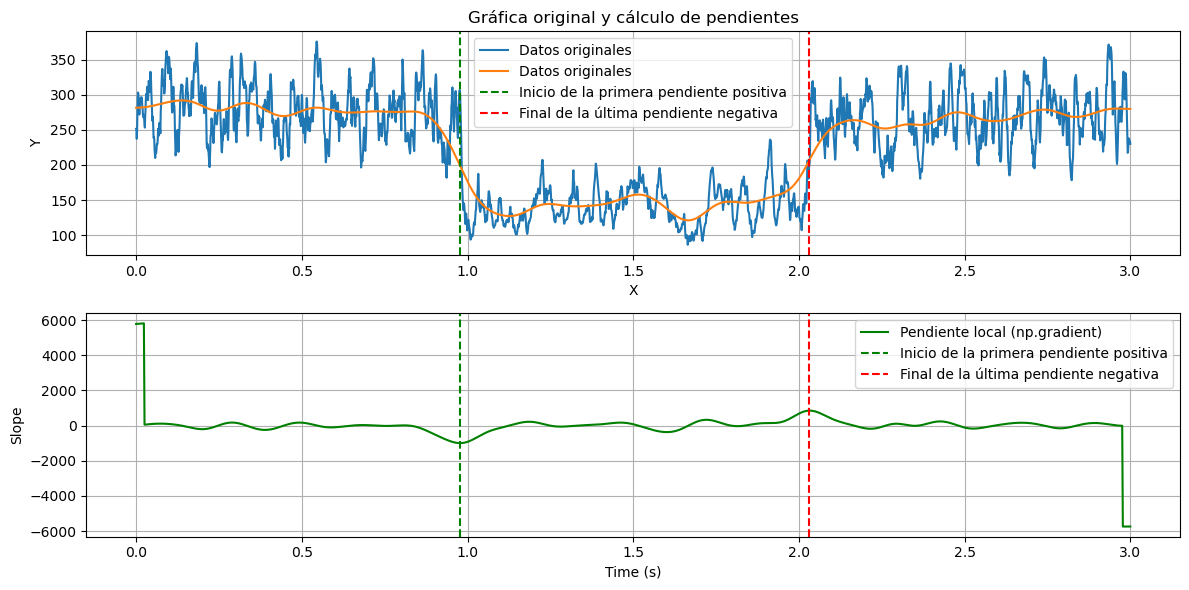

141.24869333939915
Onset = 0.9778573754477369, offset = 2.031911429501791
1.0540540540540542
1


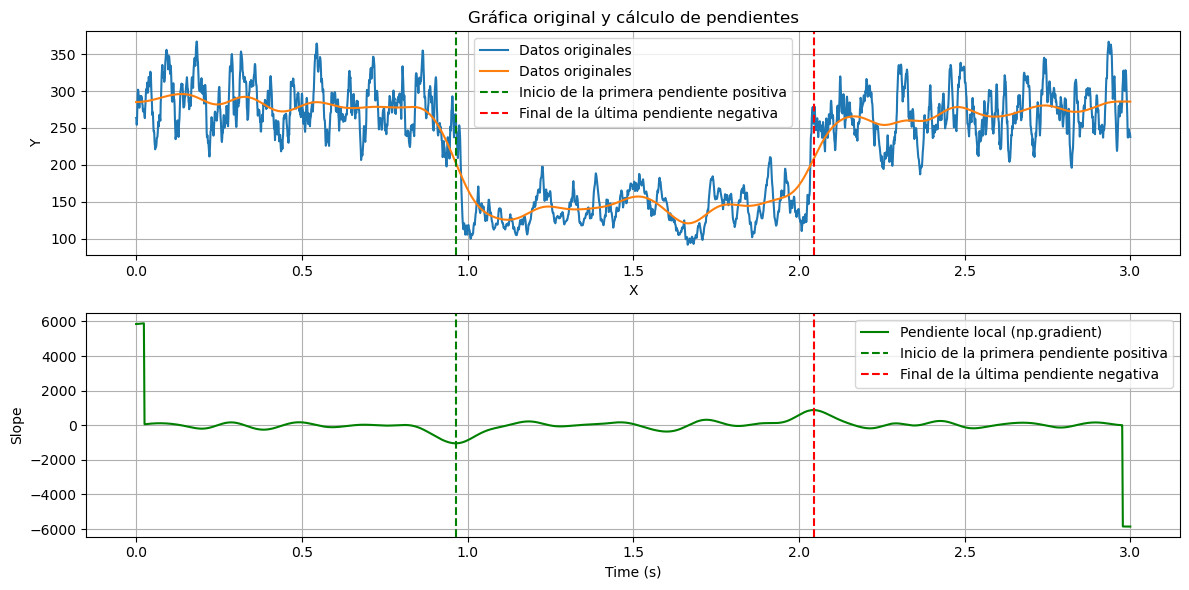

140.4119277993718
Onset = 0.9641810485183979, offset = 2.044610875936177
1.080429827417779
1


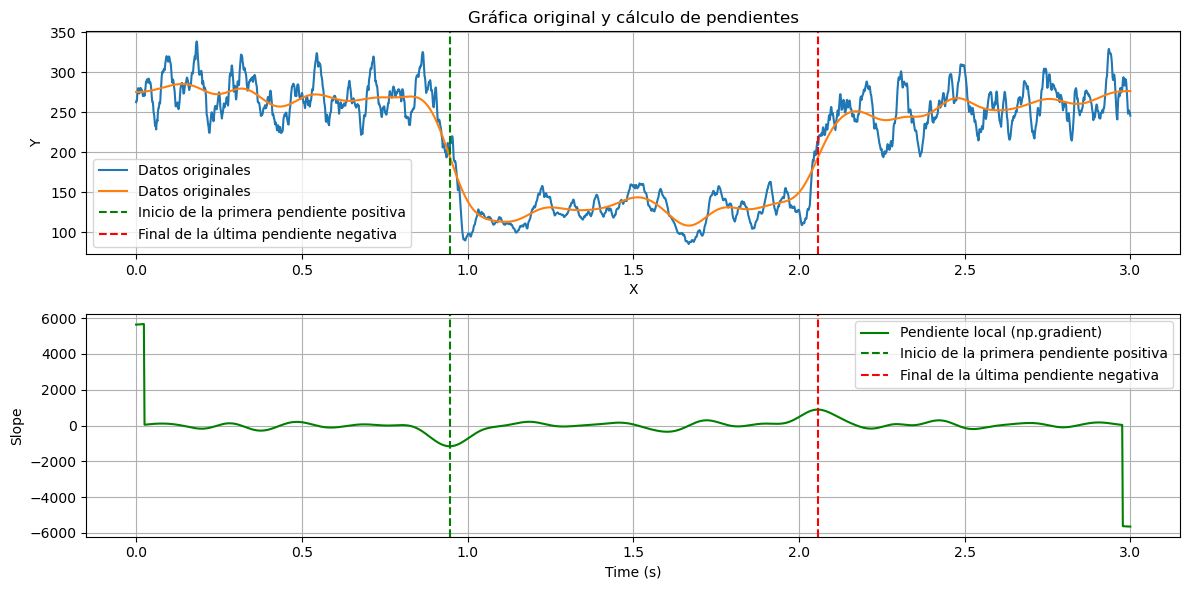

126.46763853298857
Onset = 0.9465971996092478, offset = 2.0573103223705633
1.1107131227613154
1


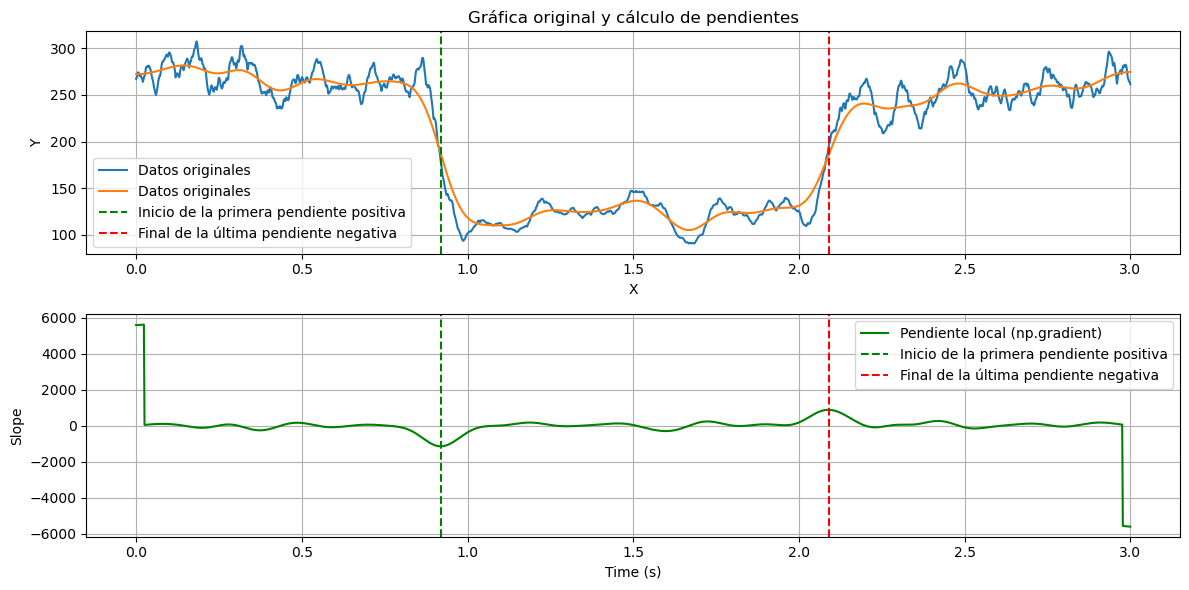

121.81718851559023
Onset = 0.9192445457505699, offset = 2.089547378704005
1.170302832953435
1


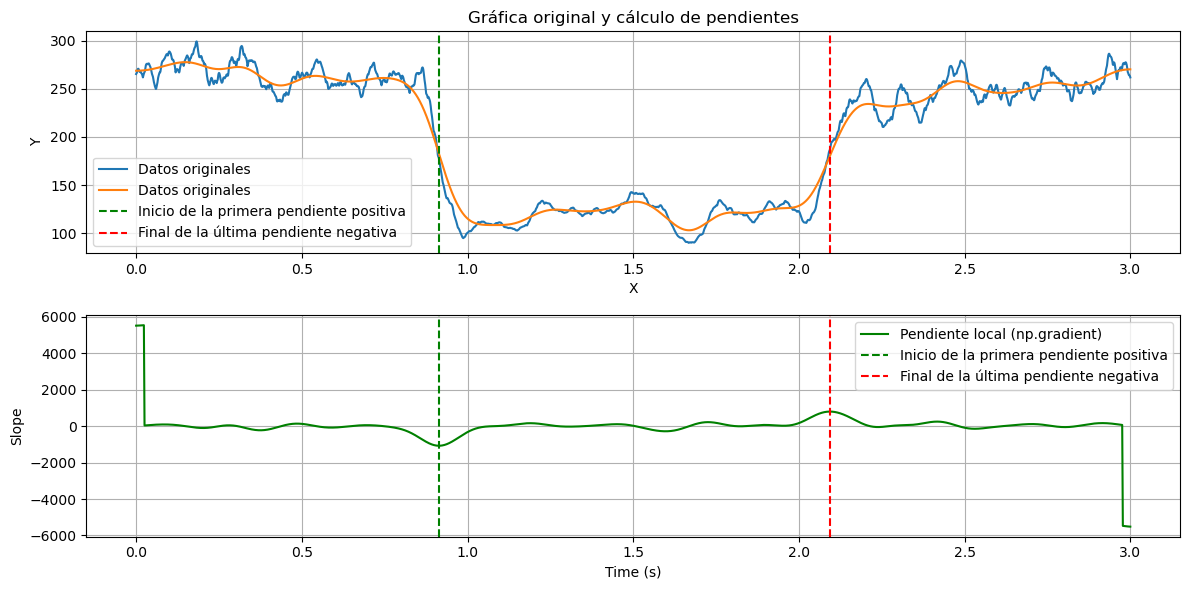

119.27123215229426
Onset = 0.9133832627808531, offset = 2.0934549006838163
1.1800716379029632
1


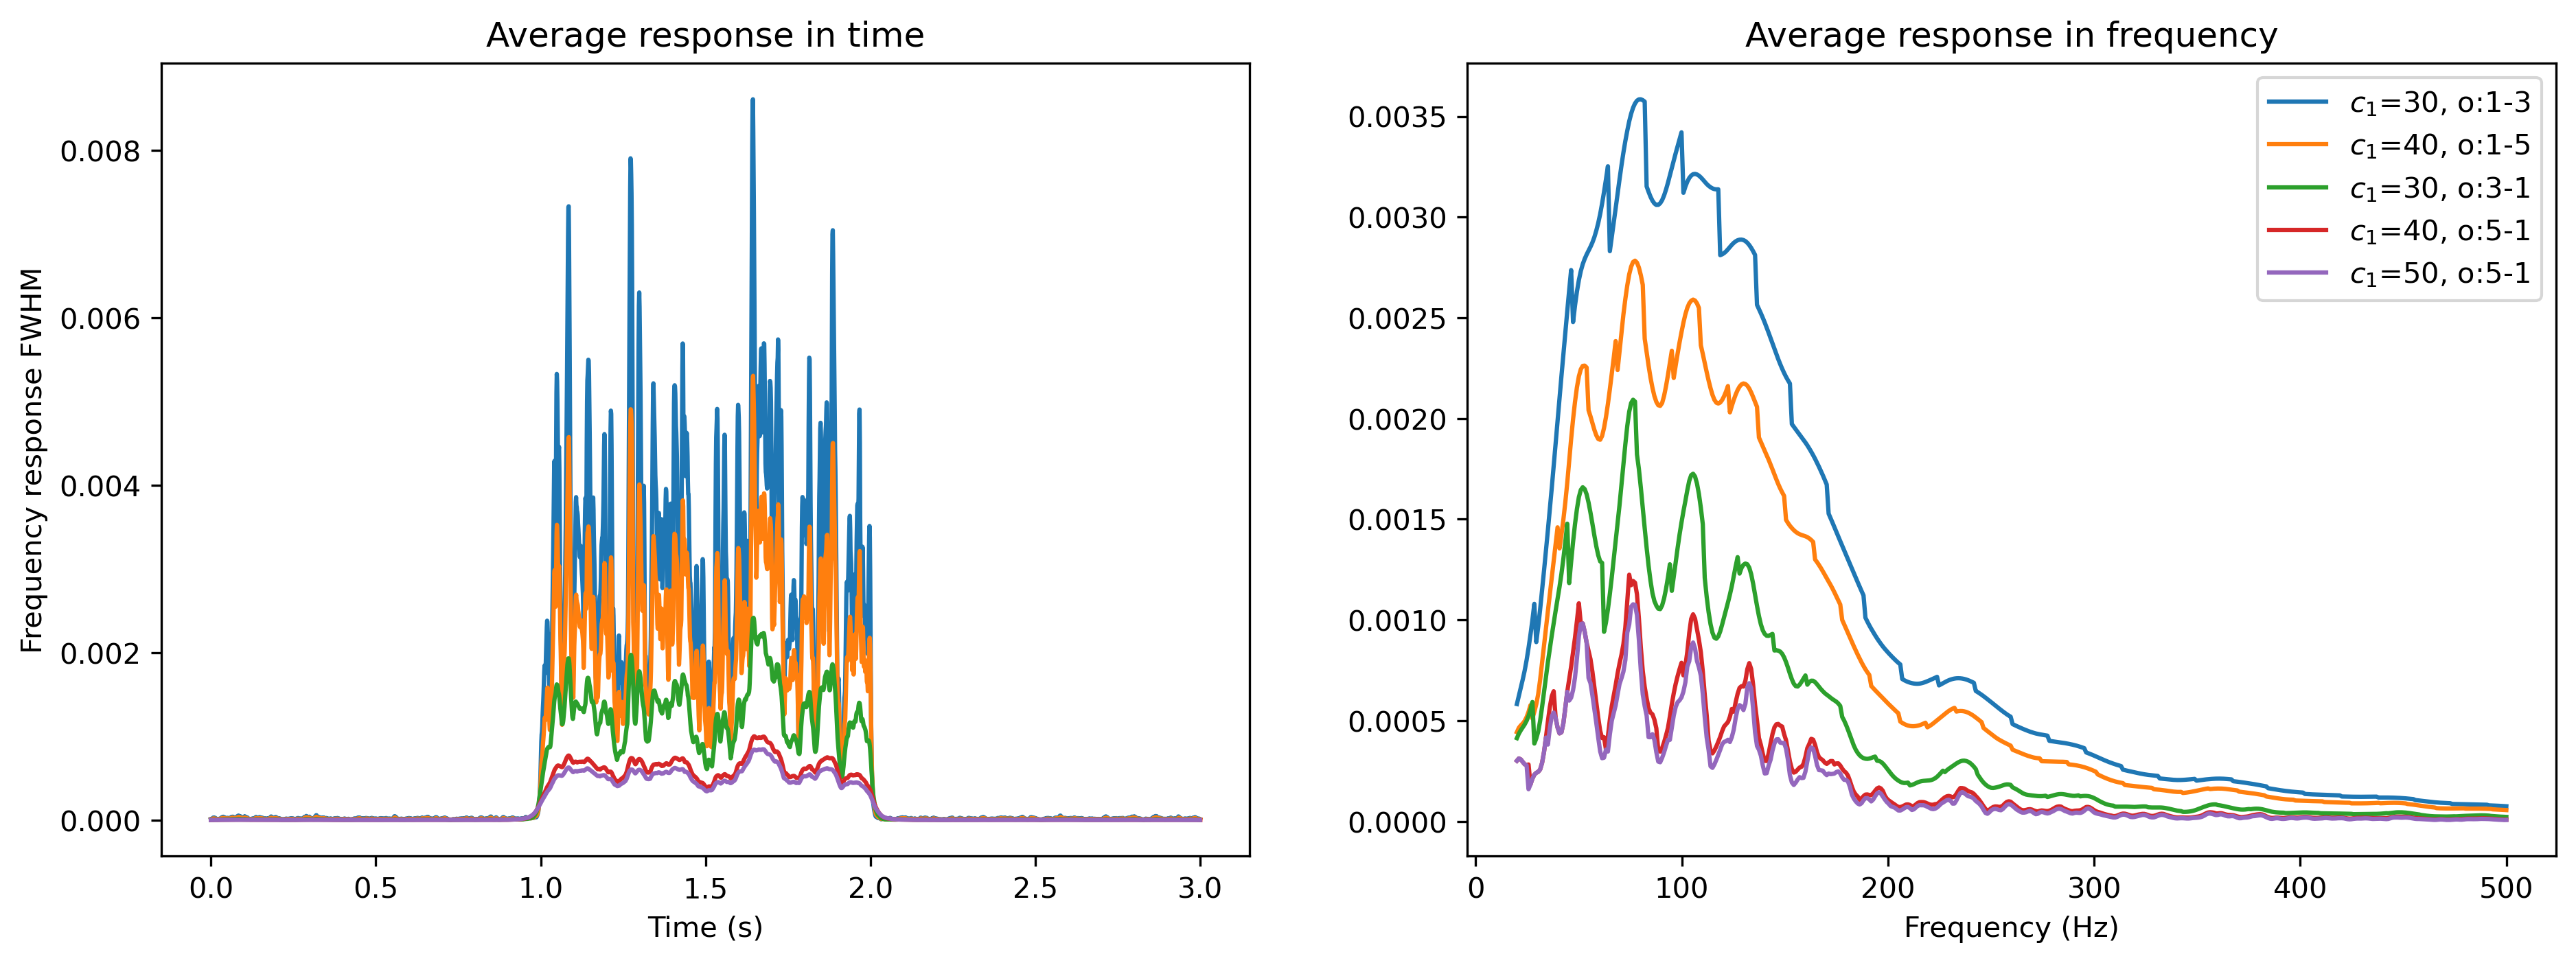

In [87]:
if plot_1:
    fig, ax = plt.subplots(ncols=len(params_superlet[0]), figsize=(15, 5), dpi=300)

if plot_2:
    fig_2, ax_2 = plt.subplots(ncols=len(params_superlet[0]), figsize=(15, 5), dpi=300)
    fig_3, ax_3 = plt.subplots(figsize=(10, 6))

mae_superlet_f = []
std_superlet_f = []

mae_superlet_t = []
std_superlet_t = []

total_time = []
total_freq = []

total_scalogram_superlet = []

for (i, (base_cycle, min_order, max_order)) in enumerate(zip(*params_superlet)):

    wv, scalogram = superlet.adaptive_superlet_transform(signal, freqs, sampling_freq=fs,
                                                         base_cycle=base_cycle, min_order=min_order,
                                                         max_order=max_order, mode="mul")
    
    if plot_1:
        im = ax[i].imshow(jnp.abs(scalogram) ** 2, aspect='auto', cmap="jet", interpolation="none", origin="lower",extent=[0, len(signal) / fs, freqs[0], freqs[-1]])
        ax[i].set_title(f"$c_1$: {base_cycle}, o: {min_order}-{max_order}")
        ax[i].set_xlabel("Time (s)")
        ax[i].set_ylabel("Frequency (Hz)")

        cbar = fig.colorbar(im, ax=ax[i], orientation='horizontal')
        cbar.set_label('Power [a.u]', rotation=0, labelpad=15)  # Etiqueta de la colorbar
        plt.tight_layout()

    scalogram_2 = np.abs(scalogram) ** 2
    
    if save:
        df = pd.DataFrame(scalogram_2)
    
        # Guardar en un archivo CSV
        filename = os.path.join(new_folder_path,str(SNR) + "dB_superlet_" + str(base_cycle) + "-" + str(min_order) + "-" + str(max_order) + ".csv")
        df.to_csv(filename, index=False, header=False)  # Sin índices ni encabezados

    instant_mean_freq_total = []
    total_scalogram_superlet.append(scalogram_2)
    
    instant_freq = np.sum(scalogram_2 * freqs[:, np.newaxis], axis=0) / np.sum(scalogram_2, axis=0)
    if plot_means:
        plt.figure()
        plt.plot(instant_freq)
        plt.title('Frecuencia instantánea')
    
    # Mismo SIGMA que para la wavelet
    sigma = 50
    y_smooth = gaussian_filter1d(instant_freq, sigma)

    # Misms WINDOW_SIZE que para la wavelet
    window = np.ones(window_size) / window_size  # Ventana normalizada

    # Calcular la media móvil con convolución
    media_movil = np.convolve(y_smooth, window, mode='same')   
    if plot_means:
        plt.figure()
        plt.plot(media_movil, color = 'red')
        plt.title('Media de la señal')
    
    # Derivada de la media para ver el cambio en el valor medio de la señal
    slope_gradient = np.gradient(media_movil, t)
    if plot_means:
        plt.figure()
        plt.plot(slope_gradient, color = 'green')
        plt.title('Gradiente de la media de la señal')
    
    # Coger la porción de la señal del medio    
    time_range = len(slope_gradient)//2
    time_shift = round(burst_duration_1 * 0.7 * fs)
    inicio = time_range-time_shift
    
    first_index = np.argmin(slope_gradient[inicio:time_range]) + inicio
    last_index = np.argmax(slope_gradient[time_range:time_range+time_shift]) + time_range 
    
    t_onset = t[first_index]
    t_offset = t[last_index]    

    initial_imnf = instant_freq[:round(burst_start_1 * fs) - offset]
    instant_mean_freq_total.extend(initial_imnf)
    # plt.figure()
    # plt.plot(initial_imnf)

    instant_mean_freq_burst = instant_freq[
                              round(burst_start_1 * fs):round((burst_start_1 + burst_duration_1) * fs)]
    instant_mean_freq_burst = instant_mean_freq_burst[offset_burst:round(len(instant_mean_freq_burst)) - offset_burst]
    instant_mean_freq_total.extend(instant_mean_freq_burst)

    final_imnf = instant_freq[round((burst_start_1 + burst_duration_1) * fs) + offset:]
    instant_mean_freq_total.extend(final_imnf)
    # plt.figure()
    # plt.plot(final_imnf)
    # plt.figure()
    # plt.plot(instant_mean_freq_total)

    if plot_2:
        ax_2[i].plot(t, instant_mean_freq_total,
                     label="Mean frequency (each window of " + str(len(freqs)) + ' samples)')

        ax_2[i].set_xlabel("Time (s)")
        ax_2[i].set_ylabel("Frequency (Hz)")
        #ax_2[i].set_xlim(tiempo[0], tiempo[-1])
        #plt.title("Medias de cada fila en función del tiempo")
        ax_2[i].legend()
        ax_2[i].grid(True)

        ax_3.plot(t, instant_mean_freq_total, label=f"Mean frequency (Cycles: {base_cycle})")

     #MAE in frequency
    print(f'Estiamted mean frequency {np.mean(instant_mean_freq_burst)} Hz')
    mae_f, std_f = calculate_mae(instant_mean_freq_burst, MNF_1)
    mae_superlet_f.append(mae_f)
    std_superlet_f.append(std_f)
    
    #MAE in time
    print(f'Estimated onset = {t_onset} s, offset = {t_offset} s')
    estimates_combined = t_offset - t_onset
    print(f'Estimated difference: {estimates_combined} s')
    true_values_combined = t_offset_1 - t_onset_1
    print(f'Real difference: {true_values_combined} s')

    mae_t, std_t = calculate_mae(estimates_combined, true_values_combined)
    mae_superlet_t.append(mae_t)
    std_superlet_t.append(std_t)

    time = np.arange(scalogram_2.shape[1]) / fs

    total_time.append(time)
    total_freq.append(freqs)

    total_time.append(t)
    total_freq.append(freqs)
    
    # Visualización
    plt.figure(figsize=(12, 6))
    
    # Gráfica original
    plt.subplot(2, 1, 1)
    plt.plot(t, instant_freq, label='Datos originales')
    plt.plot(t, y_smooth, label='Datos originales')
    plt.axvline(t_onset, color='green', linestyle='--', label='Inicio de la primera pendiente positiva')
    plt.axvline(t_offset, color='red', linestyle='--', label='Final de la última pendiente negativa')
    plt.title('Gráfica original y cálculo de pendientes')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid()
    
    # Gráfica de pendientes
    plt.subplot(2, 1, 2)
    plt.plot(t, slope_gradient, 'g-', label='Pendiente local (np.gradient)')
    plt.axvline(t_onset, color='green', linestyle='--', label='Inicio de la primera pendiente positiva')
    plt.axvline(t_offset, color='red', linestyle='--', label='Final de la última pendiente negativa')
    plt.xlabel('Time (s)')
    plt.ylabel('Slope')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

if plot_2:
    ax_3.set_xlabel("Time (s)")
    ax_3.set_ylabel("Frequency (Hz)")
    ax_3.legend()
    ax_3.grid(True)
    ax_3.set_title("Comparación de frecuencias medias instantáneas")

res_superlet = superlet.compute_avg_response_resolution(total_scalogram_superlet, total_time, total_freq, [f'$c_1$={c3}, o:{c1}-{c2}' for c1, c2, c3 in zip(*params_superlet)])

In [88]:
mae_superlet_f

[32.17520104425954,
 30.77991761189297,
 19.482102812832125,
 14.53125967454613,
 12.647071346202665]

In [89]:
mae_superlet_t

[0.05405405405405417,
 0.08042982741777904,
 0.1107131227613154,
 0.17030283295343507,
 0.1800716379029632]

## STFT PARAMETERS (window = duration/cycles) = 38, 200, 413, 550, 600, 824 ms

In [90]:
importlib.reload(superlet)

<module 'superlets_package.superlets' from '/Users/neuralrehabilitationgroup/PycharmProjects/Superlets-Marina/superlets_package/superlets.py'>

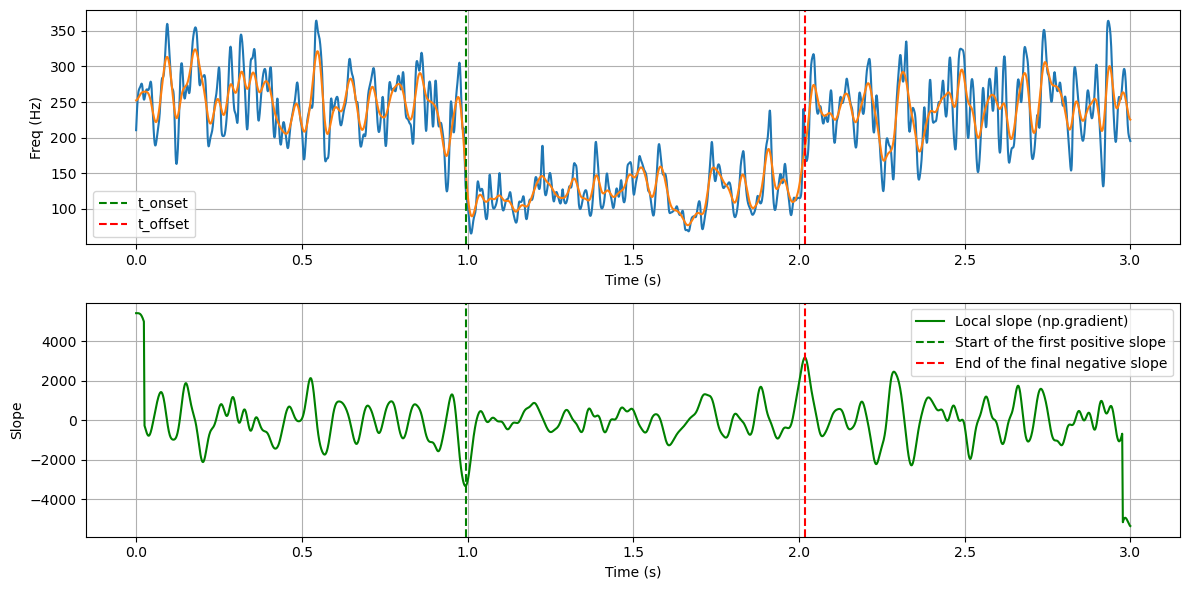

122.9322112957096
Onset = 0.994140625, offset = 2.0185546875
1.0244140625
1


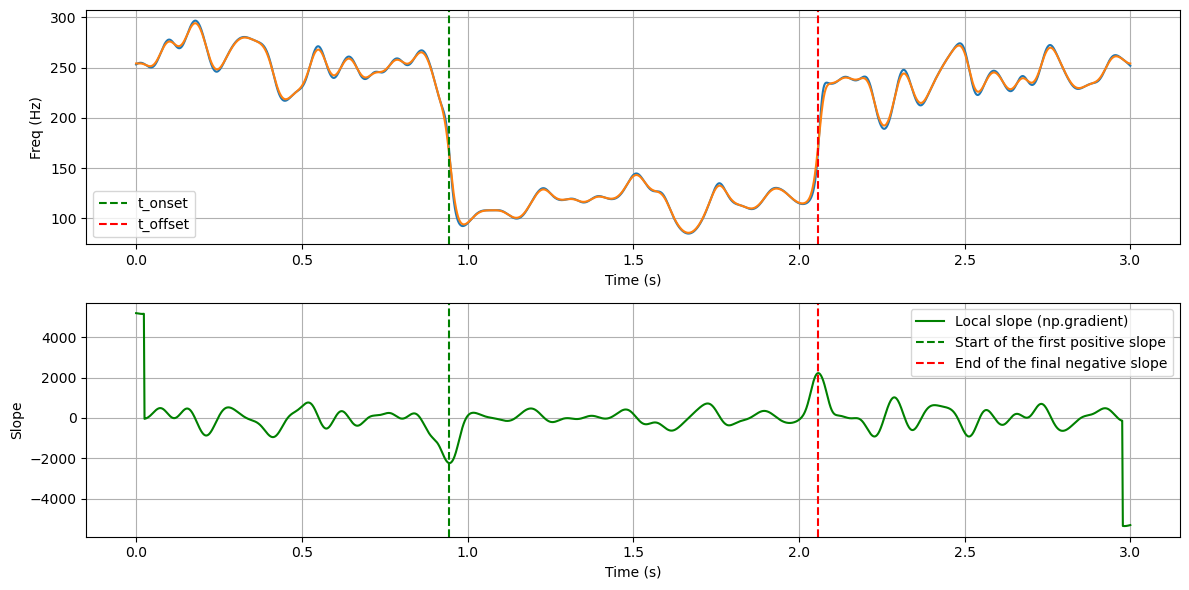

116.36305582357643
Onset = 0.9453125, offset = 2.05859375
1.11328125
1


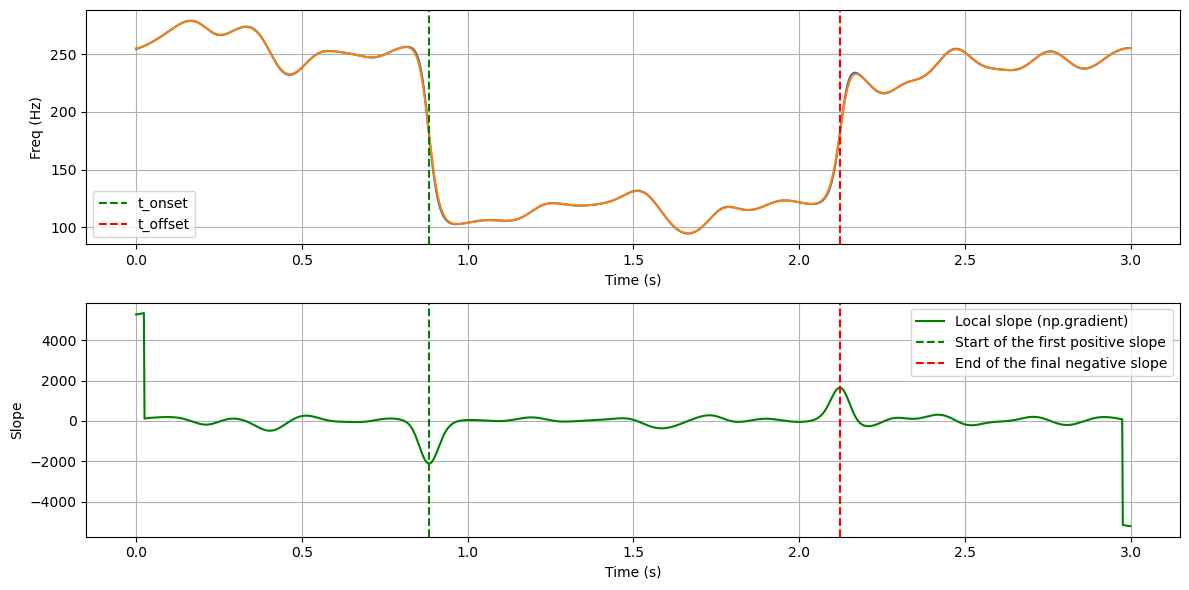

115.03621014114995
Onset = 0.8837890625, offset = 2.123046875
1.2392578125
1


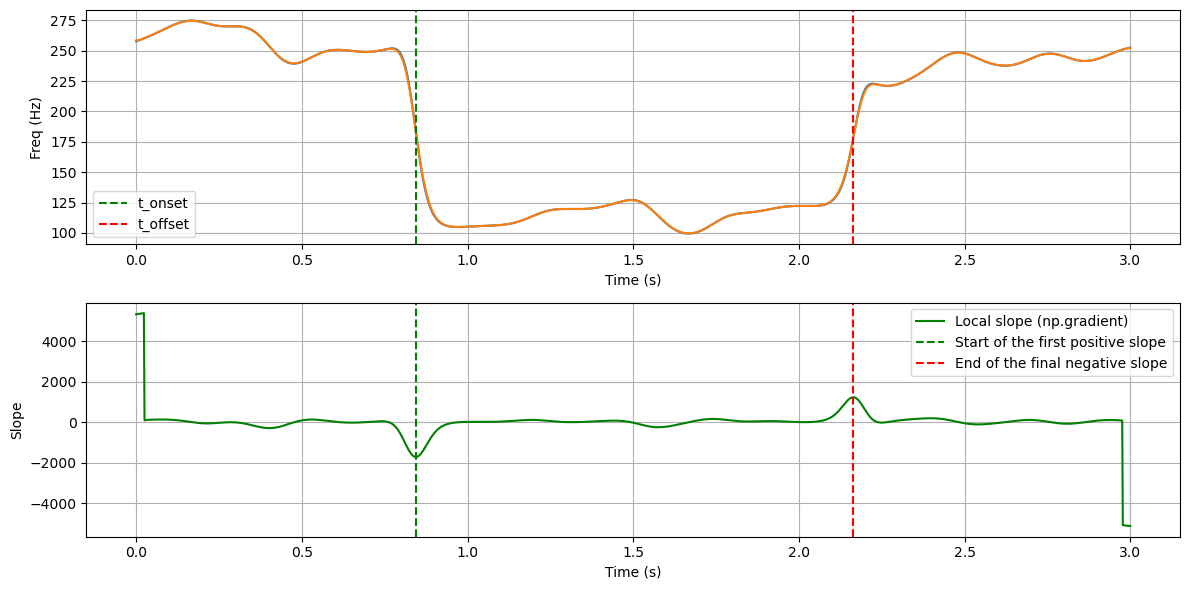

114.56630466905895
Onset = 0.8447265625, offset = 2.1640625
1.3193359375
1


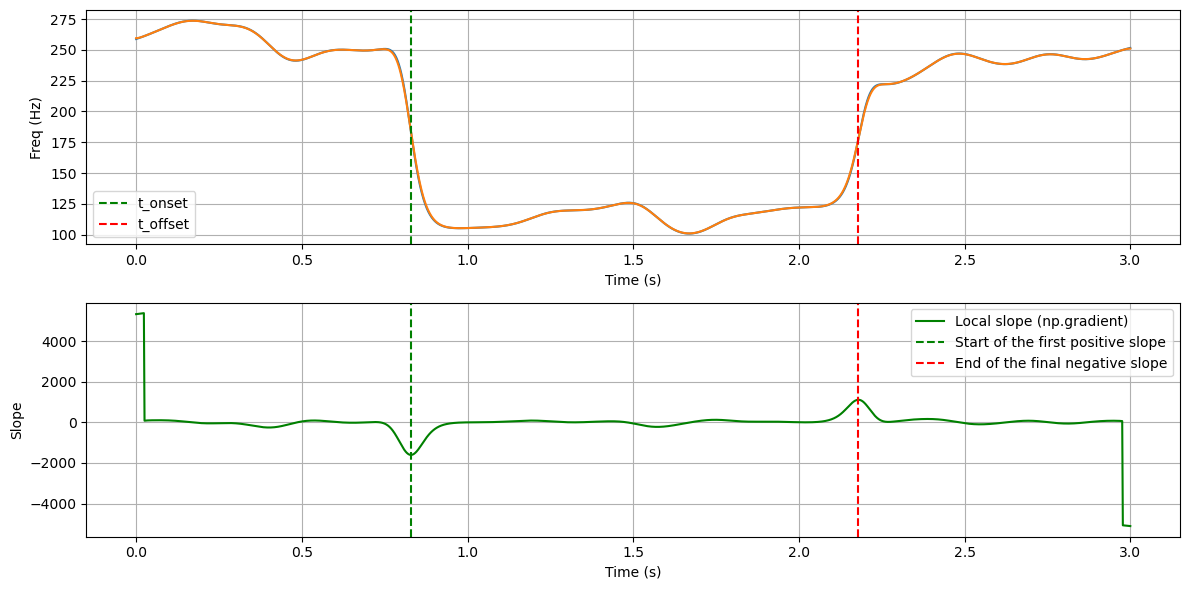

114.4566618283784
Onset = 0.8291015625, offset = 2.1796875
1.3505859375
1


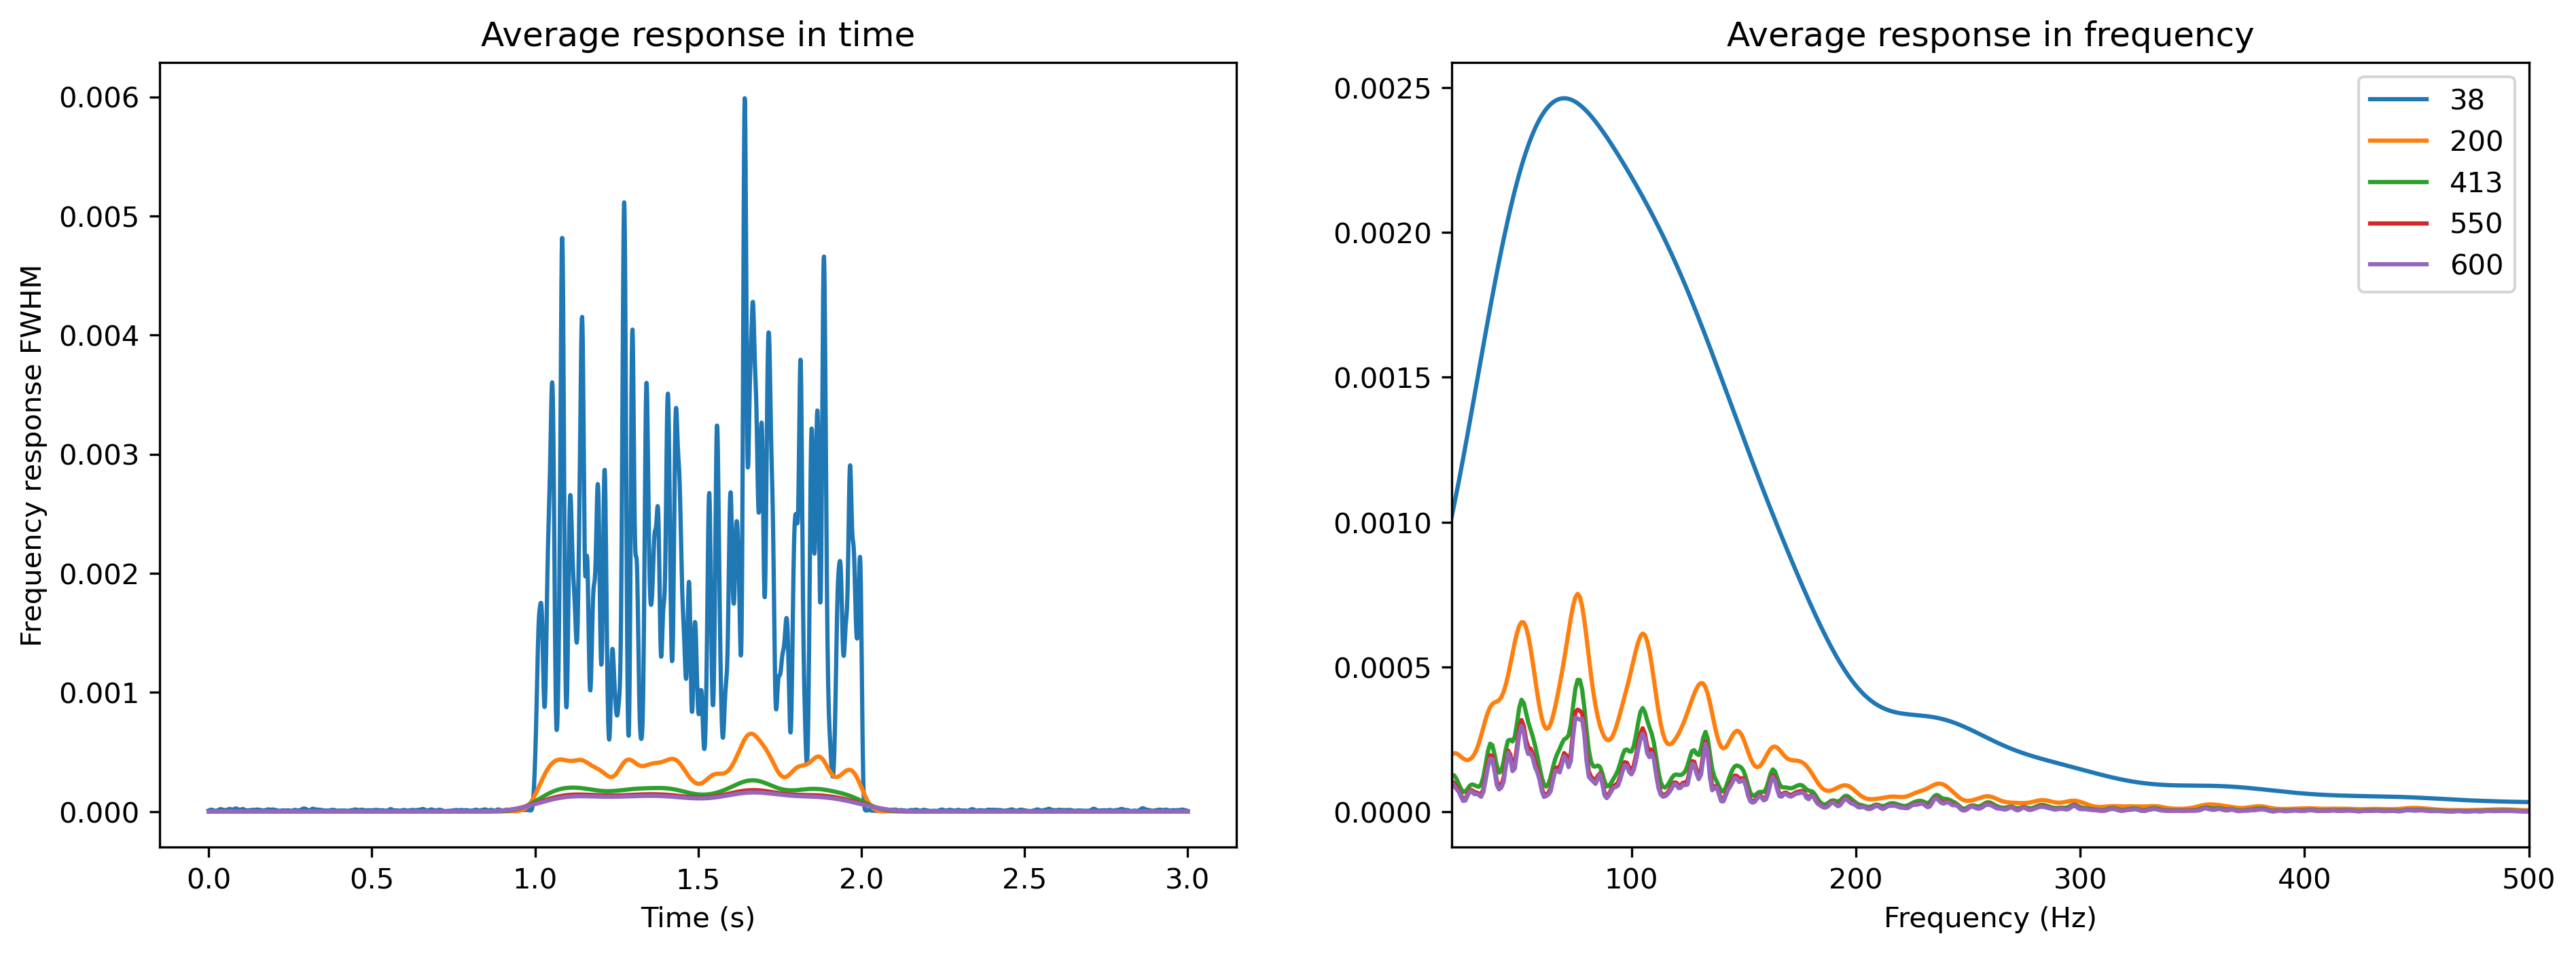

In [92]:
if plot_1:
    fig, ax = plt.subplots(ncols=len(windows_ms), figsize=(15, 5), dpi=300)

if plot_2:
    fig_2, ax_2 = plt.subplots(ncols=len(windows_ms), figsize=(15, 5), dpi=300)
    fig_3, ax_3 = plt.subplots(figsize=(10, 6))

mae_stft_f = []
std_stft_f = []

mae_stft_t = []
std_stft_t = []

total_time = []
total_freq = []

res_stft = []
total_scalogram_stft = []

for i, w in enumerate(windows_ms):
    # Calcular la ventana Blackman
    window = windows.blackman(w)
    
    # Hacer que la f de la stft tenga el mismo tamaño que las demás
    nfft = 2 * (len(freqs))
    
    f, t_stft, Zxx = stft(signal, fs=fs, window='blackman', nperseg=w, noverlap=w-1, nfft=nfft, detrend=False, return_onesided=True, boundary='zeros', padded=True, axis=-1, scaling='spectrum')
    
    # Calcular la representación de potencia (magnitud al cuadrado)
    Zxx_power = np.abs(Zxx) ** 2
    
    if plot_1:
        pcm = ax[i].pcolormesh(t_stft, f, Zxx_power, shading='gouraud', cmap='jet')
        
        ax[i].set_title(f'W={w * 1000 // fs} ms')
        ax[i].set_ylabel('Frecuencia [Hz]')
        ax[i].set_xlabel('Tiempo [s]')
        
        cbar = fig.colorbar(pcm, ax=ax[i], orientation='horizontal')
        cbar.set_label('Power', rotation=0, labelpad=15)  # Etiqueta de la colorbar
    
        #fig.colorbar(pcm, ax=ax[i], label='Potencia')
        ax[i].set_ylim(freqs[0], freqs[-1])  # Ajustar el rango de frecuencias si es necesario
        plt.tight_layout()
    
    scalogram_2 = Zxx_power
    
    if save:
        df = pd.DataFrame(scalogram_2)
    
        # Guardar en un archivo CSV
        filename = os.path.join(new_folder_path, str(SNR) + "dB_stft_" + str(w) + ".csv")
        df.to_csv(filename, index=False, header=False)  # Sin índices ni encabezados
        
    total_scalogram_stft.append(scalogram_2)
 
    instant_mean_freq_total = []  
    
    instant_freq = np.sum(scalogram_2 * f[:, np.newaxis], axis=0) / np.sum(scalogram_2, axis=0)
    if plot_means:
        plt.figure()
        plt.plot(instant_freq)
        plt.title('Frecuencia instantánea')
    
    # Probamos misma SIGMA que la wavelet y superlet
    sigma = 10
    y_smooth = gaussian_filter1d(instant_freq, sigma)
    
    # Mismo WINDOW_SIZE
    window = np.ones(window_size) / window_size  # Ventana normalizada

    # Calcular la media móvil con convolución
    media_movil = np.convolve(y_smooth, window, mode='same')
    if plot_means:
        plt.figure()
        plt.plot(media_movil, color = 'red')
        plt.title('Media de la señal')
    
    slope_gradient = np.gradient(media_movil, t_stft)
    if plot_means:
        plt.figure()
        plt.plot(slope_gradient, color = 'green')
        plt.title('Gradiente de la media de la señal')
    
    # Coger la porción de la señal del medio    
    time_range = len(slope_gradient)//2
    time_shift = round(burst_duration_1 * 1 * fs)
    inicio = time_range-time_shift
    
    first_index = np.argmin(slope_gradient[inicio:time_range]) + inicio
    last_index = np.argmax(slope_gradient[time_range:time_range+time_shift]) + time_range 
    
    t_onset = t_stft[first_index]
    t_offset = t_stft[last_index]
    
    start_idx = np.searchsorted(t_stft, burst_start_1)  # Encuentra el índice de inicio
    end_idx = np.searchsorted(t_stft, burst_start_1 + burst_duration_1)  # Encuentra el índice final

    instant_mean_freq_burst = instant_freq[start_idx:end_idx]
   
    if plot_2:
        ax_2[i].plot(t_stft, instant_mean_freq_total, label="Mean frequency (each window of " + str(len(freqs)) + ' samples)')
        
        ax_2[i].set_xlabel("Time (s)")
        ax_2[i].set_ylabel("Frequency (Hz)")
        #ax_2[i].set_xlim(tiempo[0], tiempo[-1])
        #plt.title("Medias de cada fila en función del tiempo")
        ax_2[i].legend()
        ax_2[i].grid(True)
        
        ax_3.plot(t_stft, instant_mean_freq_total, label=f"Mean frequency (Cycles: {w})")
    
    #MAE in frequency
    print(f'Estimated mean frequency = {np.mean(instant_mean_freq_burst)} Hz')
    mae_f, std_f = calculate_mae(instant_mean_freq_burst, MNF_1)
    mae_stft_f.append(mae_f)
    std_stft_f.append(std_f)
    
    #MAE in time
    print(f'Estimated onset = {t_onset} s, offset = {t_offset} s')
    estimates_combined = t_offset - t_onset
    print(f'Estimated difference: {estimates_combined} s')
    true_values_combined = t_offset_1 - t_onset_1
    print(f'Real difference: {true_values_combined} s')

    mae_t, std_t = calculate_mae(estimates_combined, true_values_combined)
    mae_stft_t.append(mae_t)
    std_stft_t.append(std_t)
    
    total_time.append(np.linspace(t_stft[0], t_stft[-1], scalogram_2.shape[1]))
    total_freq.append(np.linspace(f[0], f[-1], scalogram_2.shape[0]))
    
    # Visualization
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(t_stft, instant_freq)
    plt.plot(t_stft, y_smooth)
    plt.axvline(t_onset, color='green', linestyle='--', label='t_onset')
    plt.axvline(t_offset, color='red', linestyle='--', label='t_offset')
    plt.xlabel('Time (s)')
    plt.ylabel('Freq (Hz)')
    plt.legend()
    plt.grid()
    
    # Slopes and t_onset and t_offset
    plt.subplot(2, 1, 2)
    plt.plot(t_stft, slope_gradient, 'g-', label='Local slope (np.gradient)')
    plt.axvline(t_onset, color='green', linestyle='--', label='Start of the first positive slope')
    plt.axvline(t_offset, color='red', linestyle='--', label='End of the final negative slope')
    plt.xlabel('Time (s)')
    plt.ylabel('Slope')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Configuración del gráfico
if plot_2:
    ax_3.set_xlabel("Time (s)")
    ax_3.set_ylabel("Frequency (Hz)")
    ax_3.legend()
    ax_3.grid(True)
    ax_3.set_title("Comparación de frecuencias medias instantáneas")
        
res_stft = superlet.compute_avg_response_resolution(total_scalogram_stft, total_time, total_freq, windows_ms, stft=[freqs[0],freqs[-1]])

In [93]:
mae_stft_f

[23.368851173554297,
 11.718986018564085,
 8.853199498124422,
 7.575950444675961,
 7.17231735817454]

In [94]:
mae_stft_t

[0.0244140625, 0.11328125, 0.2392578125, 0.3193359375, 0.3505859375]

### Plot comparison of the same SNR

# MAE IN FREQUENCY

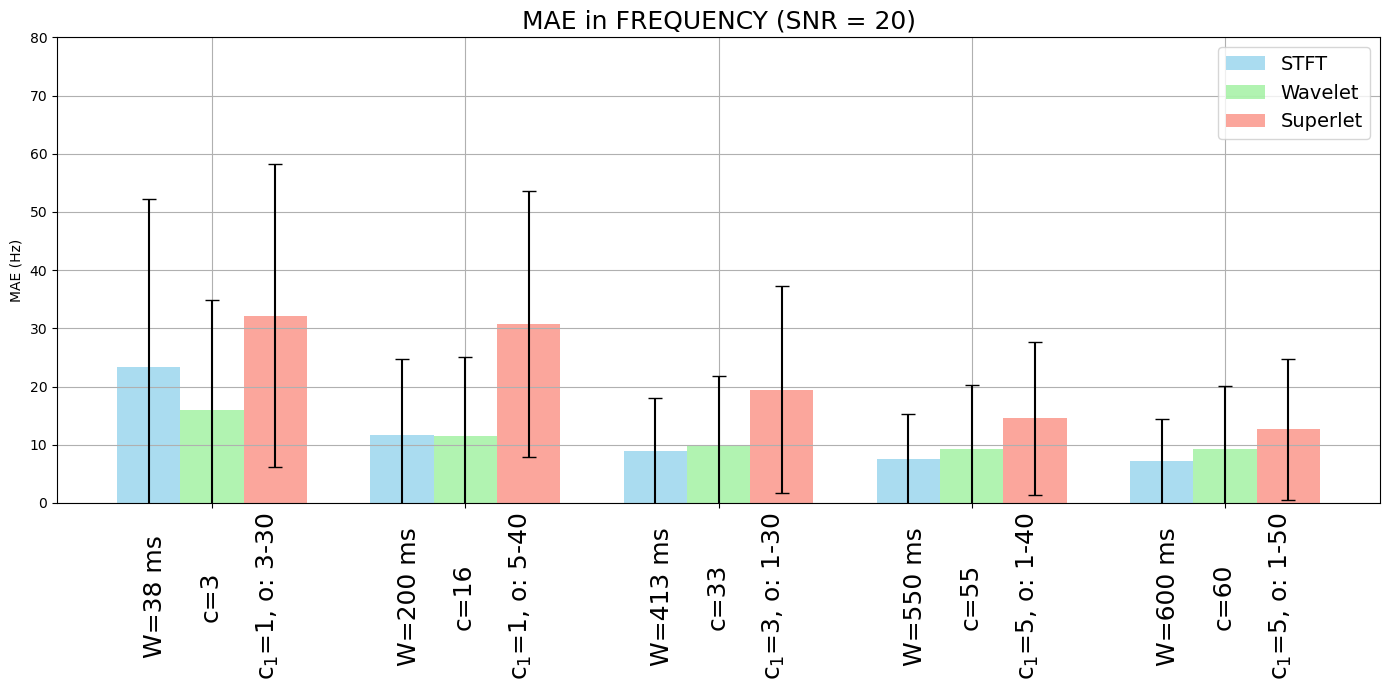

In [95]:
params_stft = windows_ms

# Número de condiciones
num_conditions = len(mae_wavelet_f)
x = np.arange(num_conditions)  # Posiciones para cada grupo de barras
bar_width = 0.25  # Ancho de las barras

# Crear el gráfico de barras
plt.figure(figsize=(14, 7))

# Graficar cada técnica con sus valores y barras de error
plt.bar(x - bar_width, mae_stft_f, width=bar_width, yerr=std_stft_f, capsize=5, label='STFT', color='skyblue', alpha=0.7)
plt.bar(x, mae_wavelet_f, width=bar_width, yerr=std_wavelet_f, capsize=5, label='Wavelet', color='lightgreen', alpha=0.7)
plt.bar(x + bar_width, mae_superlet_f, width=bar_width, yerr=std_superlet_f, capsize=5, label='Superlet', color='salmon', alpha=0.7)

# Configuración de etiquetas en el eje x con los parámetros específicos
labels = [
    f"W={p_stft} ms\n\nc={p_w}\n\nc$_1$={p_s[0]}, o: {p_s[1]}-{p_s[2]}"
    for p_w, p_s, p_stft in zip(params_wavelet, zip(*params_superlet), params_stft)
]

plt.xticks(x, labels, rotation=90, ha='center', fontsize=18)
#plt.xlabel('Condiciones y Parámetros')
plt.yticks(np.arange(0, 81, 10))

plt.ylabel('MAE (Hz)')
plt.title('MAE in FREQUENCY (SNR = ' + str(SNR) +')', fontsize=18)
plt.ylim(0,80)
plt.legend(fontsize=14)
plt.grid(True)

# Ajustar el layout para mejorar visualización de etiquetas
plt.tight_layout()

# Mostrar el gráfico
plt.show()

# MAE IN TIME

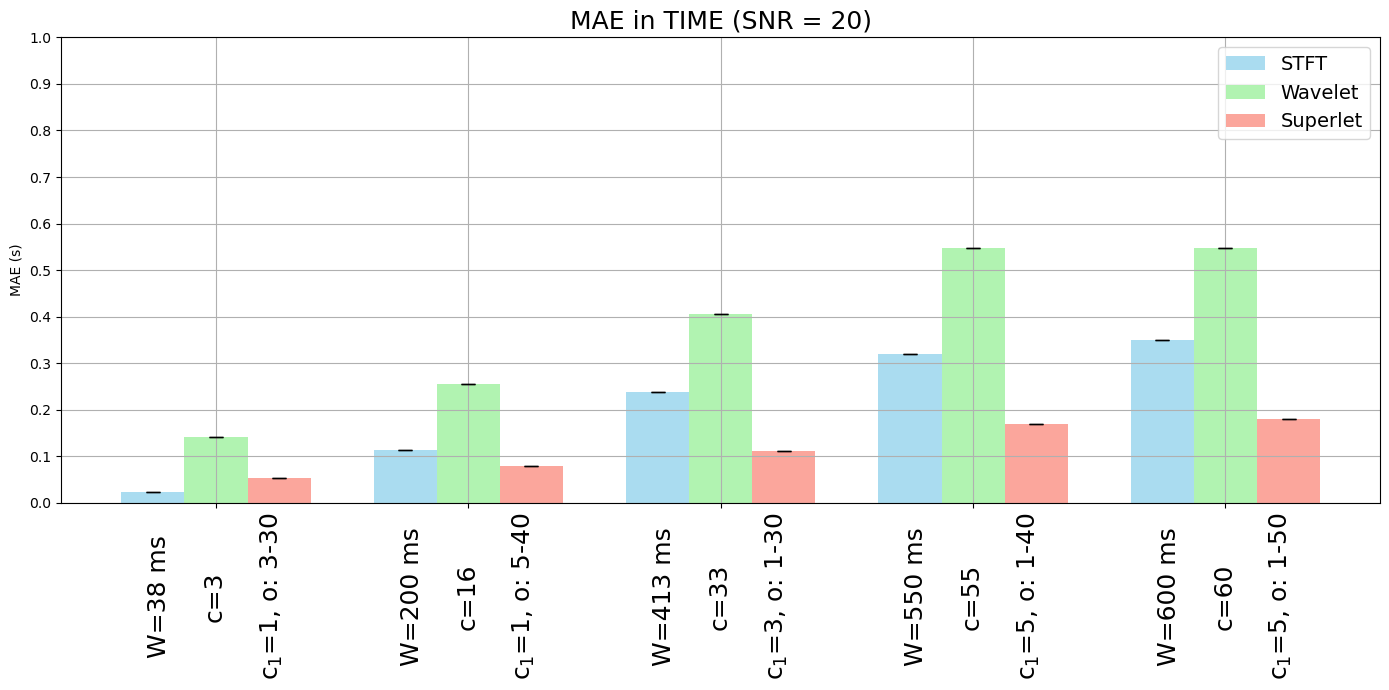

In [96]:
params_stft = windows_ms

# Número de condiciones
num_conditions = len(mae_wavelet_t)
x = np.arange(num_conditions)  # Posiciones para cada grupo de barras
bar_width = 0.25  # Ancho de las barras

# Crear el gráfico de barras
plt.figure(figsize=(14, 7))

# Graficar cada técnica con sus valores y barras de error
plt.bar(x - bar_width, mae_stft_t, width=bar_width, yerr=std_stft_t, capsize=5, label='STFT', color='skyblue', alpha=0.7)
plt.bar(x, mae_wavelet_t, width=bar_width, yerr=std_wavelet_t, capsize=5, label='Wavelet', color='lightgreen', alpha=0.7)
plt.bar(x + bar_width, mae_superlet_t, width=bar_width, yerr=std_superlet_t, capsize=5, label='Superlet', color='salmon', alpha=0.7)

# Configuración de etiquetas en el eje x con los parámetros específicos
labels = [
    f"W={p_stft} ms\n\nc={p_w}\n\nc$_1$={p_s[0]}, o: {p_s[1]}-{p_s[2]}"
    for p_w, p_s, p_stft in zip(params_wavelet, zip(*params_superlet), params_stft)
]

plt.xticks(x, labels, rotation=90, ha='center', fontsize=18)
#plt.xlabel('Condiciones y Parámetros')
plt.yticks(np.arange(0, 1.1, 0.1))

plt.ylabel('MAE (s)')
plt.title('MAE in TIME (SNR = ' + str(SNR) +')', fontsize=18)
plt.ylim(0,1)
plt.legend(fontsize=14)
plt.grid(True)

# Ajustar el layout para mejorar visualización de etiquetas
plt.tight_layout()

# Mostrar el gráfico
plt.show()

# COMPUTE RESOLUTION

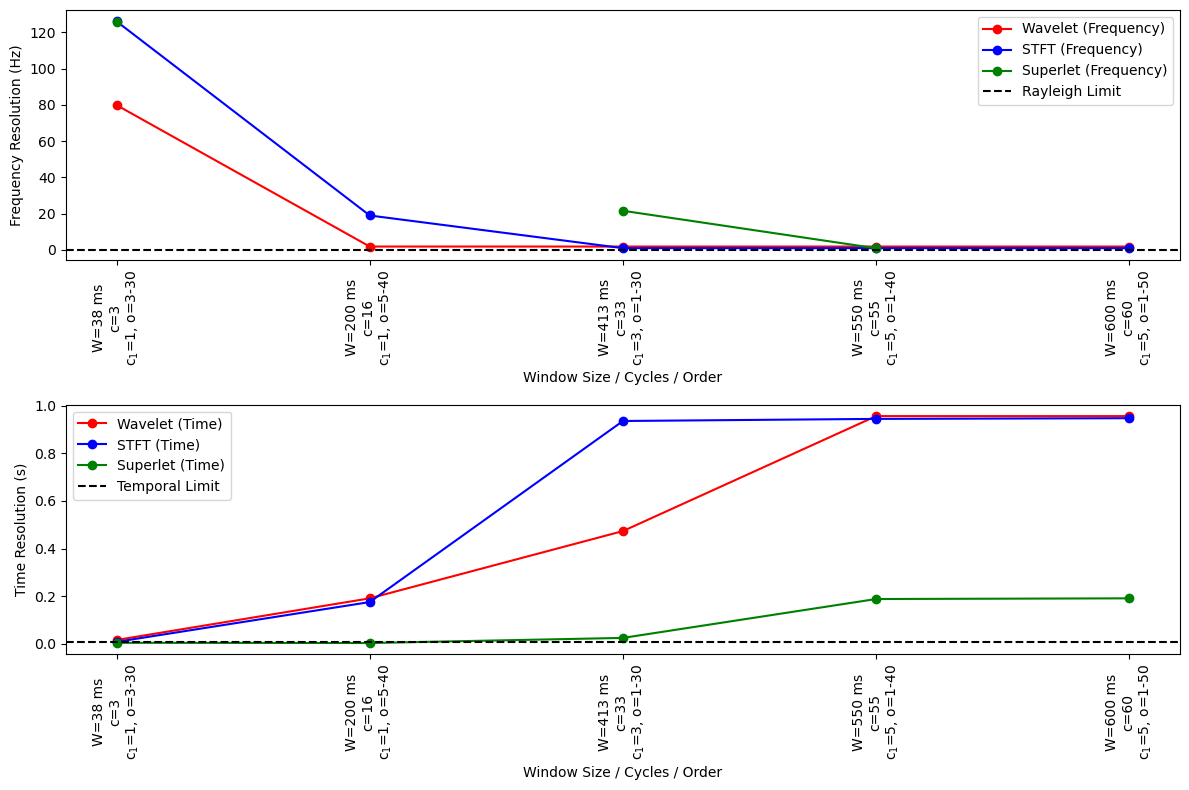

In [97]:
rayleigh_limit = 1 / (4 * np.pi)

# Etiquetas para los grupos de parámetros con salto de línea adicional
labels = [
    f"W={p_stft} ms\nc={p_wavelet}\nc$_1$={p_superlet[0]}, o={p_superlet[1]}-{p_superlet[2]}"
    for p_wavelet, p_superlet, p_stft in zip(params_wavelet, zip(*params_superlet), params_stft)
]

x = np.arange(1,len(params_wavelet)+1)

plt.figure(figsize=(12, 8))

# Primer gráfico (Frecuencia)
plt.subplot(2, 1, 1)
plt.plot(x, [r[1] for r in res_wavelet], 'ro-', label="Wavelet (Frequency)")
plt.plot(x, [r[1] for r in res_stft], 'bo-', label="STFT (Frequency)")
plt.plot(x, [r[1] for r in res_superlet], 'go-', label="Superlet (Frequency)")
plt.axhline(rayleigh_limit, color='k', linestyle='--', label="Rayleigh Limit")
plt.xlabel("Window Size / Cycles / Order")
plt.ylabel("Frequency Resolution (Hz)")
plt.legend()

# Segundo gráfico (Tiempo)
plt.subplot(2, 1, 2)
plt.plot(x, [r[0] for r in res_wavelet], 'ro-', label="Wavelet (Time)")
plt.plot(x, [r[0] for r in res_stft], 'bo-', label="STFT (Time)")
plt.plot(x, [r[0] for r in res_superlet], 'go-', label="Superlet (Time)")
plt.axhline(1 / MNF_1[0], color='k', linestyle='--', label="Temporal Limit")
plt.xlabel("Window Size / Cycles / Order")
plt.ylabel("Time Resolution (s)")
plt.legend()

# Ajuste de los xticks para ambos subgráficos
for ax in plt.gcf().get_axes():
    ax.set_xticks(x)  # Establecer los valores de los ticks
    ax.set_xticklabels(labels, rotation=90, ha='center', fontsize=10)  # Establecer las etiquetas con el formato deseado

# Ajustar el diseño
plt.tight_layout()
plt.show()

In [98]:
MAES_f

{'stft': [[22.530875657097674,
   19.289450140048412,
   22.675800131108446,
   24.541010741511904,
   25.17661979955852]],
 'wavelet': [[15.64814321524861,
   11.101279218570447,
   9.68108190701195,
   9.08820245867263,
   9.011226312744395]],
 'superlet': [[30.081214482127695,
   29.138050260324324,
   19.0028058171785,
   14.088466837112083,
   12.310894528417391]],
 'std_stft': [[24.56366482976366,
   8.9751815213521,
   6.2258645826994226,
   5.6832097384465285,
   5.581390745071735]],
 'std_wavelet': [[18.538966664387907,
   13.463444140710408,
   11.861692191679152,
   10.94015859988438,
   10.811468060454782]],
 'std_superlet': [[24.535394863101093,
   21.788594113642787,
   17.517704174529143,
   12.913408861393998,
   11.973732313476047]]}

In [99]:
MAES_f['wavelet'].append(mae_wavelet_f)
MAES_f['stft'].append(mae_stft_f)
MAES_f['superlet'].append(mae_superlet_f)
MAES_f['std_wavelet'].append(std_wavelet_f)
MAES_f['std_stft'].append(std_stft_f)
MAES_f['std_superlet'].append(std_superlet_f)

In [100]:
MAES_t

{'stft': [[0.00846629762292439,
   0.03060892217518707,
   0.08629111038749593,
   0.1204819277108431,
   0.13318137414522946]],
 'wavelet': [[0.006186909801367602,
   0.014001953760989672,
   0.01790947574080093,
   0.021816997720612186,
   0.023770758710517814]],
 'superlet': [[0.00814067079127323,
   0.01107131227613145,
   0.014978834255942708,
   0.03647020514490418,
   0.04135460761966758]],
 'std_stft': [[0.0, 0.0, 0.0, 0.0, 0.0]],
 'std_wavelet': [[0.0, 0.0, 0.0, 0.0, 0.0]],
 'std_superlet': [[0.0, 0.0, 0.0, 0.0, 0.0]]}

In [101]:
MAES_t['wavelet'].append(mae_wavelet_t)
MAES_t['stft'].append(mae_stft_t)
MAES_t['superlet'].append(mae_superlet_t)
MAES_t['std_wavelet'].append(std_wavelet_t)
MAES_t['std_stft'].append(std_stft_t)
MAES_t['std_superlet'].append(std_superlet_t)

### WE REPEAT EVERYTHING WITH DIFFERENT SNR

## We reset the signal

In [102]:
plot_1 = False
plot_2 = False

Reference mean frequency: [110.97685447552273] Hz


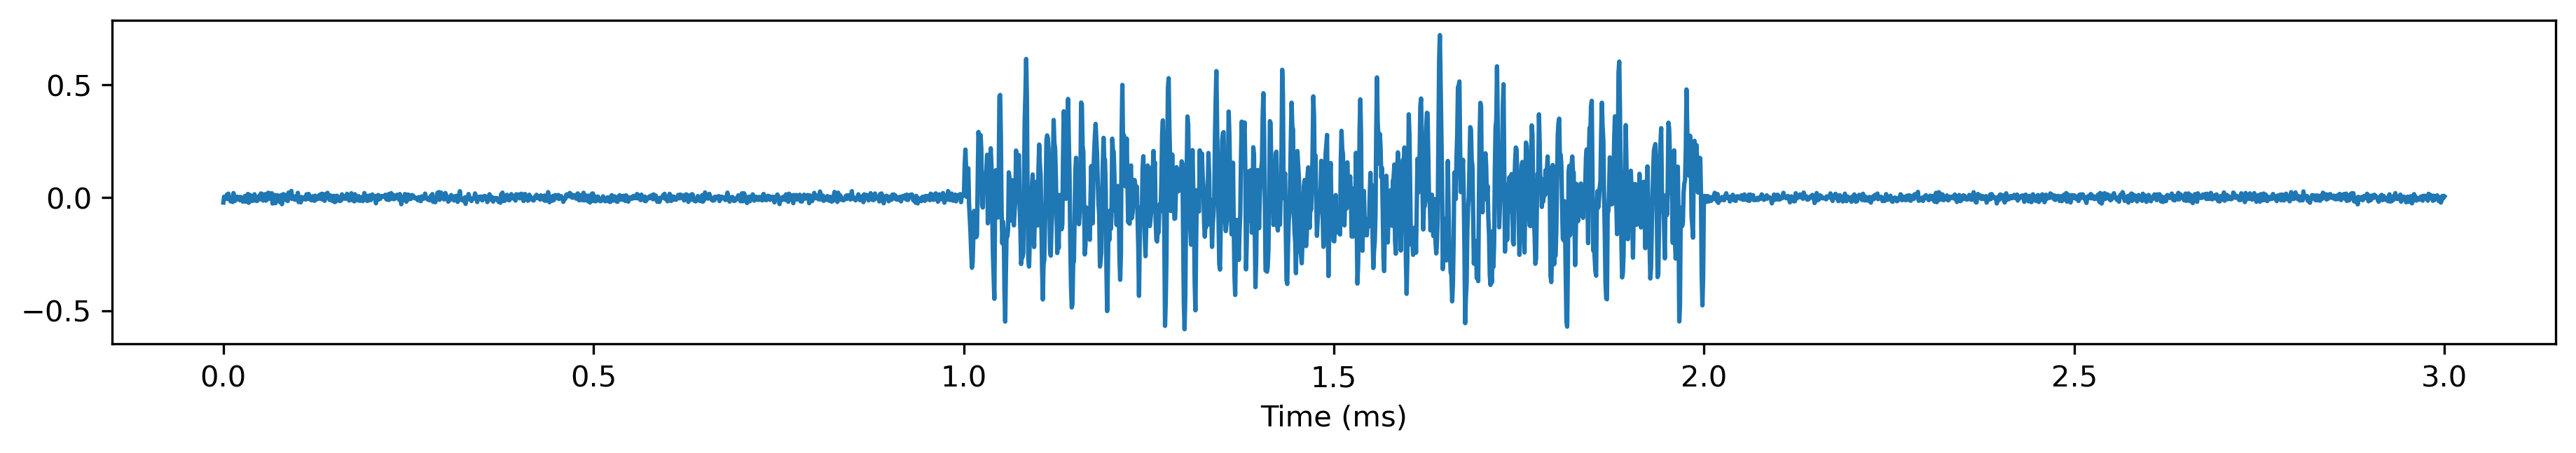

In [103]:
signal = baseline_1
fig, ax = plt.subplots(figsize=(15, 2), dpi=300)
ax.set_xlabel("Time (ms)")
ax.plot(jnp.linspace(0, len(signal) / fs, len(signal)), signal)
print(f"Reference mean frequency: {MNF_1} Hz")

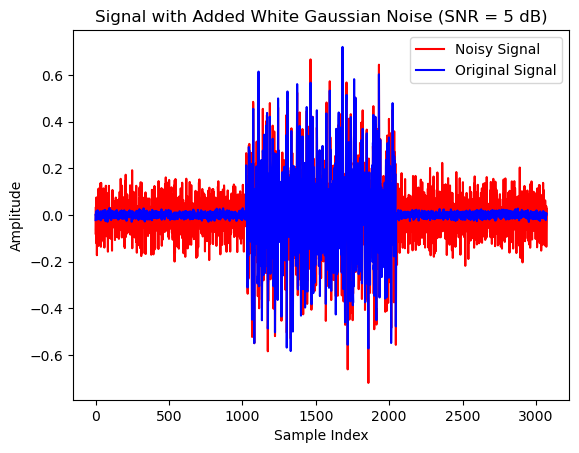

In [104]:
SNR = 5
#signal_noise = add_noise(baseline_1, SNR, plot = True)
signal_noise = add_noise(signal, SNR, plot=True)
#signal_noise = add_wgn_to_sig(baseline_1, noise, SNR)
signal = signal_noise

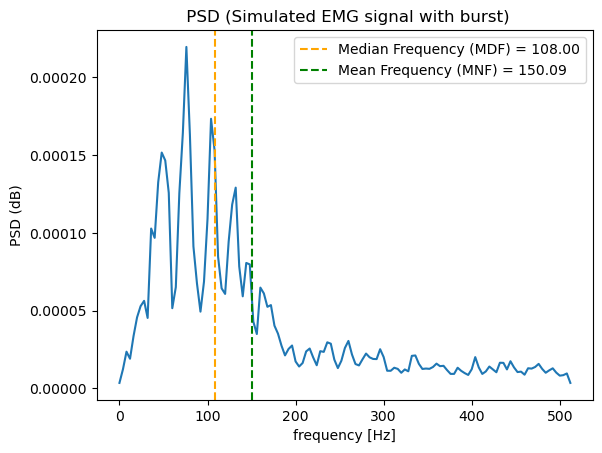

In [105]:
psd_welch, f_welch, MNF = superlet.compute_psd_welch(signal, fs, plot=True, muscle='Simulated EMG signal with burst')

In [106]:
MNF_1

[110.97685447552273]

Reference mean frequency: [110.97685447552273] Hz


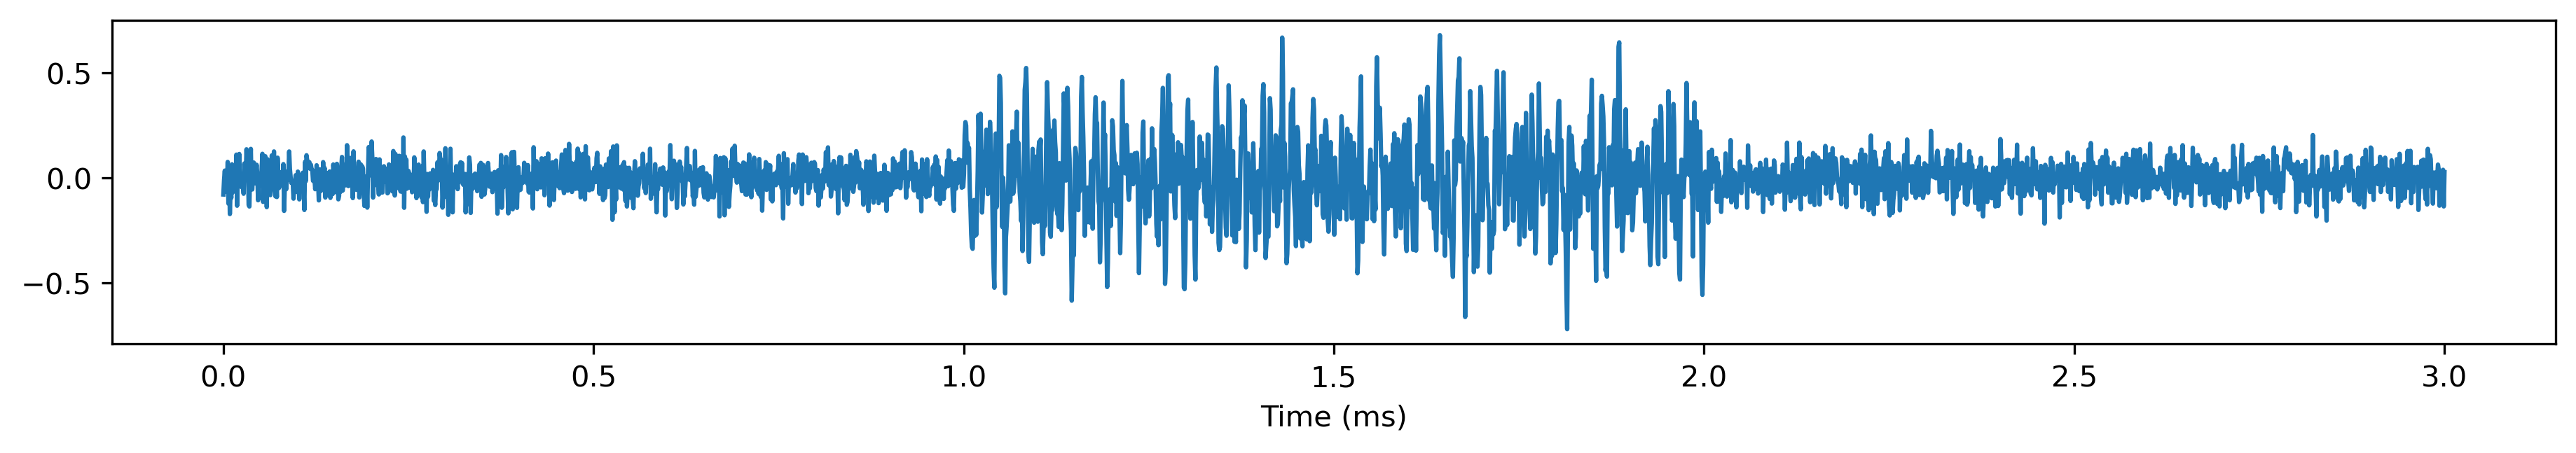

In [107]:
fig, ax = plt.subplots(figsize=(15, 2), dpi=300)
ax.set_xlabel("Time (ms)")
ax.plot(jnp.linspace(0, len(signal) / fs, len(signal)), signal)
print(f"Reference mean frequency: {MNF_1} Hz")

## WAVELET PARAMETERS = 3, 16, 33, 55, 60, 115 cycles

In [ ]:
importlib.reload(superlet)

In [ ]:
if plot_1:
    fig, ax = plt.subplots(ncols=len(params_wavelet), figsize=(18, 5), dpi=300)
if plot_2:
    fig_2, ax_2 = plt.subplots(ncols=len(params_wavelet), figsize=(18, 5), dpi=300)
    fig_3, ax_3 = plt.subplots(figsize=(10, 6))

mae_wavelet_f = []
std_wavelet_f = []

mae_wavelet_t = []
std_wavelet_t = []

total_time = []
total_freq = []

total_scalogram_wavelet = []
res_wavelet = []

# Iterar sobre los parámetros de wavelet
for i, c in enumerate(params_wavelet):
    wavelet = f"cmor{c}-1.0"

    cwtmatr, f, physical_freqs = morlet.wavelet_transform_2(signal,wavelet,freqs,fs)
    cwtmatr = np.abs(cwtmatr[:, :])
    
    if save:
        df = pd.DataFrame(cwtmatr)
    
        # Guardar en un archivo CSV
        filename = os.path.join(new_folder_path, str(SNR) + "dB_wv_" + str(c) + ".csv")
        df.to_csv(filename, index=False, header=False)  # Sin índices ni encabezados
    
    scalogram_2 = jnp.abs(cwtmatr)**2

    if plot_1:
        pcm = ax[i].pcolormesh(t,f, scalogram_2, shading='gouraud', cmap='jet')
        
        ax[i].set_title(f'c={c}')
        ax[i].set_ylabel('Frecuencia [Hz]')
        ax[i].set_xlabel('Tiempo [s]')
        
        cbar = fig.colorbar(pcm, ax=ax[i], orientation='horizontal')
        cbar.set_label('Power', rotation=0, labelpad=15)  # Etiqueta de la colorbar
    
        ax[i].set_ylim(freqs[0], freqs[-1])  # Ajustar el rango de frecuencias si es necesario
        plt.tight_layout()

    total_scalogram_wavelet.append(scalogram_2)
    instant_mean_freq_total = []

    instant_freq = np.sum(scalogram_2 * f[:, np.newaxis], axis=0) / np.sum(scalogram_2, axis=0)
    if plot_means:
        plt.figure()
        plt.plot(instant_freq)
        plt.title('Frecuencia instantánea')

    sigma = 15 # Desviación estándar del filtro PARA SNR = INF
    y_smooth = gaussian_filter1d(instant_freq, sigma)

    # VALOR MEDIO EN UNA VENTANA DESLIZANTE
    window_size = 50
    window = np.ones(window_size) / window_size  # Ventana normalizada

    # Calcular la media móvil con convolución
    media_movil = np.convolve(y_smooth, window, mode='same')    
    if plot_means:
        plt.figure()
        plt.plot(media_movil, color = 'red')
        plt.title('Media de la señal')
    
    # Derivada de la media para ver el cambio en el valor medio de la señal
    slope_gradient = np.gradient(media_movil, t)
    if plot_means:
        plt.figure()
        plt.plot(slope_gradient, color = 'green')
        plt.title('Gradiente de la media de la señal')
    
    # Coger la porción de la señal del medio    
    time_range = len(slope_gradient)//2
    time_shift = round(burst_duration_1 * 0.9 * fs)
    inicio = time_range-time_shift
    
    first_index = np.argmin(slope_gradient[inicio:time_range]) + inicio
    last_index = np.argmax(slope_gradient[time_range:time_range+time_shift]) + time_range 
    
    t_onset = t[first_index]
    t_offset = t[last_index]
    
    start_idx = np.searchsorted(t, burst_start_1)  # Encuentra el índice de inicio
    end_idx = np.searchsorted(t, burst_start_1 + burst_duration_1)  # Encuentra el índice final

    instant_mean_freq_burst = instant_freq[start_idx:end_idx]

    if plot_2:
        ax_2[i].plot(t, y_smooth)

        ax_2[i].set_xlabel("Time (s)")
        ax_2[i].set_ylabel("Frequency (Hz)")
        #ax_2[i].set_xlim(t[0], t[-1])
        #plt.title("Medias de cada fila en función del tiempo")
        ax_2[i].grid(True)

        ax_3.plot(t, instant_freq, label=f"Mean frequency (Cycles: {c})")
        plt.tight_layout()

    #MAE in frequency
    print(f'Estimated mean frequency {np.mean(instant_mean_freq_burst)} Hz')
    mae_f, std_f = calculate_mae(instant_mean_freq_burst, MNF_1)
    mae_wavelet_f.append(mae_f)
    std_wavelet_f.append(std_f)
    
    #MAE in time
    print(f'Estimated onset = {t_onset} s, offset = {t_offset} s')
    estimates_combined = t_offset - t_onset
    print(f' Estimated difference {estimates_combined} s')
    true_values_combined = t_offset_1 - t_onset_1
    print(f'Real difference {true_values_combined} s')

    mae_t, std_t = calculate_mae(estimates_combined, true_values_combined)
    mae_wavelet_t.append(mae_t)
    std_wavelet_t.append(std_t)

    time = np.arange(scalogram_2.shape[1]) / fs

    total_time.append(time)
    total_freq.append(freqs)
    
    # Visualization
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(t, instant_freq)
    plt.plot(t,y_smooth)
    plt.axvline(t_onset, color='green', linestyle='--', label='t_onset')
    plt.axvline(t_offset, color='red', linestyle='--', label='t_offset')
    plt.xlabel('Time (s)')
    plt.ylabel('Freq (Hz)')
    plt.legend()
    plt.grid()
    
    # Slopes and t_onset and t_offset
    plt.subplot(2, 1, 2)
    plt.plot(t, slope_gradient, 'g-', label='Local slope (np.gradient)')
    plt.axvline(t_onset, color='green', linestyle='--', label='Start of the first positive slope')
    plt.axvline(t_offset, color='red', linestyle='--', label='End of the final negative slope')
    plt.xlabel('Time (s)')
    plt.ylabel('Slope')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Configuración del gráfico
if plot_2:
    ax_3.set_xlabel("Time (s)")
    ax_3.set_ylabel("Frequency (Hz)")
    ax_3.legend()
    ax_3.grid(True)
    ax_3.set_title("Comparación de frecuencias medias instantáneas")

res_wavelet = superlet.compute_avg_response_resolution(total_scalogram_wavelet, total_time, total_freq, params_wavelet)

In [ ]:
mae_wavelet_f

In [ ]:
mae_wavelet_t

## PARÁMETROS SUPERLET: base_cycle, min_order, max_order = [3, 5, 1, 1, 1, 1], [1, 1, 5, 10, 20, 30], [30, 30, 40, 100, 100, 200]

In [ ]:
importlib.reload(superlet)

In [ ]:
if plot_1:
    fig, ax = plt.subplots(ncols=len(params_superlet[0]), figsize=(15, 5), dpi=300)

if plot_2:
    fig_2, ax_2 = plt.subplots(ncols=len(params_superlet[0]), figsize=(15, 5), dpi=300)
    fig_3, ax_3 = plt.subplots(figsize=(10, 6))

mae_superlet_f = []
std_superlet_f = []

mae_superlet_t = []
std_superlet_t = []

total_time = []
total_freq = []

total_scalogram_superlet = []

for (i, (base_cycle, min_order, max_order)) in enumerate(zip(*params_superlet)):

    wv, scalogram = superlet.adaptive_superlet_transform(signal, freqs, sampling_freq=fs,
                                                         base_cycle=base_cycle, min_order=min_order,
                                                         max_order=max_order, mode="mul")
    
    if plot_1:
        im = ax[i].imshow(jnp.abs(scalogram) ** 2, aspect='auto', cmap="jet", interpolation="none", origin="lower",extent=[0, len(signal) / fs, freqs[0], freqs[-1]])
        ax[i].set_title(f"$c_1$: {base_cycle}, o: {min_order}-{max_order}")
        ax[i].set_xlabel("Time (s)")
        ax[i].set_ylabel("Frequency (Hz)")

        cbar = fig.colorbar(im, ax=ax[i], orientation='horizontal')
        cbar.set_label('Power [a.u]', rotation=0, labelpad=15)  # Etiqueta de la colorbar
        plt.tight_layout()

    scalogram_2 = np.abs(scalogram) ** 2
    
    if save:
        df = pd.DataFrame(scalogram_2)
    
        # Guardar en un archivo CSV
        filename = os.path.join(new_folder_path,str(SNR) + "dB_superlet_" + str(base_cycle) + "-" + str(min_order) + "-" + str(max_order) + ".csv")
        df.to_csv(filename, index=False, header=False)  # Sin índices ni encabezados

    instant_mean_freq_total = []
    total_scalogram_superlet.append(scalogram_2)
    
    instant_freq = np.sum(scalogram_2 * freqs[:, np.newaxis], axis=0) / np.sum(scalogram_2, axis=0)
    if plot_means:
        plt.figure()
        plt.plot(instant_freq)
        plt.title('Frecuencia instantánea')
    
    # Mismo SIGMA que para la wavelet
    sigma = 50
    y_smooth = gaussian_filter1d(instant_freq, sigma)

    # Misms WINDOW_SIZE que para la wavelet
    window = np.ones(window_size) / window_size  # Ventana normalizada

    # Calcular la media móvil con convolución
    media_movil = np.convolve(y_smooth, window, mode='same')   
    if plot_means:
        plt.figure()
        plt.plot(media_movil, color = 'red')
        plt.title('Media de la señal')
    
    # Derivada de la media para ver el cambio en el valor medio de la señal
    slope_gradient = np.gradient(media_movil, t)
    if plot_means:
        plt.figure()
        plt.plot(slope_gradient, color = 'green')
        plt.title('Gradiente de la media de la señal')
    
    # Coger la porción de la señal del medio    
    time_range = len(slope_gradient)//2
    time_shift = round(burst_duration_1 * 0.7 * fs)
    inicio = time_range-time_shift
    
    first_index = np.argmin(slope_gradient[inicio:time_range]) + inicio
    last_index = np.argmax(slope_gradient[time_range:time_range+time_shift]) + time_range 
    
    t_onset = t[first_index]
    t_offset = t[last_index]    

    initial_imnf = instant_freq[:round(burst_start_1 * fs) - offset]
    instant_mean_freq_total.extend(initial_imnf)
    # plt.figure()
    # plt.plot(initial_imnf)

    instant_mean_freq_burst = instant_freq[
                              round(burst_start_1 * fs):round((burst_start_1 + burst_duration_1) * fs)]
    instant_mean_freq_burst = instant_mean_freq_burst[offset_burst:round(len(instant_mean_freq_burst)) - offset_burst]
    instant_mean_freq_total.extend(instant_mean_freq_burst)

    final_imnf = instant_freq[round((burst_start_1 + burst_duration_1) * fs) + offset:]
    instant_mean_freq_total.extend(final_imnf)
    # plt.figure()
    # plt.plot(final_imnf)
    # plt.figure()
    # plt.plot(instant_mean_freq_total)

    if plot_2:
        ax_2[i].plot(t, instant_mean_freq_total,
                     label="Mean frequency (each window of " + str(len(freqs)) + ' samples)')

        ax_2[i].set_xlabel("Time (s)")
        ax_2[i].set_ylabel("Frequency (Hz)")
        #ax_2[i].set_xlim(tiempo[0], tiempo[-1])
        #plt.title("Medias de cada fila en función del tiempo")
        ax_2[i].legend()
        ax_2[i].grid(True)

        ax_3.plot(t, instant_mean_freq_total, label=f"Mean frequency (Cycles: {base_cycle})")

     #MAE in frequency
    print(f'Estiamted mean frequency {np.mean(instant_mean_freq_burst)} Hz')
    mae_f, std_f = calculate_mae(instant_mean_freq_burst, MNF_1)
    mae_superlet_f.append(mae_f)
    std_superlet_f.append(std_f)
    
    #MAE in time
    print(f'Estimated onset = {t_onset} s, offset = {t_offset} s')
    estimates_combined = t_offset - t_onset
    print(f'Estimated difference: {estimates_combined} s')
    true_values_combined = t_offset_1 - t_onset_1
    print(f'Real difference: {true_values_combined} s')

    mae_t, std_t = calculate_mae(estimates_combined, true_values_combined)
    mae_superlet_t.append(mae_t)
    std_superlet_t.append(std_t)

    time = np.arange(scalogram_2.shape[1]) / fs

    total_time.append(time)
    total_freq.append(freqs)

    total_time.append(t)
    total_freq.append(freqs)
    
    # Visualización
    plt.figure(figsize=(12, 6))
    
    # Gráfica original
    plt.subplot(2, 1, 1)
    plt.plot(t, instant_freq, label='Datos originales')
    plt.plot(t, y_smooth, label='Datos originales')
    plt.axvline(t_onset, color='green', linestyle='--', label='Inicio de la primera pendiente positiva')
    plt.axvline(t_offset, color='red', linestyle='--', label='Final de la última pendiente negativa')
    plt.title('Gráfica original y cálculo de pendientes')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid()
    
    # Gráfica de pendientes
    plt.subplot(2, 1, 2)
    plt.plot(t, slope_gradient, 'g-', label='Pendiente local (np.gradient)')
    plt.axvline(t_onset, color='green', linestyle='--', label='Inicio de la primera pendiente positiva')
    plt.axvline(t_offset, color='red', linestyle='--', label='Final de la última pendiente negativa')
    plt.xlabel('Time (s)')
    plt.ylabel('Slope')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

if plot_2:
    ax_3.set_xlabel("Time (s)")
    ax_3.set_ylabel("Frequency (Hz)")
    ax_3.legend()
    ax_3.grid(True)
    ax_3.set_title("Comparación de frecuencias medias instantáneas")

res_superlet = superlet.compute_avg_response_resolution(total_scalogram_superlet, total_time, total_freq, [f'$c_1$={c3}, o:{c1}-{c2}' for c1, c2, c3 in zip(*params_superlet)])

In [ ]:
mae_superlet_f

In [ ]:
mae_superlet_t

## STFT PARAMETERS (window = duration/cycles) = 38, 200, 413, 550, 600, 824 ms

In [ ]:
importlib.reload(superlet)

# Parámetros de la STFT con ventanas de 38 ms, 200 ms, y 413 ms (convertido a muestras)

In [ ]:
if plot_1:
    fig, ax = plt.subplots(ncols=len(windows_ms), figsize=(15, 5), dpi=300)

if plot_2:
    fig_2, ax_2 = plt.subplots(ncols=len(windows_ms), figsize=(15, 5), dpi=300)
    fig_3, ax_3 = plt.subplots(figsize=(10, 6))

mae_stft_f = []
std_stft_f = []

mae_stft_t = []
std_stft_t = []

total_time = []
total_freq = []

res_stft = []
total_scalogram_stft = []

for i, w in enumerate(windows_ms):
    # Calcular la ventana Blackman
    window = windows.blackman(w)
    
    # Hacer que la f de la stft tenga el mismo tamaño que las demás
    nfft = 2 * (len(freqs))
    
    f, t_stft, Zxx = stft(signal, fs=fs, window='blackman', nperseg=w, noverlap=w-1, nfft=nfft, detrend=False, return_onesided=True, boundary='zeros', padded=True, axis=-1, scaling='spectrum')
    
    # Calcular la representación de potencia (magnitud al cuadrado)
    Zxx_power = np.abs(Zxx) ** 2
    
    if plot_1:
        pcm = ax[i].pcolormesh(t_stft, f, Zxx_power, shading='gouraud', cmap='jet')
        
        ax[i].set_title(f'W={w * 1000 // fs} ms')
        ax[i].set_ylabel('Frecuencia [Hz]')
        ax[i].set_xlabel('Tiempo [s]')
        
        cbar = fig.colorbar(pcm, ax=ax[i], orientation='horizontal')
        cbar.set_label('Power', rotation=0, labelpad=15)  # Etiqueta de la colorbar
    
        #fig.colorbar(pcm, ax=ax[i], label='Potencia')
        ax[i].set_ylim(freqs[0], freqs[-1])  # Ajustar el rango de frecuencias si es necesario
        plt.tight_layout()
    
    scalogram_2 = Zxx_power
    
    if save:
        df = pd.DataFrame(scalogram_2)
    
        # Guardar en un archivo CSV
        filename = os.path.join(new_folder_path, str(SNR) + "dB_stft_" + str(w) + ".csv")
        df.to_csv(filename, index=False, header=False)  # Sin índices ni encabezados
        
    total_scalogram_stft.append(scalogram_2)
 
    instant_mean_freq_total = []  
    
    instant_freq = np.sum(scalogram_2 * f[:, np.newaxis], axis=0) / np.sum(scalogram_2, axis=0)
    if plot_means:
        plt.figure()
        plt.plot(instant_freq)
        plt.title('Frecuencia instantánea')
    
    # Probamos misma SIGMA que la wavelet y superlet
    sigma = 10
    y_smooth = gaussian_filter1d(instant_freq, sigma)
    
    # Mismo WINDOW_SIZE
    window = np.ones(window_size) / window_size  # Ventana normalizada

    # Calcular la media móvil con convolución
    media_movil = np.convolve(y_smooth, window, mode='same')
    if plot_means:
        plt.figure()
        plt.plot(media_movil, color = 'red')
        plt.title('Media de la señal')
    
    slope_gradient = np.gradient(media_movil, t_stft)
    if plot_means:
        plt.figure()
        plt.plot(slope_gradient, color = 'green')
        plt.title('Gradiente de la media de la señal')
    
    # Coger la porción de la señal del medio    
    time_range = len(slope_gradient)//2
    time_shift = round(burst_duration_1 * 1 * fs)
    inicio = time_range-time_shift
    
    first_index = np.argmin(slope_gradient[inicio:time_range]) + inicio
    last_index = np.argmax(slope_gradient[time_range:time_range+time_shift]) + time_range 
    
    t_onset = t_stft[first_index]
    t_offset = t_stft[last_index]
    
    start_idx = np.searchsorted(t_stft, burst_start_1)  # Encuentra el índice de inicio
    end_idx = np.searchsorted(t_stft, burst_start_1 + burst_duration_1)  # Encuentra el índice final

    instant_mean_freq_burst = instant_freq[start_idx:end_idx]
   
    if plot_2:
        ax_2[i].plot(t_stft, instant_mean_freq_total, label="Mean frequency (each window of " + str(len(freqs)) + ' samples)')
        
        ax_2[i].set_xlabel("Time (s)")
        ax_2[i].set_ylabel("Frequency (Hz)")
        #ax_2[i].set_xlim(tiempo[0], tiempo[-1])
        #plt.title("Medias de cada fila en función del tiempo")
        ax_2[i].legend()
        ax_2[i].grid(True)
        
        ax_3.plot(t_stft, instant_mean_freq_total, label=f"Mean frequency (Cycles: {w})")
    
    #MAE in frequency
    print(f'Estimated mean frequency = {np.mean(instant_mean_freq_burst)} Hz')
    mae_f, std_f = calculate_mae(instant_mean_freq_burst, MNF_1)
    mae_stft_f.append(mae_f)
    std_stft_f.append(std_f)
    
    #MAE in time
    print(f'Estimated onset = {t_onset} s, offset = {t_offset} s')
    estimates_combined = t_offset - t_onset
    print(f'Estimated difference: {estimates_combined} s')
    true_values_combined = t_offset_1 - t_onset_1
    print(f'Real difference: {true_values_combined} s')

    mae_t, std_t = calculate_mae(estimates_combined, true_values_combined)
    mae_stft_t.append(mae_t)
    std_stft_t.append(std_t)
    
    total_time.append(np.linspace(t_stft[0], t_stft[-1], scalogram_2.shape[1]))
    total_freq.append(np.linspace(f[0], f[-1], scalogram_2.shape[0]))
    
    # Visualization
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(t_stft, instant_freq)
    plt.plot(t_stft, y_smooth)
    plt.axvline(t_onset, color='green', linestyle='--', label='t_onset')
    plt.axvline(t_offset, color='red', linestyle='--', label='t_offset')
    plt.xlabel('Time (s)')
    plt.ylabel('Freq (Hz)')
    plt.legend()
    plt.grid()
    
    # Slopes and t_onset and t_offset
    plt.subplot(2, 1, 2)
    plt.plot(t_stft, slope_gradient, 'g-', label='Local slope (np.gradient)')
    plt.axvline(t_onset, color='green', linestyle='--', label='Start of the first positive slope')
    plt.axvline(t_offset, color='red', linestyle='--', label='End of the final negative slope')
    plt.xlabel('Time (s)')
    plt.ylabel('Slope')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Configuración del gráfico
if plot_2:
    ax_3.set_xlabel("Time (s)")
    ax_3.set_ylabel("Frequency (Hz)")
    ax_3.legend()
    ax_3.grid(True)
    ax_3.set_title("Comparación de frecuencias medias instantáneas")
        
res_stft = superlet.compute_avg_response_resolution(total_scalogram_stft, total_time, total_freq, windows_ms, stft=[freqs[0],freqs[-1]])

In [ ]:
mae_stft_f

In [ ]:
mae_stft_t

### Plot comparison of the same SNR

# MAE IN FREQUENCY

In [ ]:
params_stft = windows_ms

# Número de condiciones
num_conditions = len(mae_wavelet_f)
x = np.arange(num_conditions)  # Posiciones para cada grupo de barras
bar_width = 0.25  # Ancho de las barras

# Crear el gráfico de barras
plt.figure(figsize=(14, 7))

# Graficar cada técnica con sus valores y barras de error
plt.bar(x - bar_width, mae_stft_f, width=bar_width, yerr=std_stft_f, capsize=5, label='STFT', color='skyblue', alpha=0.7)
plt.bar(x, mae_wavelet_f, width=bar_width, yerr=std_wavelet_f, capsize=5, label='Wavelet', color='lightgreen', alpha=0.7)
plt.bar(x + bar_width, mae_superlet_f, width=bar_width, yerr=std_superlet_f, capsize=5, label='Superlet', color='salmon', alpha=0.7)

# Configuración de etiquetas en el eje x con los parámetros específicos
labels = [
    f"W={p_stft} ms\n\nc={p_w}\n\nc$_1$={p_s[0]}, o: {p_s[1]}-{p_s[2]}"
    for p_w, p_s, p_stft in zip(params_wavelet, zip(*params_superlet), params_stft)
]

plt.xticks(x, labels, rotation=90, ha='center', fontsize=18)
#plt.xlabel('Condiciones y Parámetros')
plt.yticks(np.arange(0, 81, 10))

plt.ylabel('MAE (Hz)')
plt.title('MAE in FREQUENCY (SNR = ' + str(SNR) +')', fontsize=18)
plt.ylim(0,80)
plt.legend(fontsize=14)
plt.grid(True)

# Ajustar el layout para mejorar visualización de etiquetas
plt.tight_layout()

# Mostrar el gráfico
plt.show()

# MAE IN TIME

In [ ]:
params_stft = windows_ms

# Número de condiciones
num_conditions = len(mae_wavelet_t)
x = np.arange(num_conditions)  # Posiciones para cada grupo de barras
bar_width = 0.25  # Ancho de las barras

# Crear el gráfico de barras
plt.figure(figsize=(14, 7))

# Graficar cada técnica con sus valores y barras de error
plt.bar(x - bar_width, mae_stft_t, width=bar_width, yerr=std_stft_t, capsize=5, label='STFT', color='skyblue', alpha=0.7)
plt.bar(x, mae_wavelet_t, width=bar_width, yerr=std_wavelet_t, capsize=5, label='Wavelet', color='lightgreen', alpha=0.7)
plt.bar(x + bar_width, mae_superlet_t, width=bar_width, yerr=std_superlet_t, capsize=5, label='Superlet', color='salmon', alpha=0.7)

# Configuración de etiquetas en el eje x con los parámetros específicos
labels = [
    f"W={p_stft} ms\n\nc={p_w}\n\nc$_1$={p_s[0]}, o: {p_s[1]}-{p_s[2]}"
    for p_w, p_s, p_stft in zip(params_wavelet, zip(*params_superlet), params_stft)
]

plt.xticks(x, labels, rotation=90, ha='center', fontsize=18)
#plt.xlabel('Condiciones y Parámetros')
plt.yticks(np.arange(0, 1.1, 0.1))

plt.ylabel('MAE (s)')
plt.title('MAE in TIME (SNR = ' + str(SNR) +')', fontsize=18)
plt.ylim(0,1)
plt.legend(fontsize=14)
plt.grid(True)

# Ajustar el layout para mejorar visualización de etiquetas
plt.tight_layout()

# Mostrar el gráfico
plt.show()

# COMPUTE RESOLUTION

In [ ]:
rayleigh_limit = 1 / (4 * np.pi)

# Etiquetas para los grupos de parámetros con salto de línea adicional
labels = [
    f"W={p_stft} ms\nc={p_wavelet}\nc$_1$={p_superlet[0]}, o={p_superlet[1]}-{p_superlet[2]}"
    for p_wavelet, p_superlet, p_stft in zip(params_wavelet, zip(*params_superlet), params_stft)
]

x = np.arange(1,len(params_wavelet)+1)

plt.figure(figsize=(12, 8))

# Primer gráfico (Frecuencia)
plt.subplot(2, 1, 1)
plt.plot(x, [r[1] for r in res_wavelet], 'ro-', label="Wavelet (Frequency)")
plt.plot(x, [r[1] for r in res_stft], 'bo-', label="STFT (Frequency)")
plt.plot(x, [r[1] for r in res_superlet], 'go-', label="Superlet (Frequency)")
plt.axhline(rayleigh_limit, color='k', linestyle='--', label="Rayleigh Limit")
plt.xlabel("Window Size / Cycles / Order")
plt.ylabel("Frequency Resolution (Hz)")
plt.legend()

# Segundo gráfico (Tiempo)
plt.subplot(2, 1, 2)
plt.plot(x, [r[0] for r in res_wavelet], 'ro-', label="Wavelet (Time)")
plt.plot(x, [r[0] for r in res_stft], 'bo-', label="STFT (Time)")
plt.plot(x, [r[0] for r in res_superlet], 'go-', label="Superlet (Time)")
plt.axhline(1 / MNF_1[0], color='k', linestyle='--', label="Temporal Limit")
plt.xlabel("Window Size / Cycles / Order")
plt.ylabel("Time Resolution (s)")
plt.legend()

# Ajuste de los xticks para ambos subgráficos
for ax in plt.gcf().get_axes():
    ax.set_xticks(x)  # Establecer los valores de los ticks
    ax.set_xticklabels(labels, rotation=90, ha='center', fontsize=10)  # Establecer las etiquetas con el formato deseado

# Ajustar el diseño
plt.tight_layout()
plt.show()

In [ ]:
MAES_f

In [ ]:
MAES_f['wavelet'].append(mae_wavelet_f)
MAES_f['stft'].append(mae_stft_f)
MAES_f['superlet'].append(mae_superlet_f)
MAES_f['std_wavelet'].append(std_wavelet_f)
MAES_f['std_stft'].append(std_stft_f)
MAES_f['std_superlet'].append(std_superlet_f)

In [ ]:
MAES_t

In [ ]:
MAES_t['wavelet'].append(mae_wavelet_t)
MAES_t['stft'].append(mae_stft_t)
MAES_t['superlet'].append(mae_superlet_t)
MAES_t['std_wavelet'].append(std_wavelet_t)
MAES_t['std_stft'].append(std_stft_t)
MAES_t['std_superlet'].append(std_superlet_t)

### COMPARISON BETWEEN ALL SNR

# COMPARISON OF MAE IN FREQUENCY

In [ ]:
params_wavelet = params_wavelet
params_superlet = params_superlet
params_stft = windows_ms  # Tamaños de ventana en ms

# Datos MAE para cada técnica y SNR
mae_stft = MAES_f['stft']
std_stft = MAES_f['std_stft']

mae_wavelet = MAES_f['wavelet']
std_wavelet = MAES_f['std_wavelet']

mae_superlet = MAES_f['superlet']
std_superlet = MAES_f['std_superlet']

# Reordenar los niveles de SNR al orden deseado: 5 dB, 20 dB, Sin SNR
snr_labels = ["5 dB", "20 dB", "Inf"]
mae_stft_2 = [mae_stft[2], mae_stft[1], mae_stft[0]]
std_stft_2 = [std_stft[2], std_stft[1], std_stft[0]]

mae_wavelet_2 = [mae_wavelet[2], mae_wavelet[1], mae_wavelet[0]]
std_wavelet_2 = [std_wavelet[2], std_wavelet[1], std_wavelet[0]]

mae_superlet_2 = [mae_superlet[2], mae_superlet[1], mae_superlet[0]]
std_superlet_2 = [std_superlet[2], std_superlet[1], std_superlet[0]]

# Configuración del gráfico
num_params = len(params_stft)  # Número de parámetros
num_snr = len(snr_labels)  # Número de niveles de ruido
x = np.arange(num_params)  # Posiciones base para cada grupo de parámetros
bar_width = 0.1  # Ancho de cada barra
group_width = bar_width * num_snr  # Espacio reservado para cada grupo de barras

# Tonalidades por nivel de ruido (ordenadas)
tonalidades = {
    "5 dB": 0.4,
    "20 dB": 0.6,
    "Inf": 0.8,
}

# Colores base por metodología (asegurando correspondencia)
colores_base = {
    "STFT": plt.colormaps["Blues"],
    "Wavelet": plt.colormaps["Greens"],
    "Superlet": plt.colormaps["Oranges"],
}

# Crear el gráfico
plt.figure(figsize=(18, 8))

# Crear listas para la leyenda
handles = []
labels_legend = []

# Dibujar barras para cada técnica y SNR
for i, snr in enumerate(snr_labels):  # Iterar sobre niveles de SNR
    # Dibujar barras para STFT
    bar = plt.bar(
        x - 0.01 - group_width + i * bar_width,
        [np.array(mae_stft_2[i])[k] for k in range(num_params)],
        width=bar_width,
        color=colores_base["STFT"](tonalidades[snr]),
        label=f'STFT ({snr})'
    )
    handles.append(bar[0])

    plt.errorbar(
        x - 0.01 - group_width + i * bar_width,
        [np.array(mae_stft_2[i])[k] for k in range(num_params)],
        yerr=[np.array(std_stft_2[i])[k] for k in range(num_params)],
        fmt='none',
        ecolor='black',
        capsize=3
    )
    
    # Dibujar barras para Wavelet
    bar = plt.bar(
        x + i * bar_width,
        [np.array(mae_wavelet_2[i])[k] for k in range(num_params)],
        width=bar_width,
        color=colores_base["Wavelet"](tonalidades[snr]),
        label=f'Wavelet ({snr})'
    )
    handles.append(bar[0])

    plt.errorbar(
        x + i * bar_width,
        [np.array(mae_wavelet_2[i])[k] for k in range(num_params)],
        yerr=[np.array(std_wavelet_2[i])[k] for k in range(num_params)],
        fmt='none',
        ecolor='black',
        capsize=3
    )

    # Dibujar barras para Superlet
    bar = plt.bar(
        x + 0.01 + group_width + i * bar_width,
        [np.array(mae_superlet_2[i])[k] for k in range(num_params)],
        width=bar_width,
        color=colores_base["Superlet"](tonalidades[snr]),
        label=f'Superlet ({snr})'
    )
    handles.append(bar[0])

    plt.errorbar(
        x + 0.01 + group_width + i * bar_width,
        [np.array(mae_superlet_2[i])[k] for k in range(num_params)],
        yerr=[np.array(std_superlet_2[i])[k] for k in range(num_params)],
        fmt='none',
        ecolor='black',
        capsize=3
    )

# Ordenar la leyenda agrupada por metodología
labels_legend = [f'STFT ({snr})' for snr in snr_labels] + \
                [f'Wavelet ({snr})' for snr in snr_labels] + \
                [f'Superlet ({snr})' for snr in snr_labels]
handles = handles[:len(labels_legend)]

# Etiquetas para los grupos de parámetros con salto de línea adicional
labels = [
    f"W={p_stft} ms\n\nc={p_wavelet}\n\n\nc$_1$={p_superlet[0]}, o={p_superlet[1]}-{p_superlet[2]}"
    for p_wavelet, p_superlet, p_stft in zip(params_wavelet, zip(*params_superlet), params_stft)
]

# Configurar eje X y otros detalles
plt.xticks(x, labels, rotation=90, ha='center', fontsize=18)
plt.yticks(np.arange(0, 81, 10))
plt.ylabel('MAE (Hz)', fontsize=14)
plt.ylim(0, 80)
#plt.legend(handles, labels_legend, fontsize=10, ncol=1)  # Leyenda agrupada
plt.tight_layout()
plt.grid(True)

# Mostrar el gráfico
plt.show()

In [ ]:
MAES_f

# COMPARISON OF MAE IN TIME

In [ ]:
params_wavelet = params_wavelet
params_superlet = params_superlet
params_stft = windows_ms  # Tamaños de ventana en ms

# Datos MAE para cada técnica y SNR
mae_stft = MAES_t['stft']
std_stft = MAES_t['std_stft']

mae_wavelet = MAES_t['wavelet']
std_wavelet = MAES_t['std_wavelet']

mae_superlet = MAES_t['superlet']
std_superlet = MAES_t['std_superlet']

# Reordenar los niveles de SNR al orden deseado: 5 dB, 20 dB, Sin SNR
snr_labels = ["5 dB", "20 dB", "Inf"]
mae_stft_2 = [mae_stft[2], mae_stft[1], mae_stft[0]]
std_stft_2 = [std_stft[2], std_stft[1], std_stft[0]]

mae_wavelet_2 = [mae_wavelet[2], mae_wavelet[1], mae_wavelet[0]]
std_wavelet_2 = [std_wavelet[2], std_wavelet[1], std_wavelet[0]]

mae_superlet_2 = [mae_superlet[2], mae_superlet[1], mae_superlet[0]]
std_superlet_2 = [std_superlet[2], std_superlet[1], std_superlet[0]]

# Configuración del gráfico
num_params = len(params_stft)  # Número de parámetros
num_snr = len(snr_labels)  # Número de niveles de ruido
x = np.arange(num_params)  # Posiciones base para cada grupo de parámetros
bar_width = 0.1  # Ancho de cada barra
group_width = bar_width * num_snr  # Espacio reservado para cada grupo de barras

# Tonalidades por nivel de ruido (ordenadas)
tonalidades = {
    "5 dB": 0.4,
    "20 dB": 0.6,
    "Inf": 0.8,
}

# Colores base por metodología (asegurando correspondencia)
colores_base = {
    "STFT": plt.colormaps["Blues"],
    "Wavelet": plt.colormaps["Greens"],
    "Superlet": plt.colormaps["Oranges"],
}

# Crear el gráfico
plt.figure(figsize=(18, 8))

# Crear listas para la leyenda
handles = []
labels_legend = []

# Dibujar barras para cada técnica y SNR
for i, snr in enumerate(snr_labels):  # Iterar sobre niveles de SNR
    # Dibujar barras para STFT
    bar = plt.bar(
        x - 0.01 - group_width + i * bar_width,
        [np.array(mae_stft_2[i])[k] for k in range(num_params)],
        width=bar_width,
        color=colores_base["STFT"](tonalidades[snr]),
        label=f'STFT ({snr})'
    )
    handles.append(bar[0])

    plt.errorbar(
        x - 0.01 - group_width + i * bar_width,
        [np.array(mae_stft_2[i])[k] for k in range(num_params)],
        yerr=[np.array(std_stft_2[i])[k] for k in range(num_params)],
        fmt='none',
        ecolor='black',
        capsize=3
    )
    
    # Dibujar barras para Wavelet
    bar = plt.bar(
        x + i * bar_width,
        [np.array(mae_wavelet_2[i])[k] for k in range(num_params)],
        width=bar_width,
        color=colores_base["Wavelet"](tonalidades[snr]),
        label=f'Wavelet ({snr})'
    )
    handles.append(bar[0])

    plt.errorbar(
        x + i * bar_width,
        [np.array(mae_wavelet_2[i])[k] for k in range(num_params)],
        yerr=[np.array(std_wavelet_2[i])[k] for k in range(num_params)],
        fmt='none',
        ecolor='black',
        capsize=3
    )

    # Dibujar barras para Superlet
    bar = plt.bar(
        x + 0.01 + group_width + i * bar_width,
        [np.array(mae_superlet_2[i])[k] for k in range(num_params)],
        width=bar_width,
        color=colores_base["Superlet"](tonalidades[snr]),
        label=f'Superlet ({snr})'
    )
    handles.append(bar[0])

    plt.errorbar(
        x + 0.01 + group_width + i * bar_width,
        [np.array(mae_superlet_2[i])[k] for k in range(num_params)],
        yerr=[np.array(std_superlet_2[i])[k] for k in range(num_params)],
        fmt='none',
        ecolor='black',
        capsize=3
    )

# Ordenar la leyenda agrupada por metodología
labels_legend = [f'STFT ({snr})' for snr in snr_labels] + \
                [f'Wavelet ({snr})' for snr in snr_labels] + \
                [f'Superlet ({snr})' for snr in snr_labels]
handles = handles[:len(labels_legend)]

# Etiquetas para los grupos de parámetros con salto de línea adicional
labels = [
    f"W={p_stft} ms\n\nc={p_wavelet}\n\n\nc$_1$={p_superlet[0]}, o={p_superlet[1]}-{p_superlet[2]}"
    for p_wavelet, p_superlet, p_stft in zip(params_wavelet, zip(*params_superlet), params_stft)
]

# Configurar eje X y otros detalles
plt.xticks(x, labels, rotation=90, ha='center', fontsize=18)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel('MAE (Hz)', fontsize=14)
plt.ylim(0, 1)
#plt.legend(handles, labels_legend, fontsize=10, ncol=1)  # Leyenda agrupada
plt.tight_layout()
plt.grid(True)

# Mostrar el gráfico
plt.show()